Initially: How does the convergence of the innermost region's damping depend on height ratios, and distribution of the radial widths in the distance to region e?
1. Vary hmd1, hmd2, and h. Try this for 2 different splits of r1, r2.
2. Fix the heights and vary r1, r2.

However, added mass has some dependences like this too. For now, call this effect "shielding" — overall geometric properties reduce contributions of higher-frequency modes in the fluid region. Not adjacency properties.

In [15]:
import sys
import os
sys.path.append(os.path.relpath('../../../'))
sys.path.append(os.path.relpath('../../'))

from helpers import *
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [16]:
def solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max, region = 0):
  prob = ConvergenceProblemI(h, d, a, heaving, NMK, m0, rho)
  mk = prob.m_k
  info = {"h" : h,
          "d" : d,
          "a" : a,
          "region" : region,
          "m0s" : [m0]}
  print(info)
  return merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))

# Generate a dicionary of ratios.
def hmdi(data_dict, i):
  return data_dict["h"] - data_dict["d"][i]

def di(data_dict, i):
  return data_dict["d"][i]

def radwidthi(data_dict, i):
  return data_dict["a"][i] - (0 if i == 0 else data_dict["a"][i-1])

def radrange(data_dict, i, j):
  return sum([radwidthi(data_dict, k) for k in range(i+1, j + 1)])

dim1s = {"h" : lambda data_dict, m0: data_dict["h"],
        "(1/m0)" : lambda data_dict, m0: 1/m0}

for i in range(3):
  dim1s["d" + str(i)] = lambda data_dict, m0, i=i : di(data_dict, i)
  dim1s["(h-d" + str(i) + ")"] = lambda data_dict, m0, i=i: hmdi(data_dict, i)
  dim1s["radwidth" + str(i)] = lambda data_dict, m0, i=i: radwidthi(data_dict, i)
  for j in range(i + 1, 3):
    dim1s["(a" + str(j) + "-a" + str(i) + ")"] = lambda data_dict, m0, i=i, j=j : radrange(data_dict, i, j)

dim0s = {} # size = 14**2
for key1 in dim1s.keys():
  for key2 in dim1s.keys():
    if key1 == key2:
      pass
    else:
      dim0s[key1 + "/" + key2] = (lambda data_dict, m0, k1 = key1, k2 = key2 : dim1s[k1](data_dict, m0)/dim1s[k2](data_dict, m0))

In [ ]:
file1 = "data/predetermined-5.pkl"

# 0 - Vary all
# 1 - Don't vary hr, and choose it differently
# 2 - Limited rr0 variation, and hr fixed (based on hmd0)
# 3 - Limited rr0 variation, and hr variable (based on hmd2)

radwidth0, hmd0, rad1_rad2, m0 = 1, 30, 4, 1
big_nmk, nmk_max = 200, 150
heaving, NMK, rho = [1, 0, 0], [big_nmk] * 4, 1023

def populate_h_d_a0(radwidth0, hmd0, rad1_rad2, radwidth1, rr0, rr1, hr):
  radwidth2 = rad1_rad2 - radwidth1
  hmd1 = hmd0 * rr0
  hmd2 = hmd1 * rr1
  h = max(hmd0, hmd1, hmd2) * hr
  
  radwidths = [radwidth0, radwidth1, radwidth2]
  hmds = [hmd0, hmd1, hmd2]
  d = [h - hmds[i] for i in range(3)]
  a = [sum(radwidths[:i + 1]) for i in range(3)]
  for i in range(3):
    assert d[i] > 0
    assert radwidths[i] > 0
  return h, d, a

def populate_h_d_a1(radwidth0, hmd0, rad1_rad2, radwidth1, rr0, rr1, hr):
  radwidth2 = rad1_rad2 - radwidth1
  hmd1 = hmd0 * rr0
  hmd2 = hmd1 * rr1
  h = hmd0 * hr
  
  radwidths = [radwidth0, radwidth1, radwidth2]
  hmds = [hmd0, hmd1, hmd2]
  d = [h - hmds[i] for i in range(3)]
  a = [sum(radwidths[:i + 1]) for i in range(3)]
  for i in range(3):
    assert d[i] > 0
    assert radwidths[i] > 0
  return h, d, a

def populate_h_d_a2(radwidth0, hmd0, rad1_rad2, radwidth1, rr0, rr1, hr):
  radwidth2 = rad1_rad2 - radwidth1
  hmd1 = hmd0 * rr0
  hmd2 = hmd1 * rr1
  h = hmd2 * hr
  
  radwidths = [radwidth0, radwidth1, radwidth2]
  hmds = [hmd0, hmd1, hmd2]
  d = [h - hmds[i] for i in range(3)]
  a = [sum(radwidths[:i + 1]) for i in range(3)]
  for i in range(3):
    assert d[i] > 0
    assert radwidths[i] > 0
  return h, d, a

def generate_data(rad1s, rr0s, rr1s, hrs, hda_func, file_name, all_prob_sets, index):
 for radwidth1 in rad1s:
  for rr0 in rr0s:
    for rr1 in rr1s:
      for hr in hrs:
        h, d, a = hda_func(radwidth0, hmd0, rad1_rad2, radwidth1, rr0, rr1, hr)
        all_prob_sets[index].append(solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max))
    update_data_file(all_prob_sets, file_name)
    print("Finished an rr0.")

# all_prob_sets = [[], []]

# Vary hmd1, hmd2, and h. Try this for 3 different splits of r1, r2.
# rad1s = [1, 2, 3]
# rr0s = [0.5, 0.9, 1, 1.1, 1.5]
# rr1s = [0.5, 0.9, 1, 1.1, 1.5]
# hrs = [1.1, 1.5, 2, 3, 4]

# for radwidth1 in rad1s:
#   for rr0 in rr0s:
#     for rr1 in rr1s:
#       for hr in hrs:
#         h, d, a = populate_h_d_a0(radwidth0, hmd0, rad1_rad2, radwidth1, rr0, rr1, hr)
#         all_prob_sets[0].append(solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max))
#         print(convergence_point(all_prob_sets[0][-1][m0], "dp", 0.01))
#     update_data_file(all_prob_sets, file1)
#     print("Finished 25.")

# Fix h to 2.5 * hmd0 and vary the others more.
# rad1s = [0.5, 1, 2, 3, 3.5]
# rr0s = [0.5, 0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.2, 1.5]
# rr1s = [0.5, 0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.2, 1.5]
# hrs = [2.5]
# generate_data(rad1s, rr0s, rr1s, hrs, populate_h_d_a1, file1, all_prob_sets, 1)

# Fix h, rr0, vary rad1s and rr1s.
# rad1s = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.25, 3.5, 3.75]
# rr0s = [0.95, 1.05]
# rr1s = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
# hrs = [2.5]
# generate_data(rad1s, rr0s, rr1s, hrs, populate_h_d_a1, file1, all_prob_sets, 2)
# hrs = [3]
# generate_data(rad1s, rr0s, rr1s, hrs, populate_h_d_a2, file1, all_prob_sets, 3)

In [18]:
all_prob_sets = open_pkl_file(file1)
for subset in all_prob_sets:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

In [19]:
# Pick the function set with the height ratio (hr) definition you want.
# fs = {"rad2" : lambda data_dict, m0 : (data_dict["a"][1] - data_dict["a"][0]),
#       "rr0s" : lambda data_dict, m0 : (data_dict["h"] - data_dict["d"][1])/(data_dict["h"] - data_dict["d"][0]),
#       "rr1s" : lambda data_dict, m0 : (data_dict["h"] - data_dict["d"][2])/(data_dict["h"] - data_dict["d"][1]),
#       "hrs" : lambda data_dict, m0 : (data_dict["h"])/max([data_dict["h"] - data_dict["d"][i] for i in range(3)])}

fs = {"rad1" : lambda data_dict, m0 : (data_dict["a"][1] - data_dict["a"][0]),
      "rr0s" : lambda data_dict, m0 : (data_dict["h"] - data_dict["d"][1])/(data_dict["h"] - data_dict["d"][0]),
      "rr1s" : lambda data_dict, m0 : (data_dict["h"] - data_dict["d"][2])/(data_dict["h"] - data_dict["d"][1]),
      "hrs" : lambda data_dict, m0 : (data_dict["h"])/(data_dict["h"] - data_dict["d"][2])}

def cross_area(cf, m0):
  return dim1s["(h-d2)"](cf, m0) * dim1s["radwidth2"](cf, m0) + dim1s["(h-d1)"](cf, m0) * dim1s["radwidth1"](cf, m0)

def volume(cf, m0):
  vol2 = dim1s["(h-d2)"](cf, m0) *(cf["a"][2]**2 - cf["a"][1]**2)
  vol1 = dim1s["(h-d1)"](cf, m0) *(cf["a"][1]**2 - cf["a"][0]**2)
  return vol2 + vol1

def fluid_over_cross_area(cf, m0):
  return dim1s["(h-d0)"](cf, m0) * dim1s["radwidth0"](cf, m0)/cross_area(cf, m0)

def fluid_volume_ratio(cf, m0):
  return (cf["a"][0]**2)/volume(cf, m0)

theory_fs = {"cross area" : cross_area,
             "volume" : volume,
             "fluid/(cross area)" : fluid_over_cross_area,
             "fluid volume ratio" : fluid_volume_ratio}

In [20]:
def plot_varied_cases(fixed_prob_lsts, idx, hydro, f = None, xlab = "X", error = 0.01):
  subset = fixed_prob_lsts[idx].copy()
  val_func = lambda data: data[data["m0s"][0]][f"convergence point {error:.2g} " + hydro]
  subset.sort(key = val_func)
  vals = [val_func(data) for data in subset]
  filter_and_plot_shapes(subset, lambda data_dict, m0 : True, 
                        lambda data_dict, m0 : get_plasma_color(data_dict[m0][f"convergence point {error:.2g} " + hydro], min_value = min(vals), max_value=max(vals)),
                        ppr = 10, figsize_per_plot = (2, 2))
  if f is not None:
    xs = [f(data_dict, data_dict["m0s"][0]) for data_dict in subset]
    ys = [data_dict[data_dict["m0s"][0]][f"convergence point {error:.2g} " + hydro] for data_dict in subset]
    plt.scatter(xs, ys)
    plt.xlabel(xlab)
    plt.ylabel("convergence point 0.01")
    plt.title(hydro)
    plt.show()

def plot_hydros_against_1(data, hydro, error, xfunc, xlabel = "X", ylabel = "Y", title = None):
  xs = [xfunc(config, m0) for config in data for m0 in config["m0s"]]
  ys = [config[m0][f"convergence point {error:2g} " + hydro] for config in data for m0 in config["m0s"]]
  plt.scatter(xs, ys)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [ ]:
# for key in fs.keys():
#   print(key)
#   subdivisions = subdivide_lst(all_prob_sets[1], fs[key])
#   for i in range(len(subdivisions)):
#     data_lst = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 dp"] for data_dict in subdivisions[i]]
#     print(fs[key](subdivisions[i][0], subdivisions[i][0]["m0s"][0]), (sum(data_lst)/len(data_lst)))


rad2
0.5 28.48148148148148
1 26.469135802469136
2 24.34567901234568
3 22.987654320987655
3.5 22.901234567901234
rr0s
0.5 15.333333333333334
0.8 14.933333333333334
0.9 14.755555555555556
0.95 15.355555555555556
1.0 12.044444444444444
1.05 30.355555555555554
1.1 38.06666666666667
1.2 44.93333333333333
1.5 39.55555555555556
rr1s
0.5 9.488888888888889
0.8 18.0
0.9 22.844444444444445
0.95 27.8
1.0 32.111111111111114
1.05 34.28888888888889
1.1 33.044444444444444
1.2 28.177777777777777
1.5 19.57777777777778
hrs
2.5 14.017142857142858
2.0833333333333335 38.375
2.314814814814815 18.4
1.8518518518518519 15.2
2.3923444976076556 19.6
2.192982456140351 19.0
1.7543859649122806 16.6
2.272727272727273 31.02857142857143
1.6666666666666667 40.6
2.164502164502164 56.8
1.9841269841269842 51.5
1.5873015873015872 32.8
1.8939393939393938 49.8
1.5151515151515151 31.7
1.7361111111111114 42.4
1.3888888888888888 27.9
1.1111111111111112 19.8


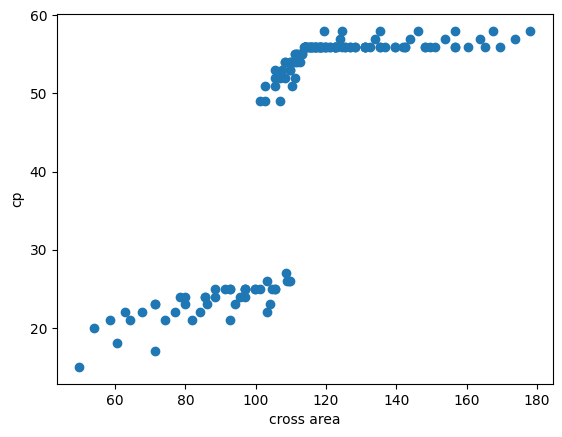

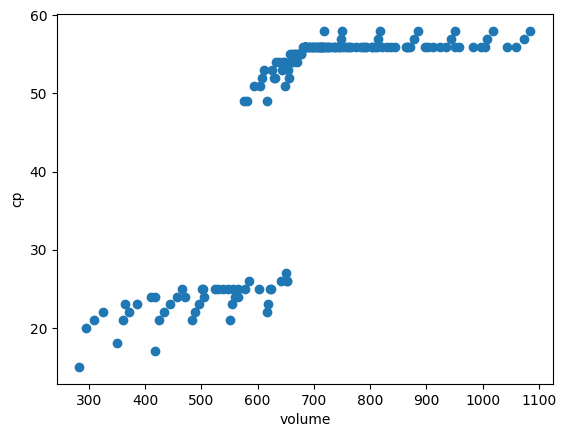

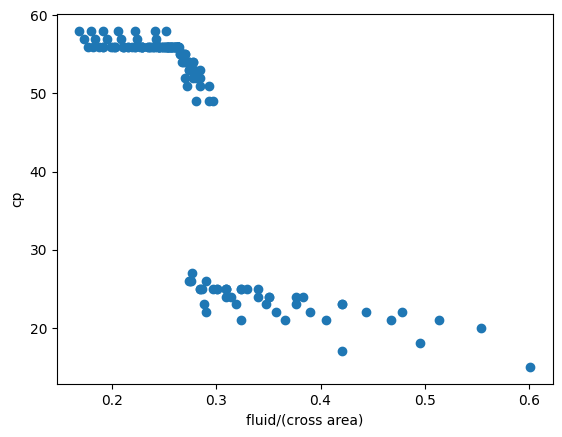

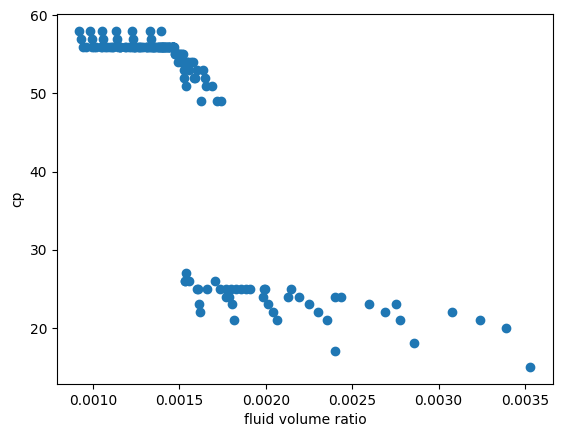

In [30]:
data = subdivide_lst(all_prob_sets[3], fs["rr0s"])[0]
for f_name in theory_fs.keys():
  plot_hydros_against_1(data, "am", 0.01, theory_fs[f_name], xlabel = f_name, ylabel = "cp")

15 58


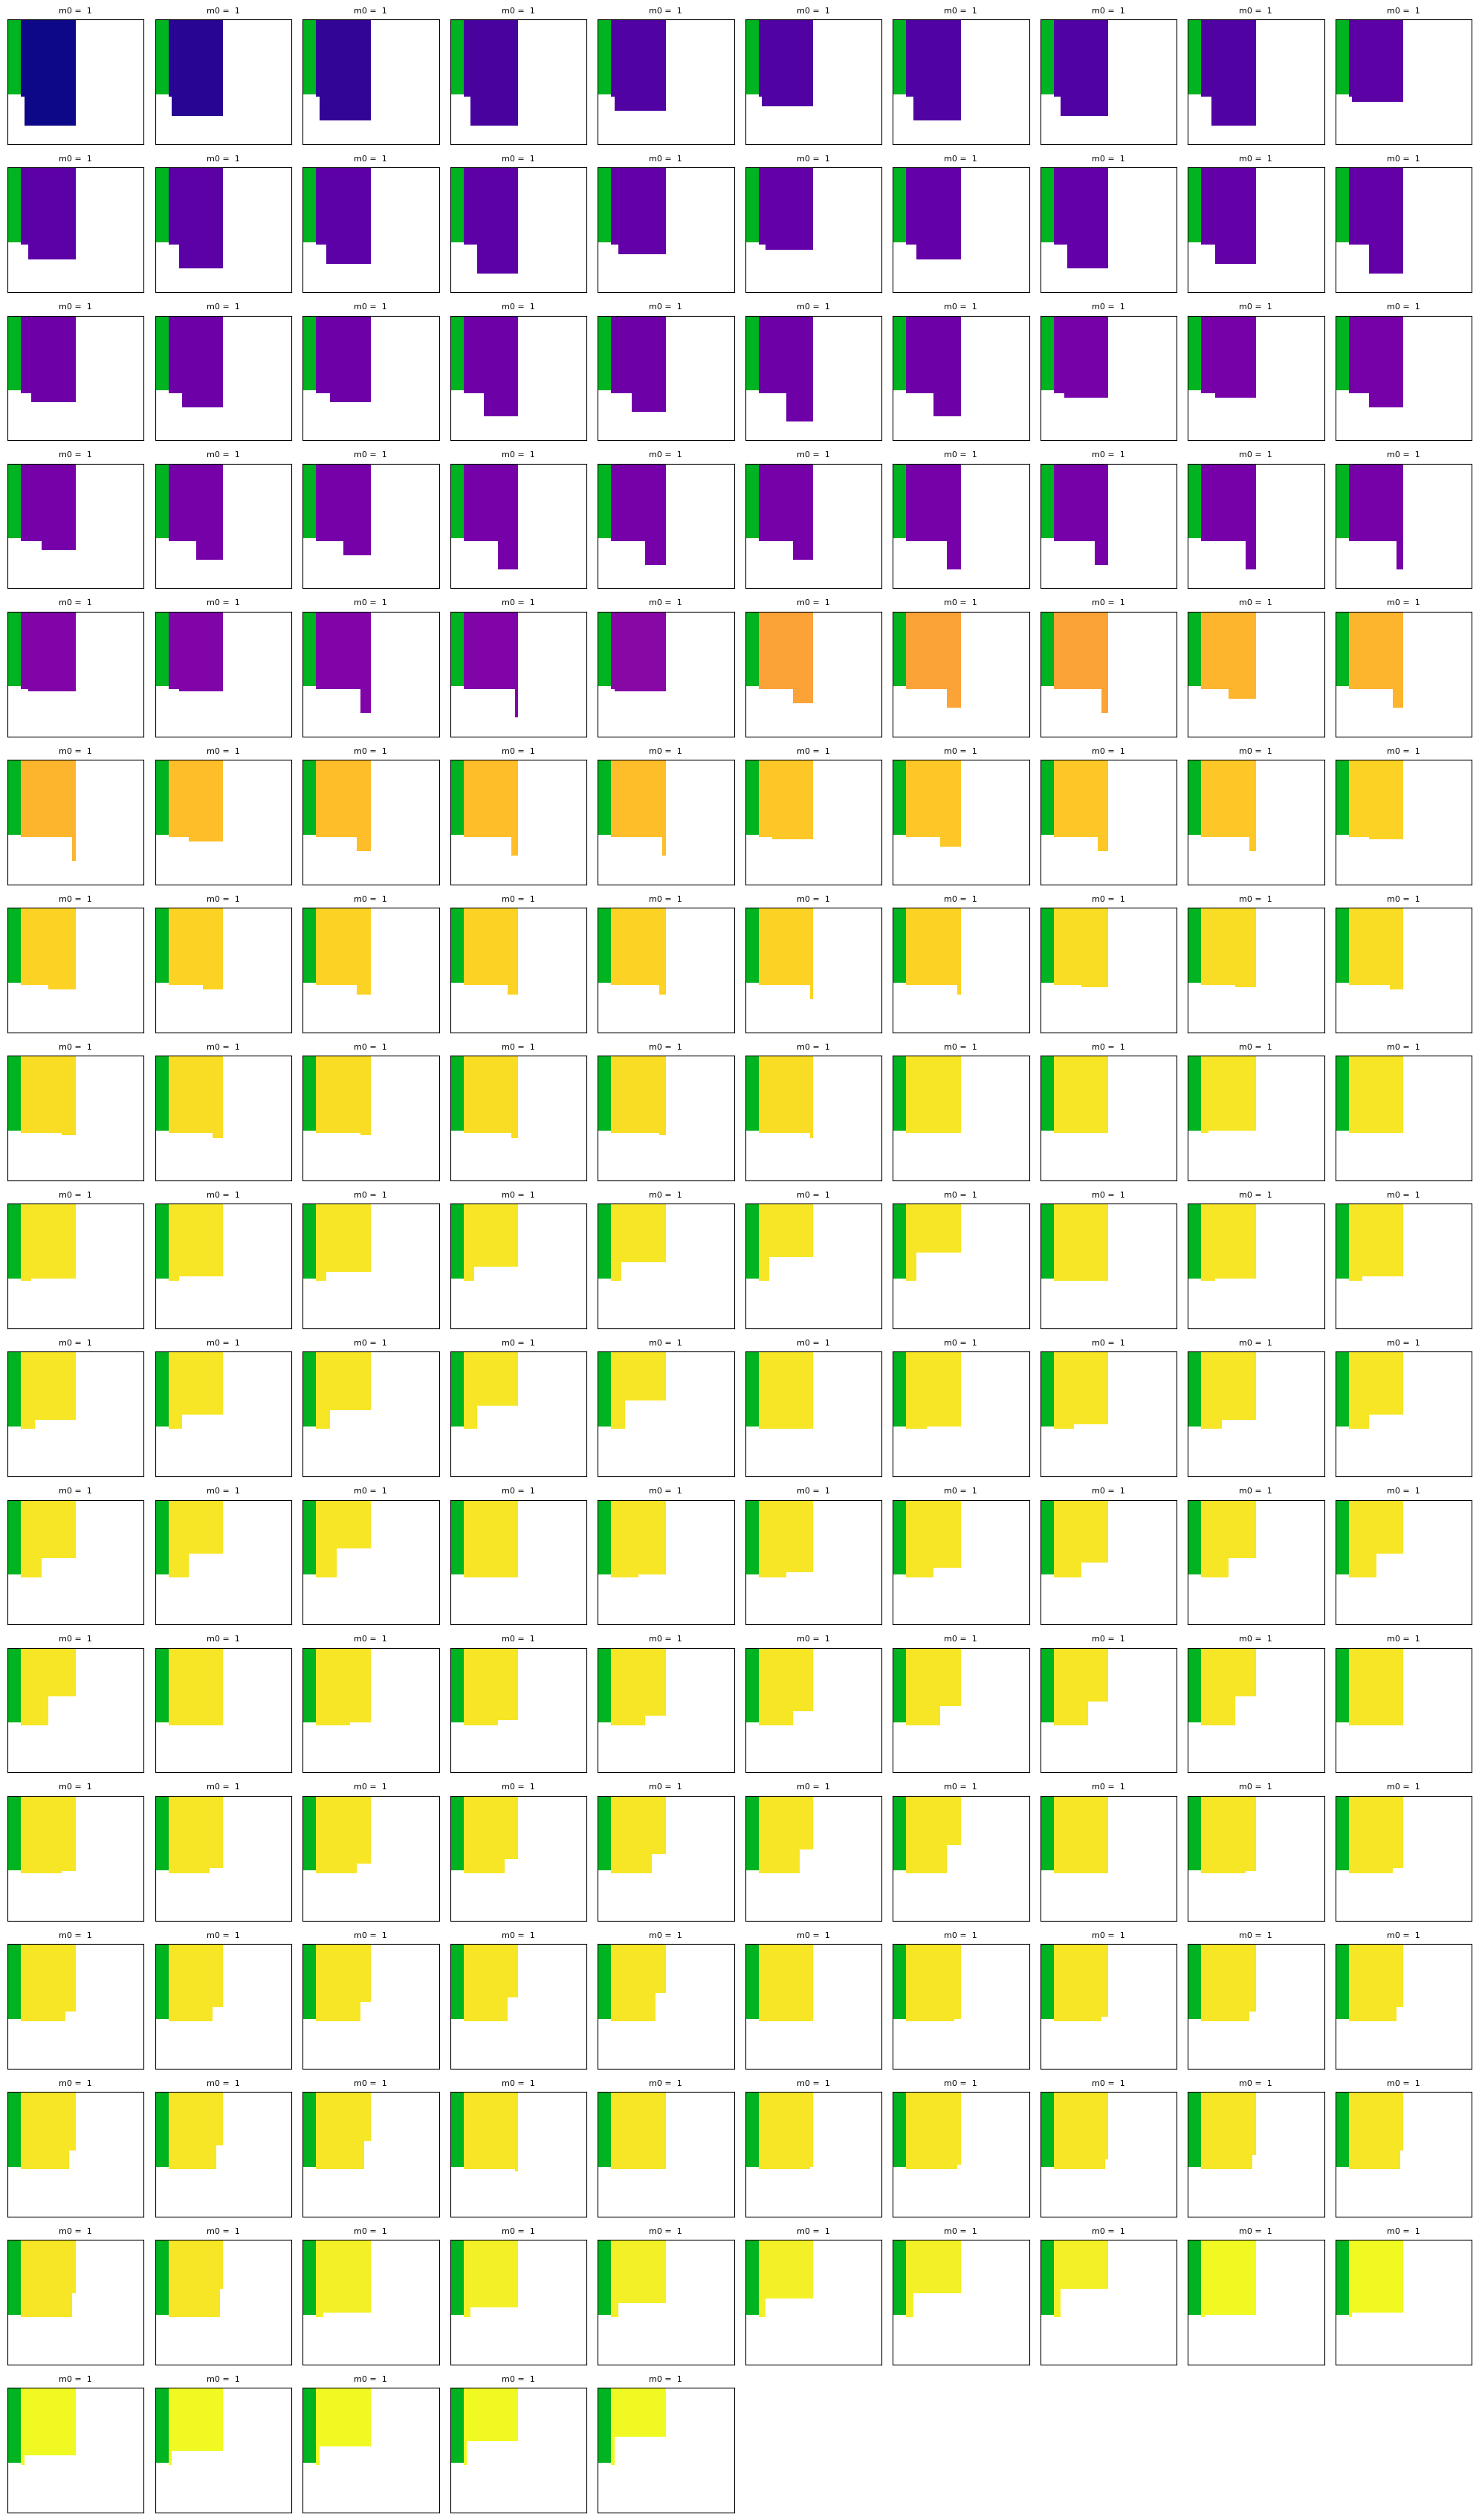

15 121


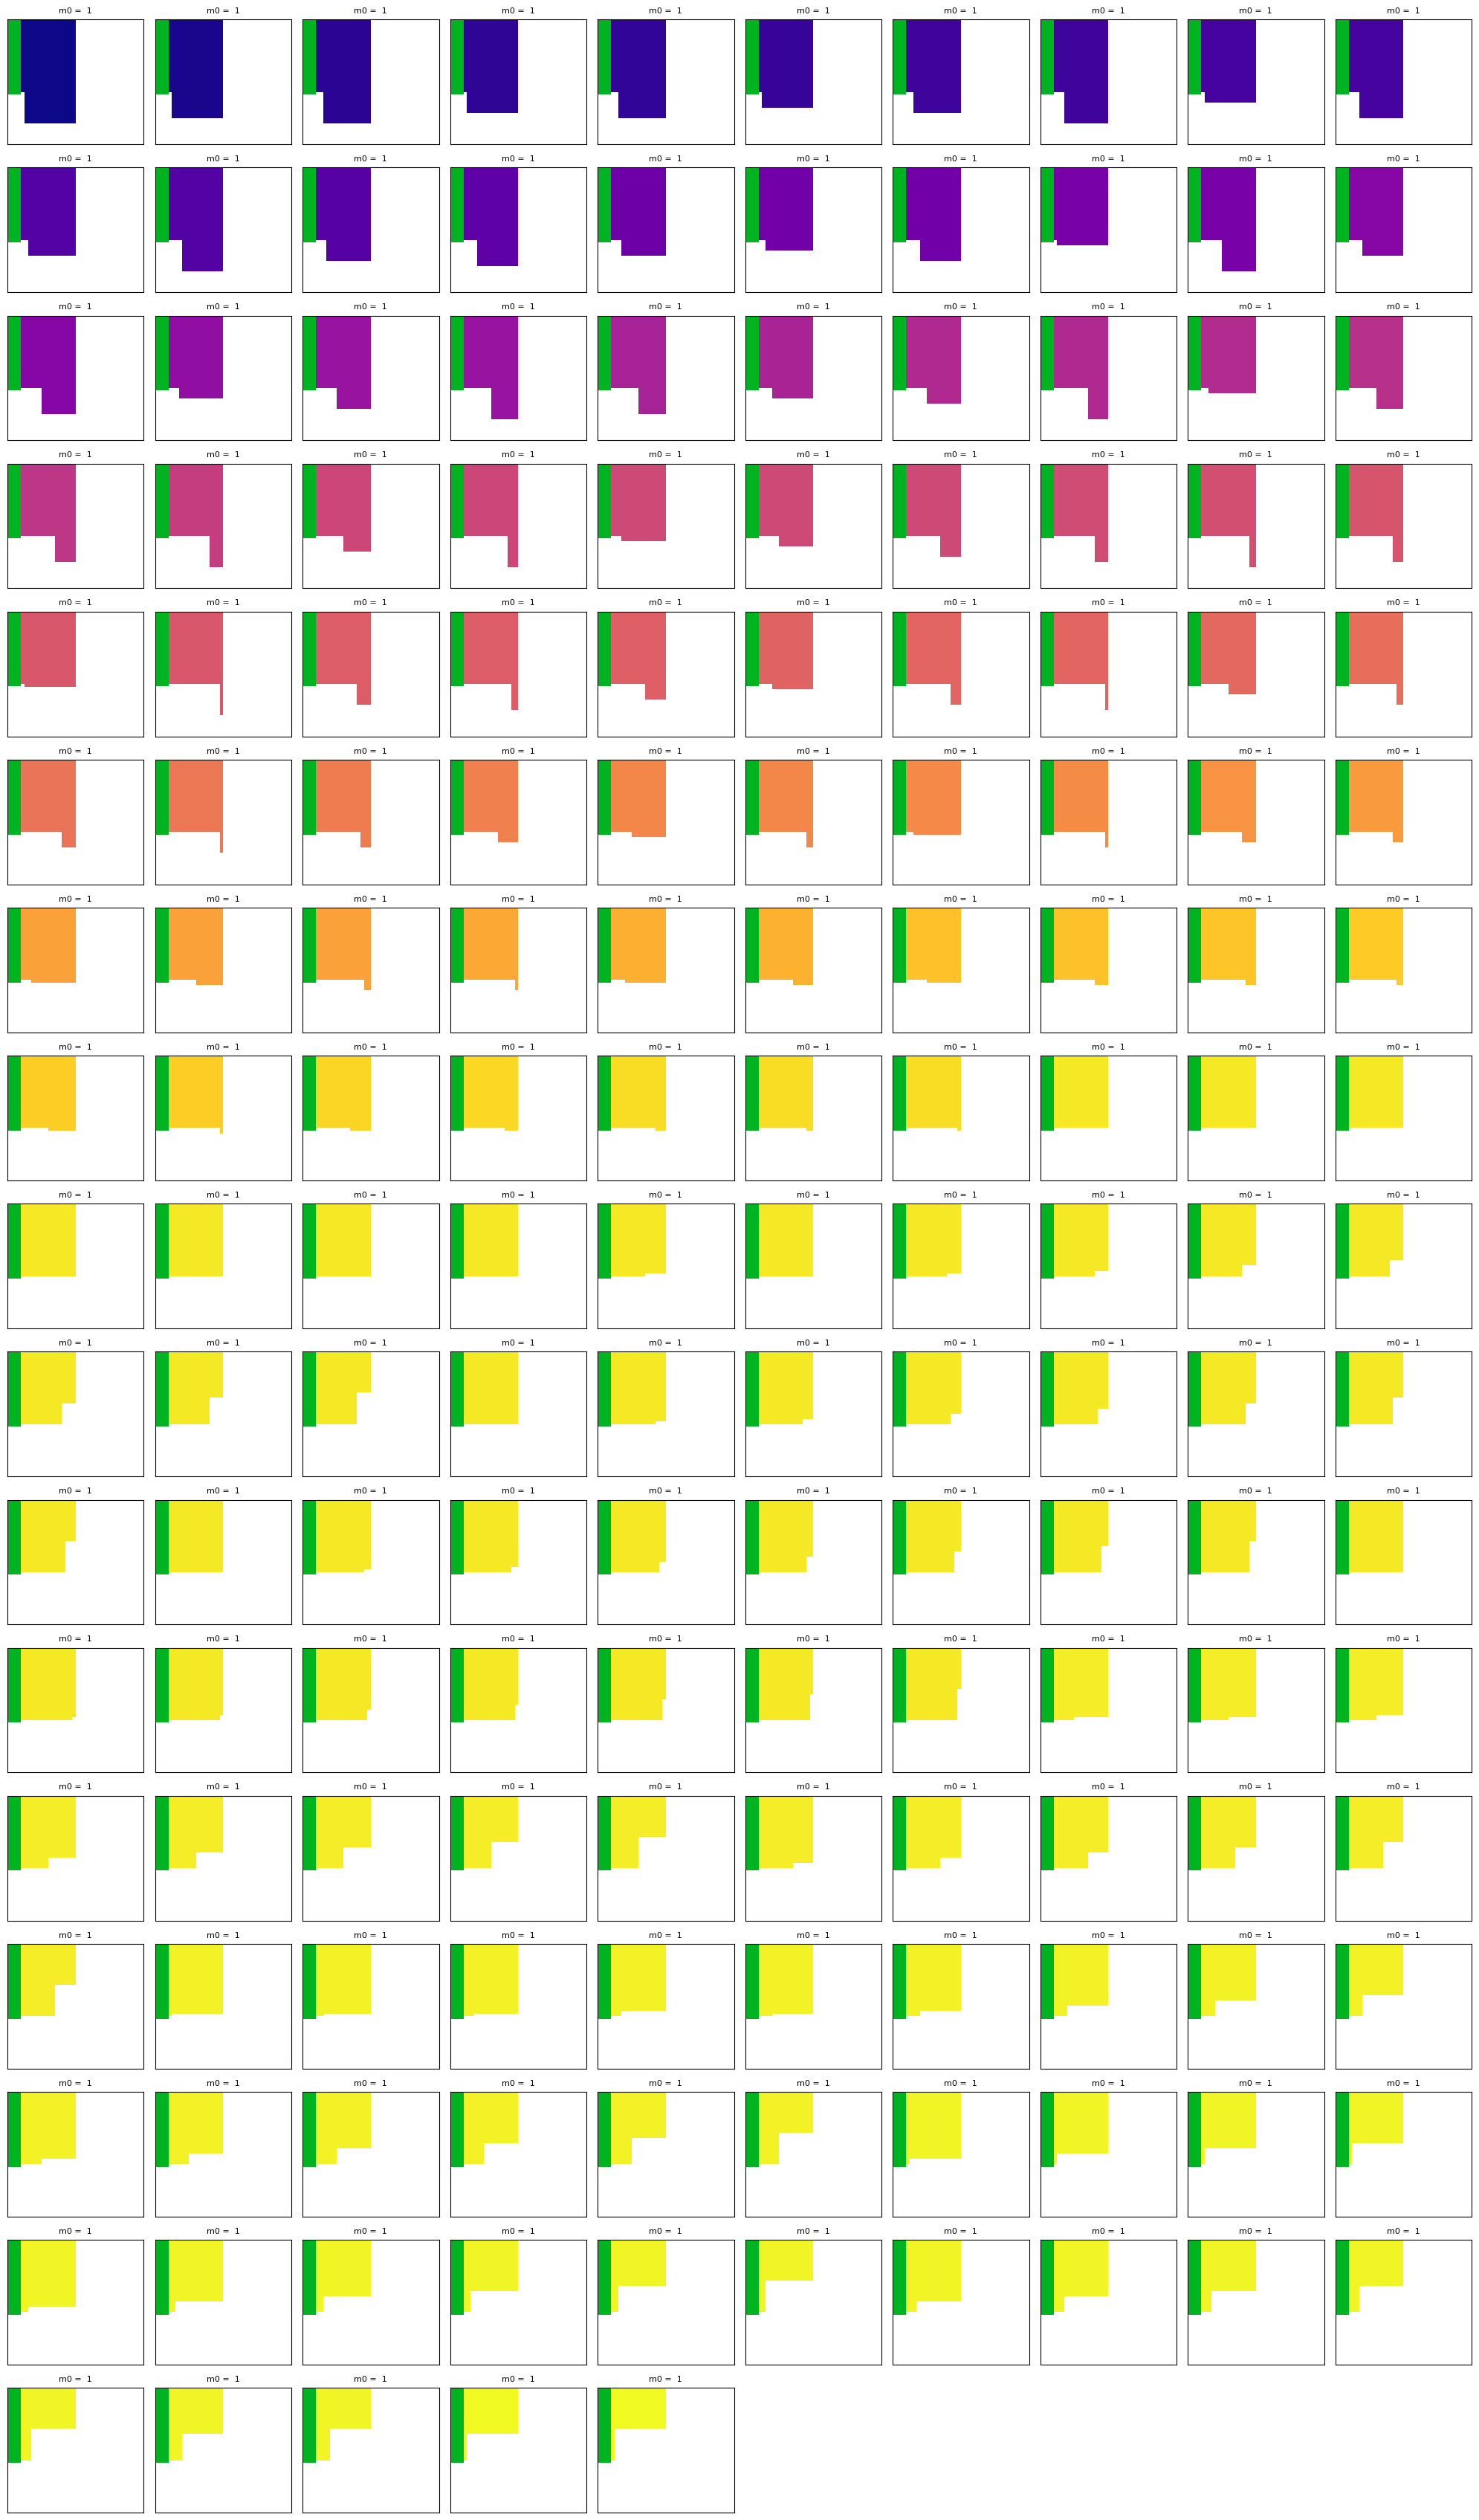

In [10]:
for data in subdivide_lst(all_prob_sets[2], fs["rr0s"]):
  labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in data]
  labels.sort()
  print(min(labels), max(labels))
  if labels[-1] != labels[0]:
    plot_varied_cases([data], 0, "am")

15 58


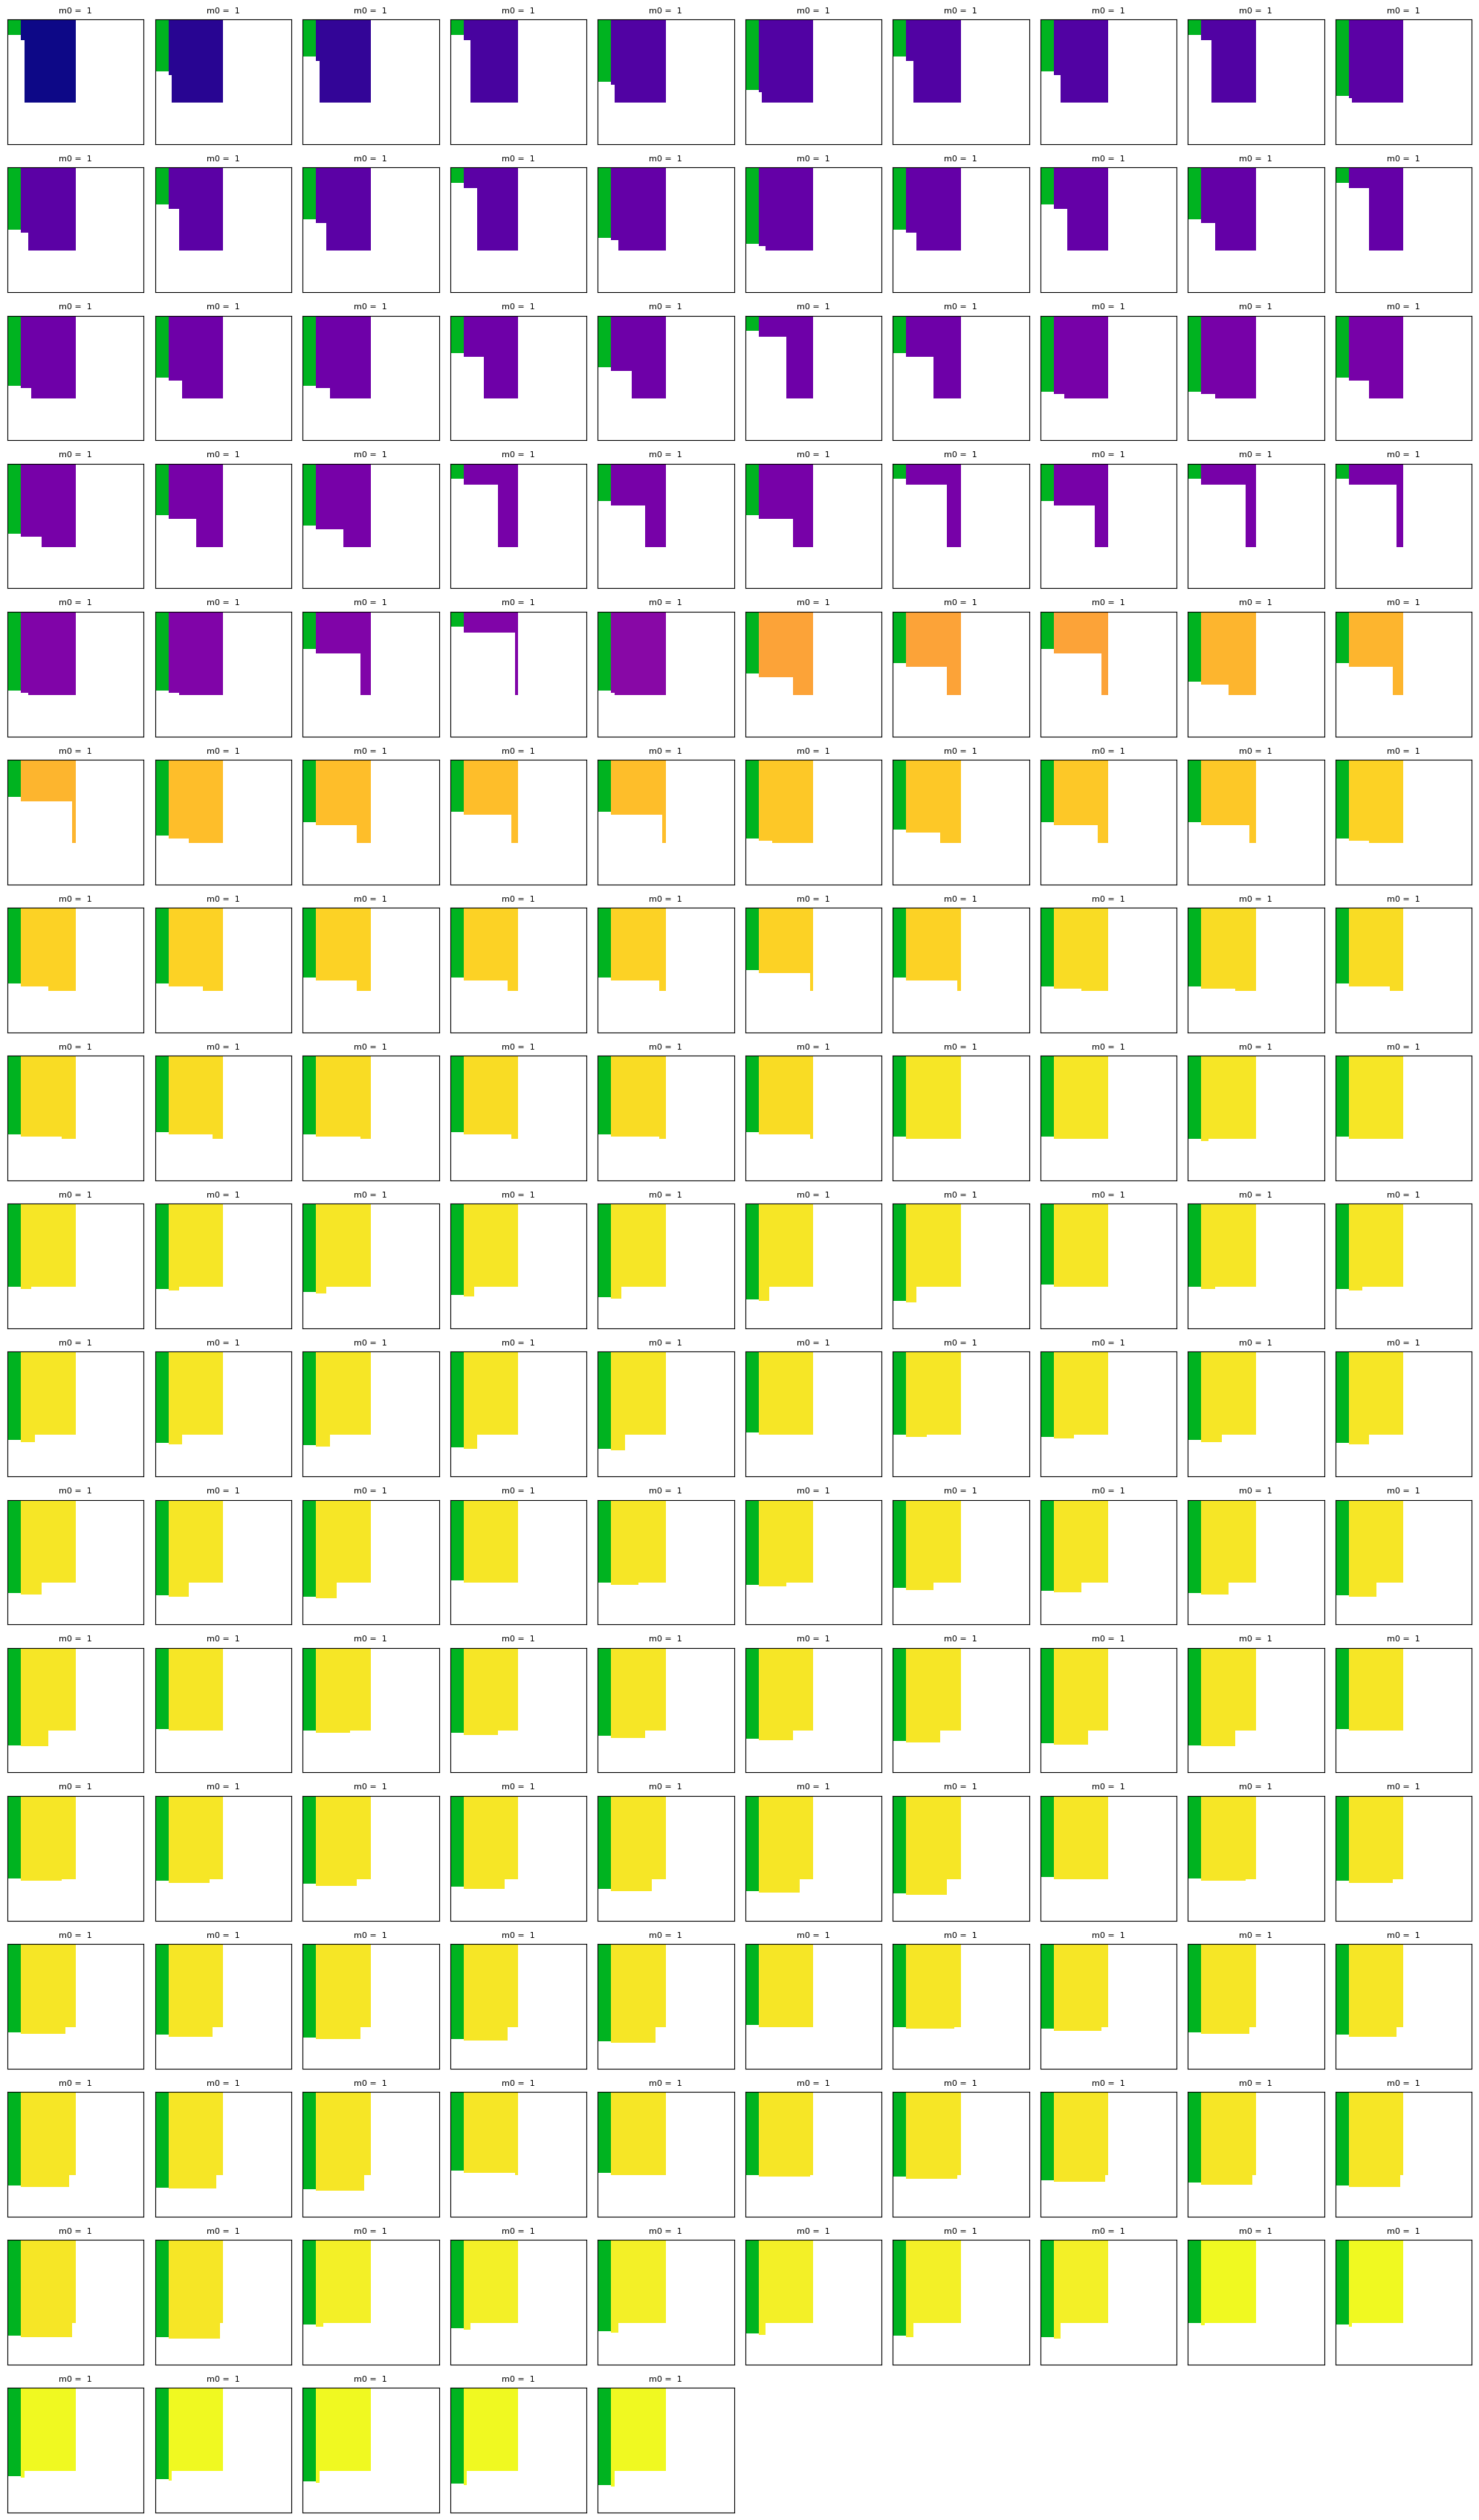

15 120


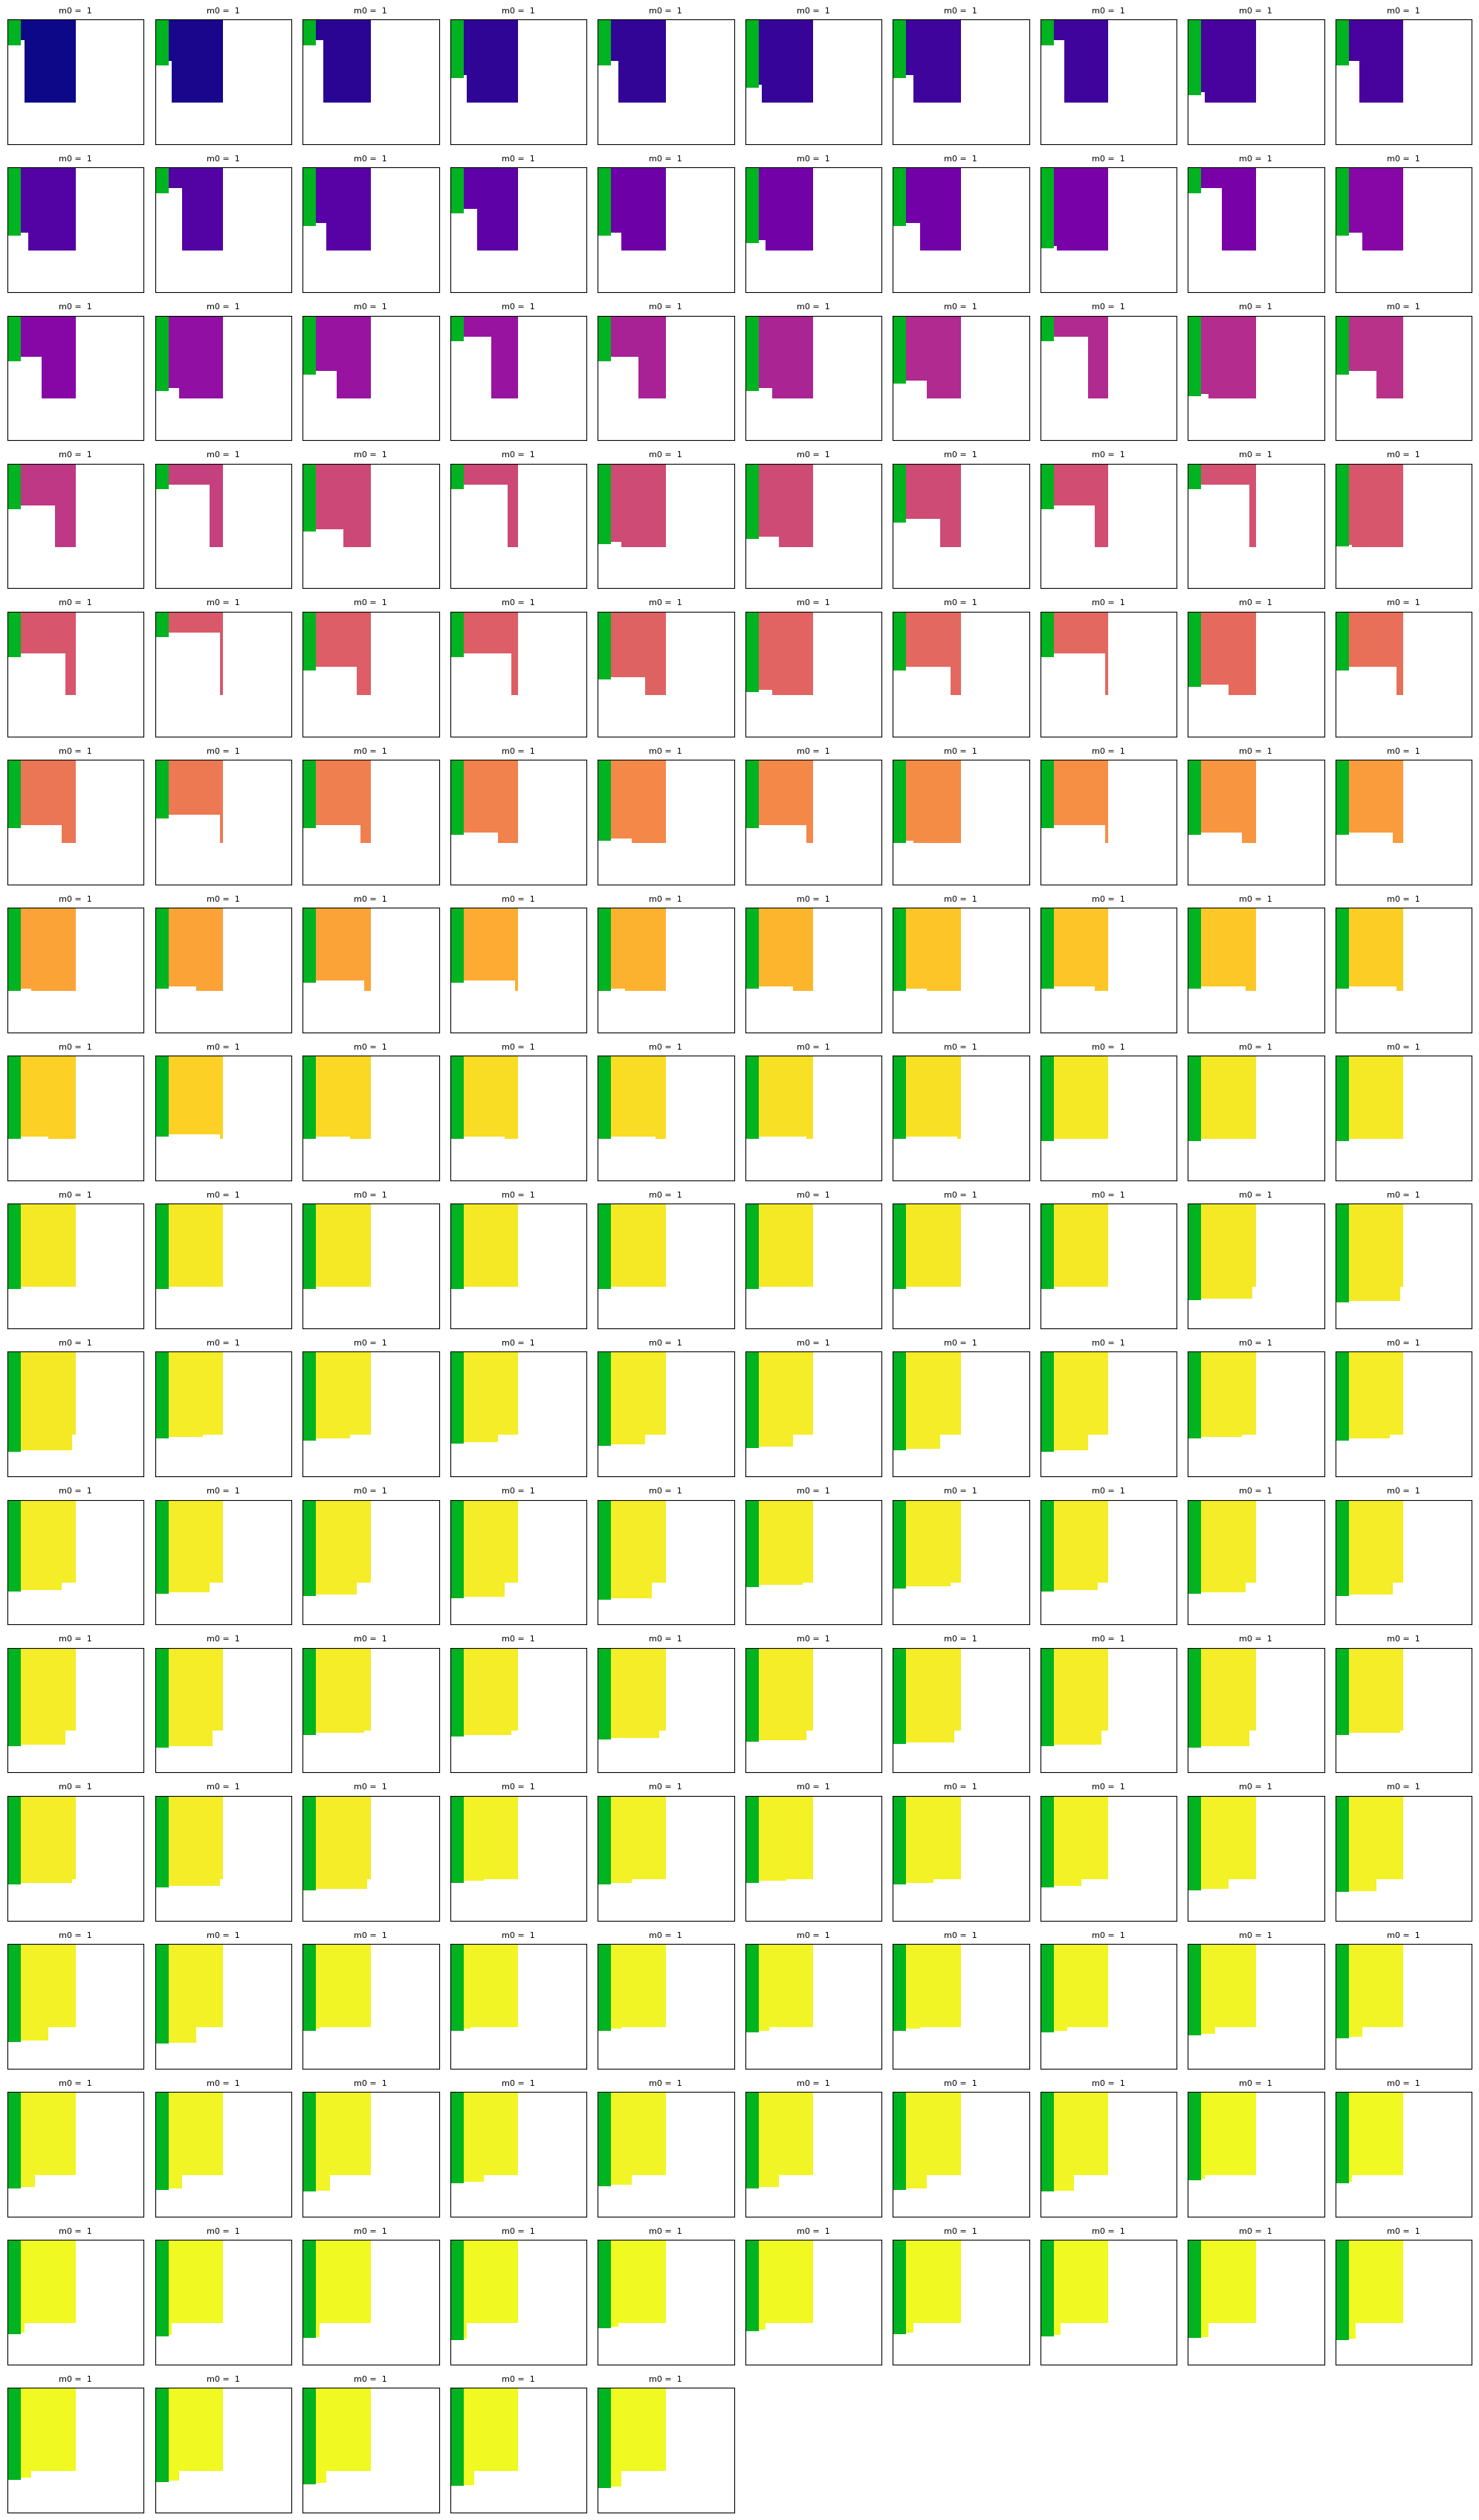

In [15]:
for data in subdivide_lst(all_prob_sets[3], fs["rr0s"]):
  labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in data]
  labels.sort()
  print(min(labels), max(labels))
  if labels[-1] != labels[0]:
    plot_varied_cases([data], 0, "am")

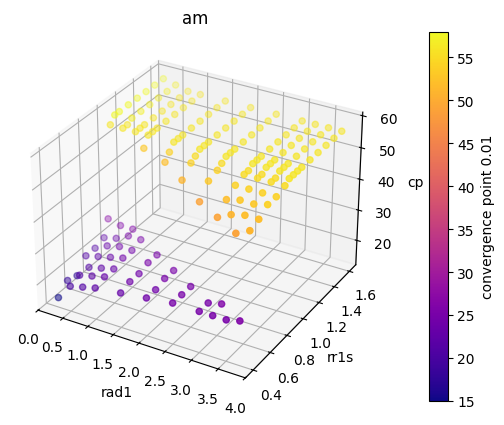

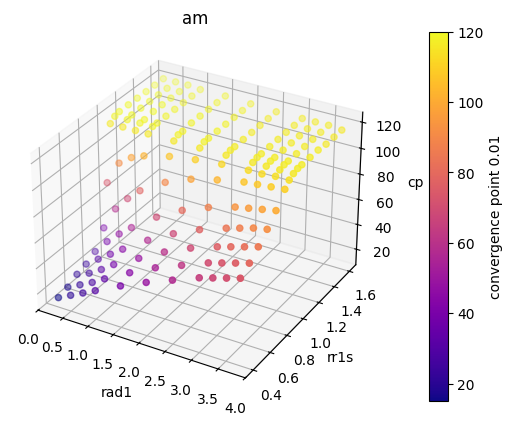

In [22]:
f = lambda data_dict, m0 : data_dict[m0]["convergence point 0.01 am"]
for data in subdivide_lst(all_prob_sets[3], fs["rr0s"]):
  plot_hydros_against_3(data, "am", 0.01, fs["rad1"], fs["rr1s"], f, "rad1", "rr1s", "cp")

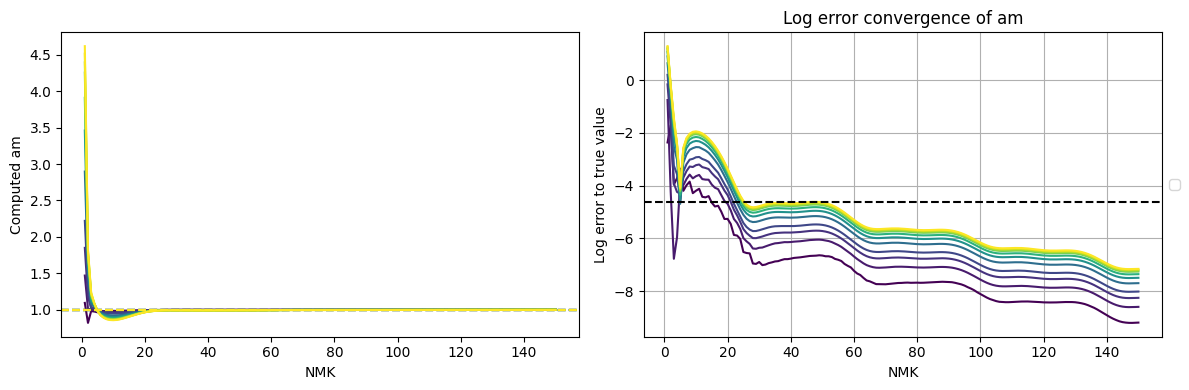

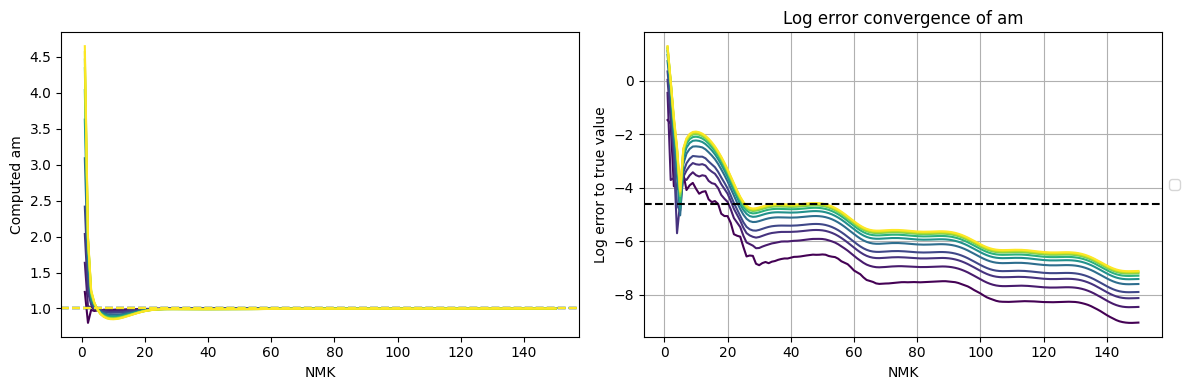

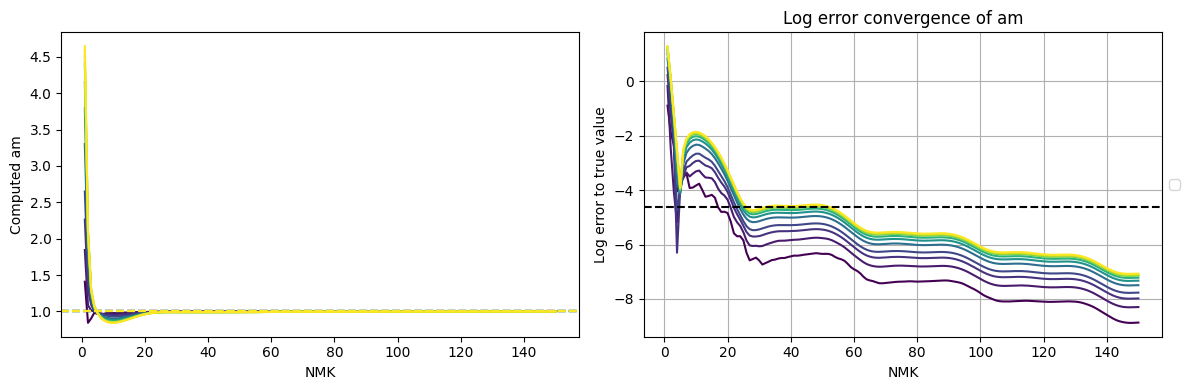

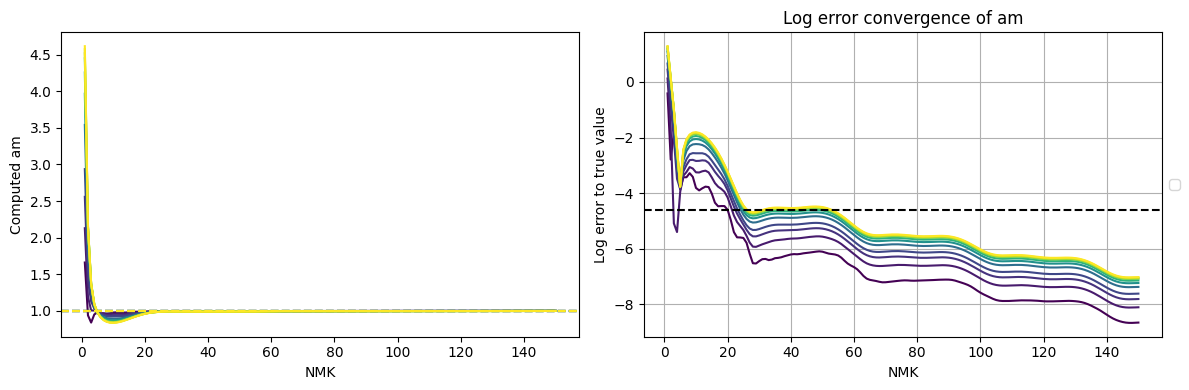

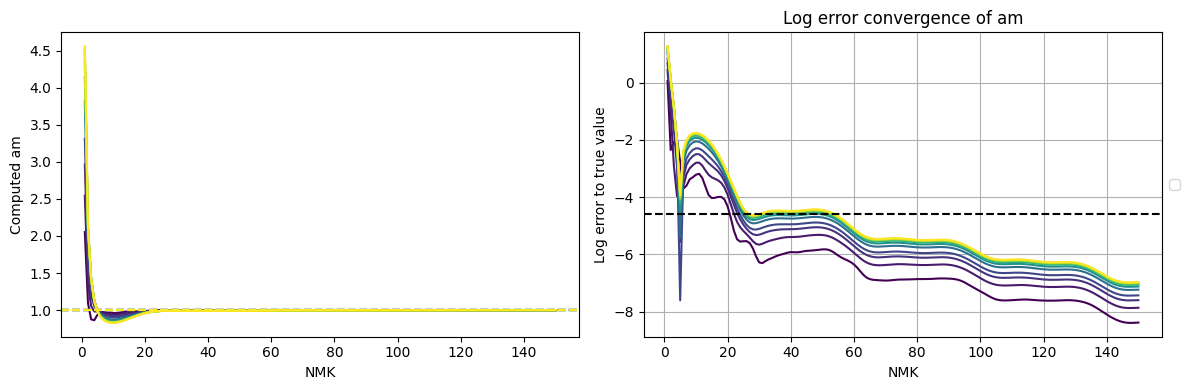

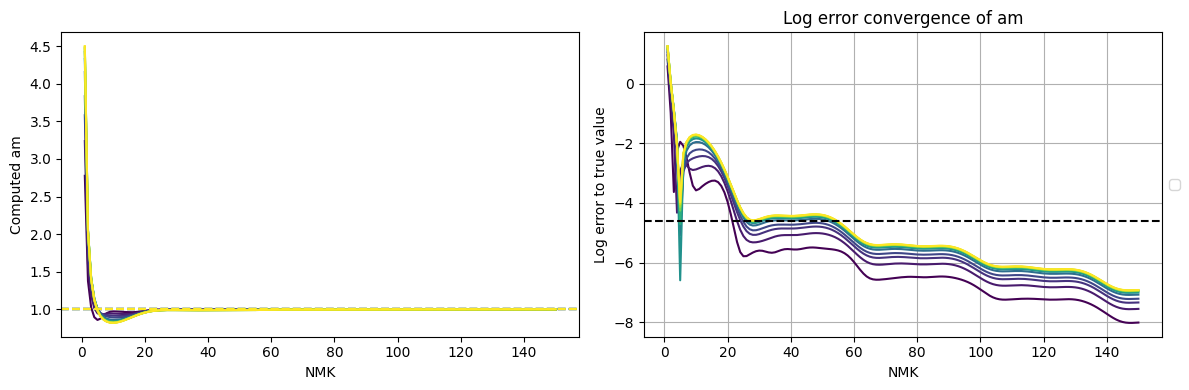

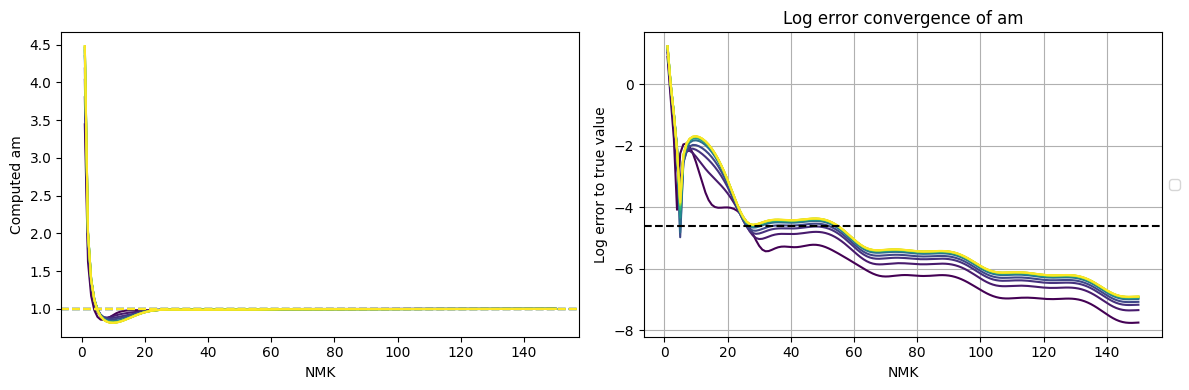

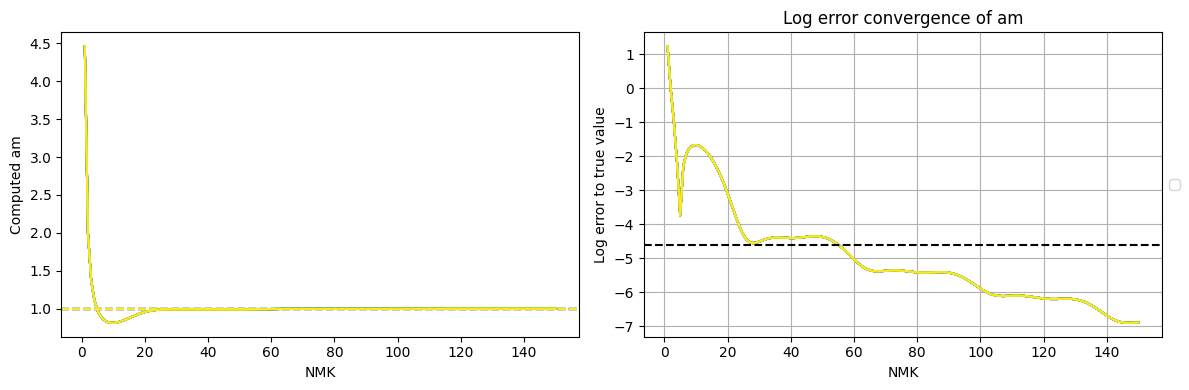

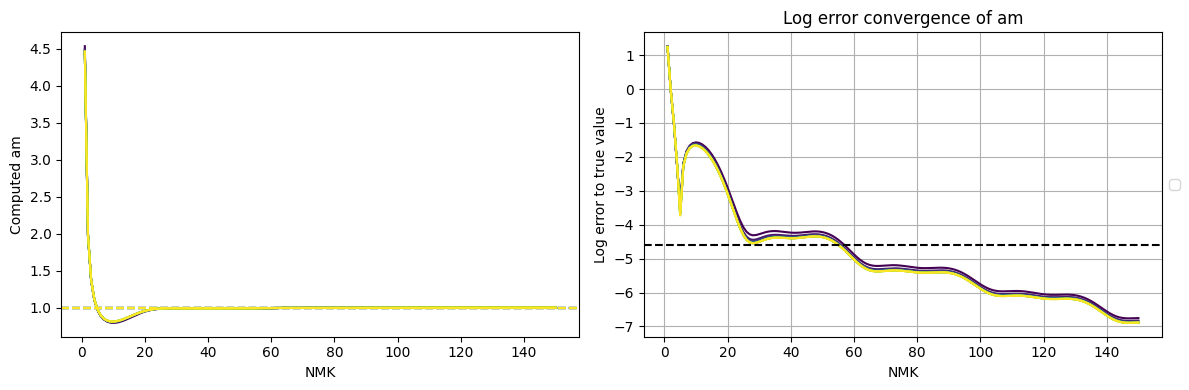

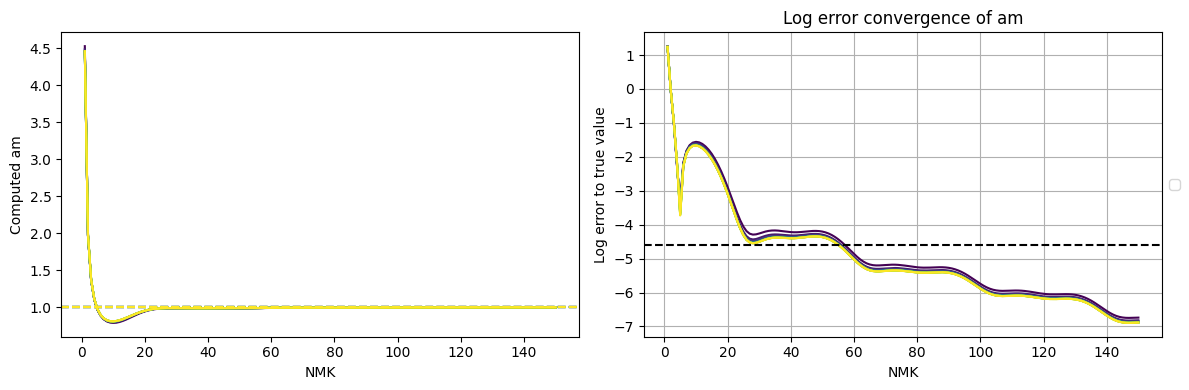

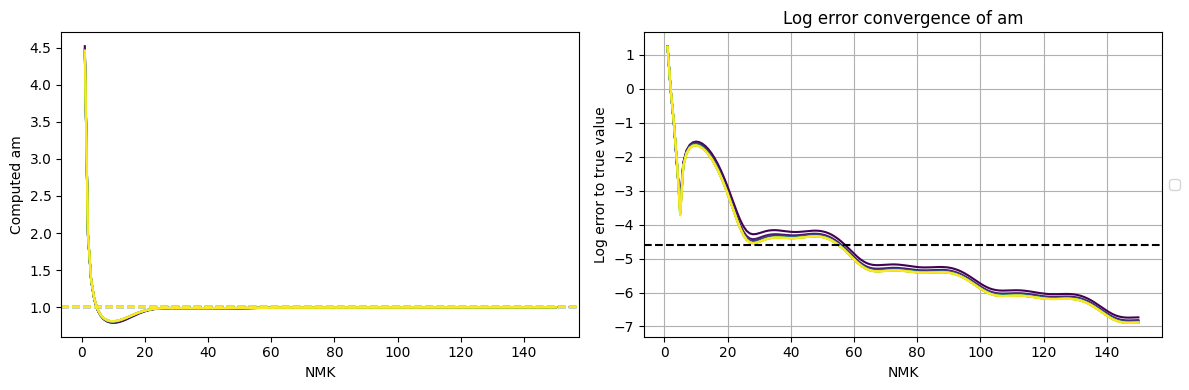

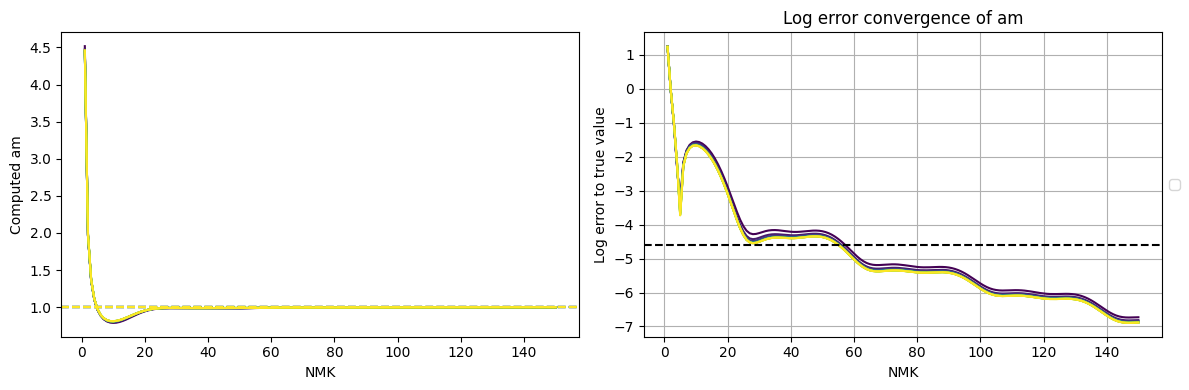

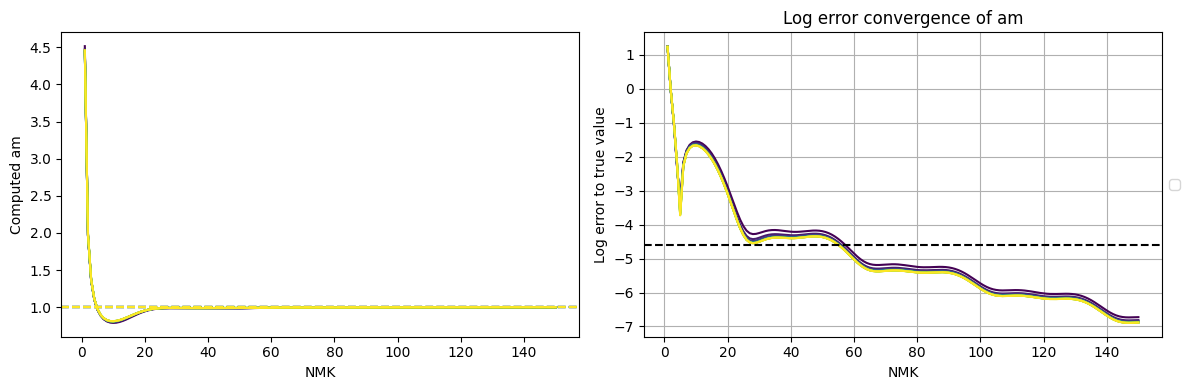

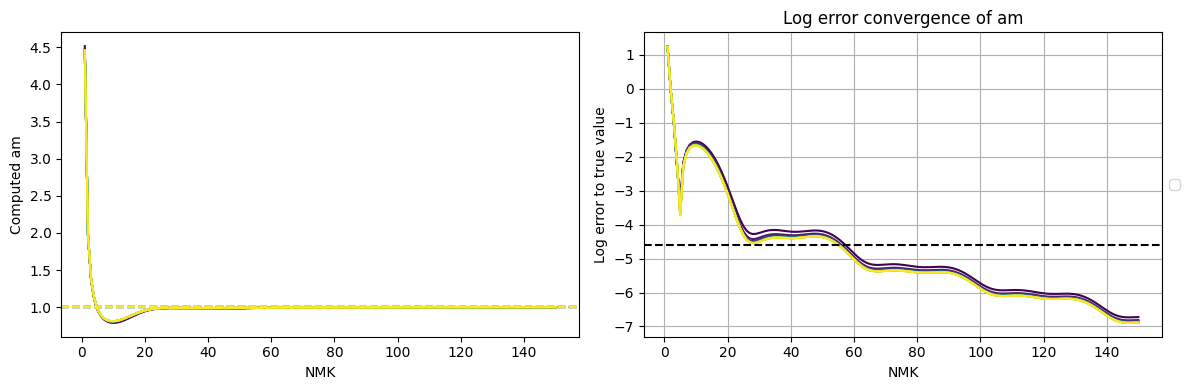

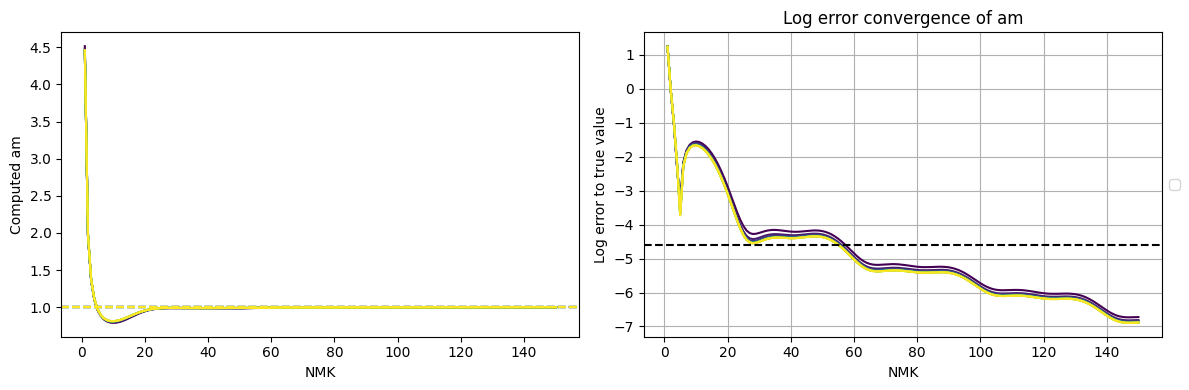

In [19]:
rr0_idx = 0
for rr1_idx in range(15):
  data = subdivide_lst(subdivide_lst(all_prob_sets[3], fs["rr0s"])[rr0_idx], fs["rr1s"])[rr1_idx]
  formatted_data = many_data_dicts_to_convergence_plot_data(data)
  colors = color_by_f_value(fs["rad1"], data, cmap = "viridis")
  plot_set_convergence_and_log(formatted_data, "am", colors = colors, scale = True, show_error = True, trunc = 0)

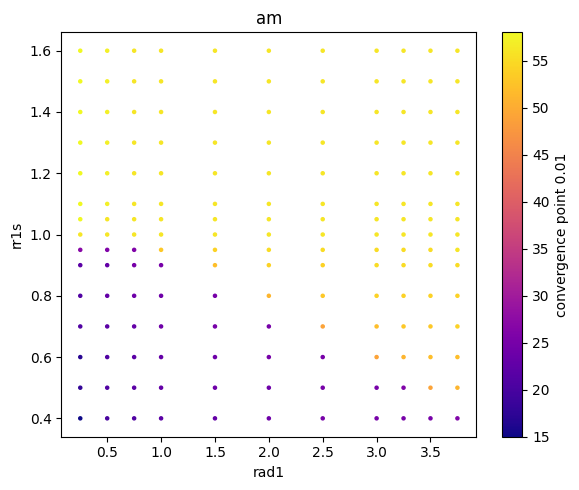

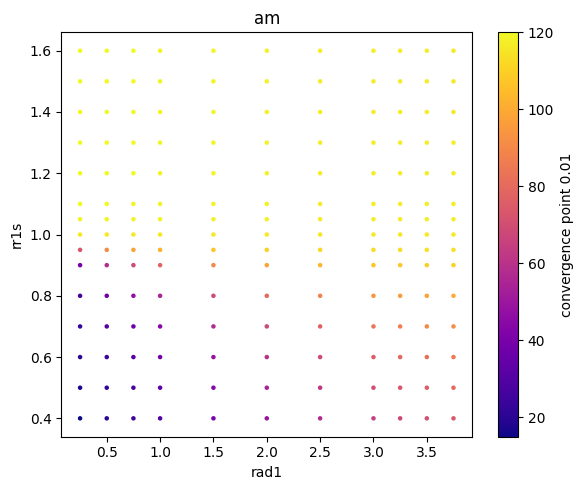

In [20]:
for data in subdivide_lst(all_prob_sets[3], fs["rr0s"]):
  plot_hydros_against_2(data, "am", 0.01, fs["rad1"], fs["rr1s"], "rad1", "rr1s")

0.39999999999999997 15 26


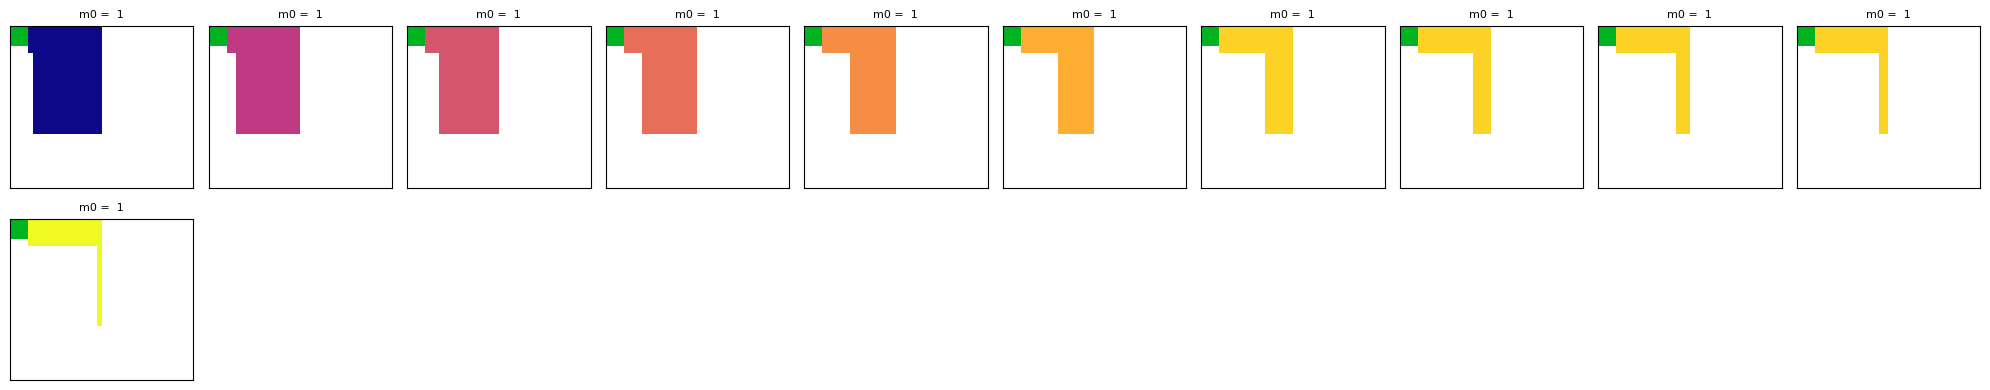

0.5 18 51


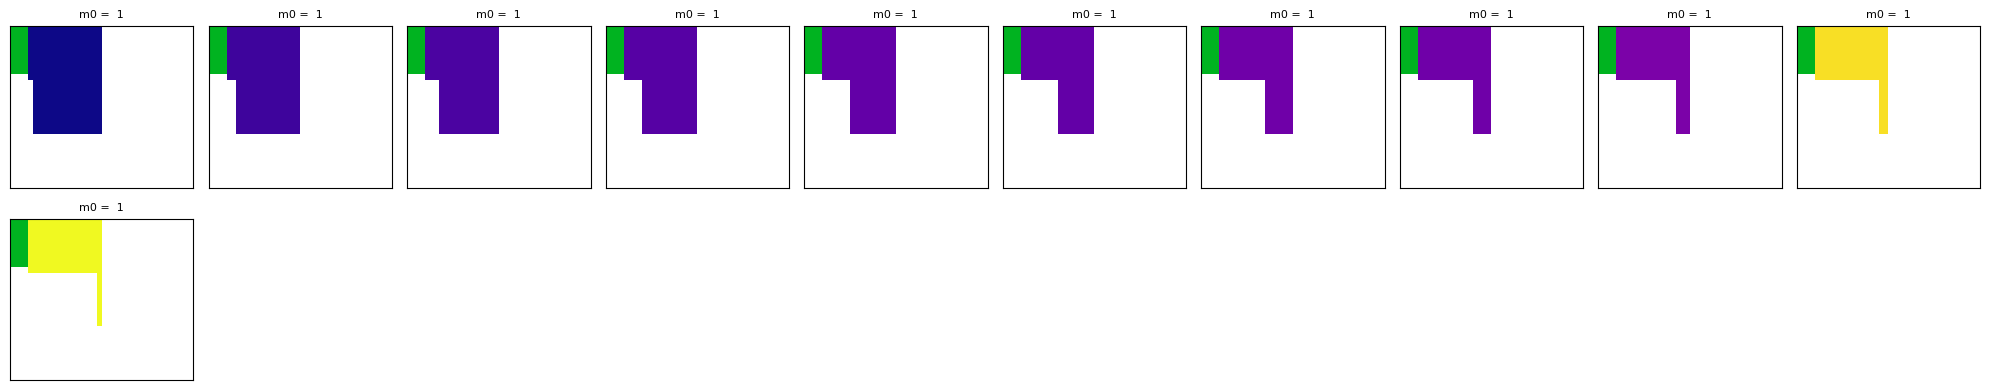

0.5999999999999998 17 52


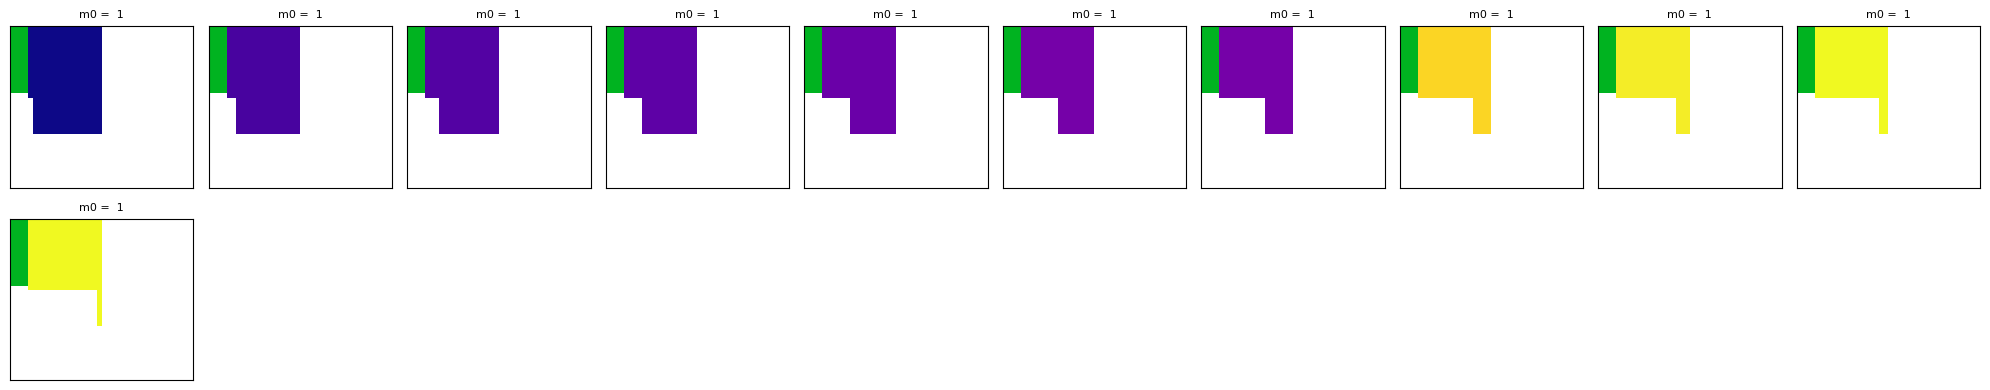

0.7000000000000001 21 54


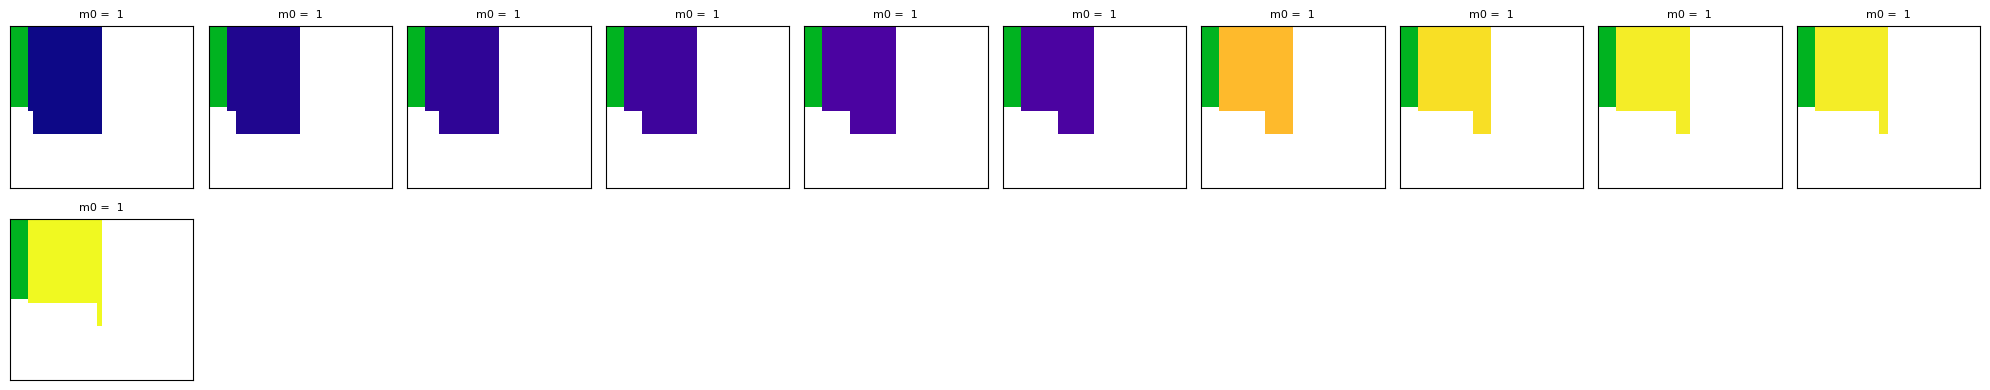

0.7999999999999999 21 54


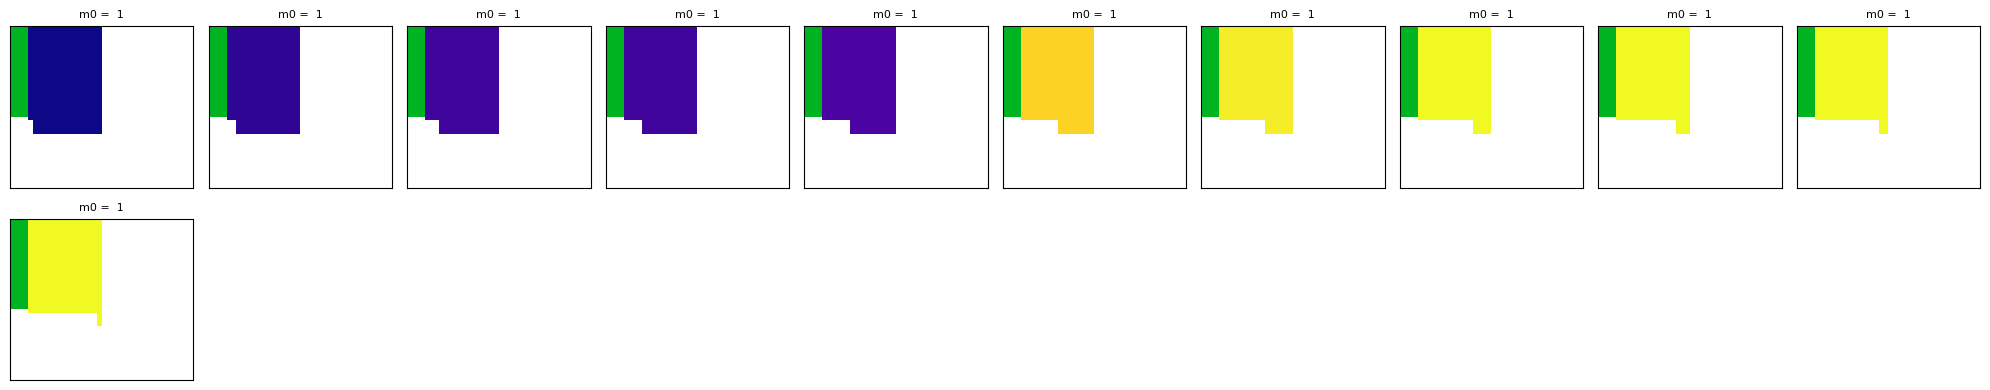

0.9000000000000002 22 55


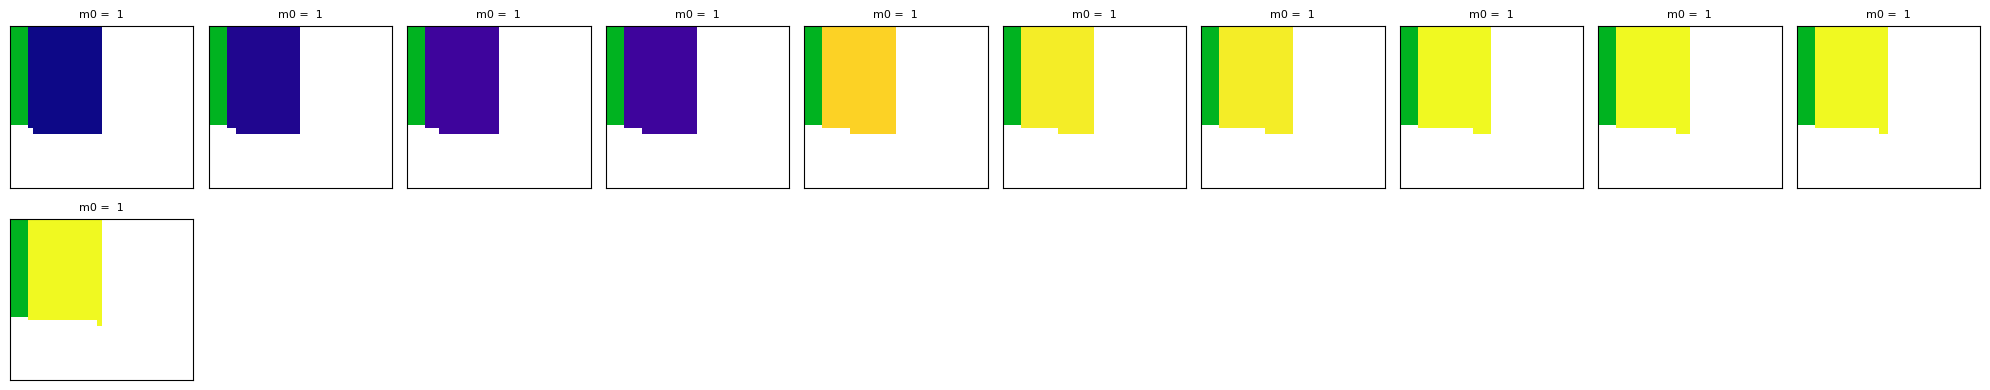

0.9500000000000001 26 56


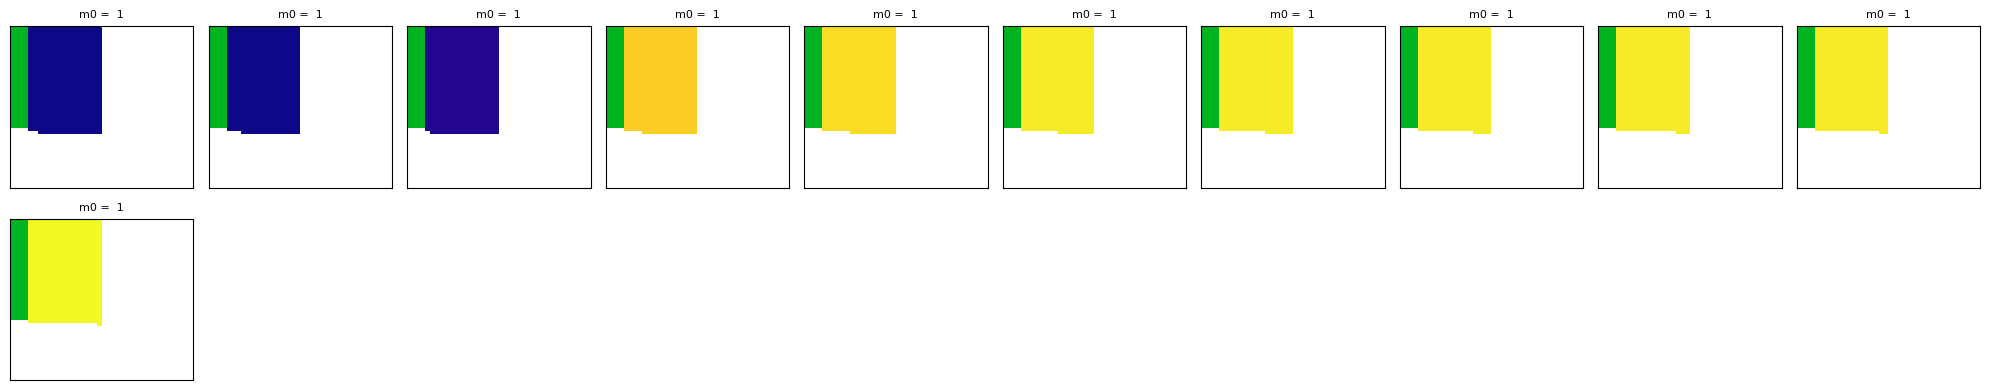

1.0 56 56
1.0499999999999998 56 58


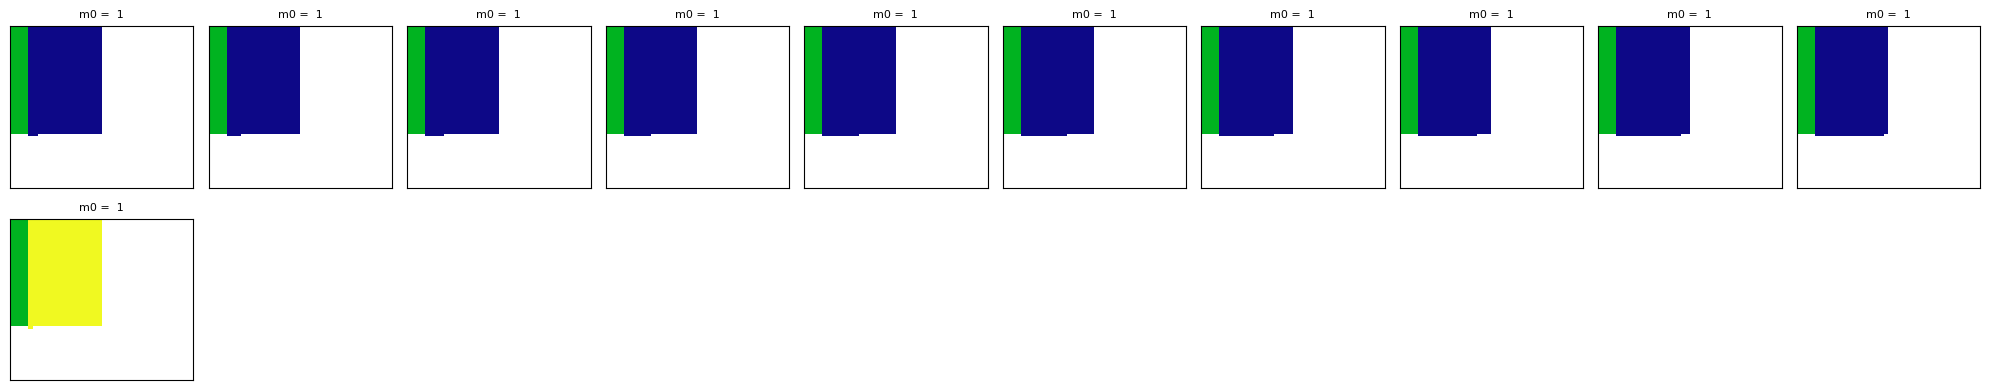

1.1 56 58


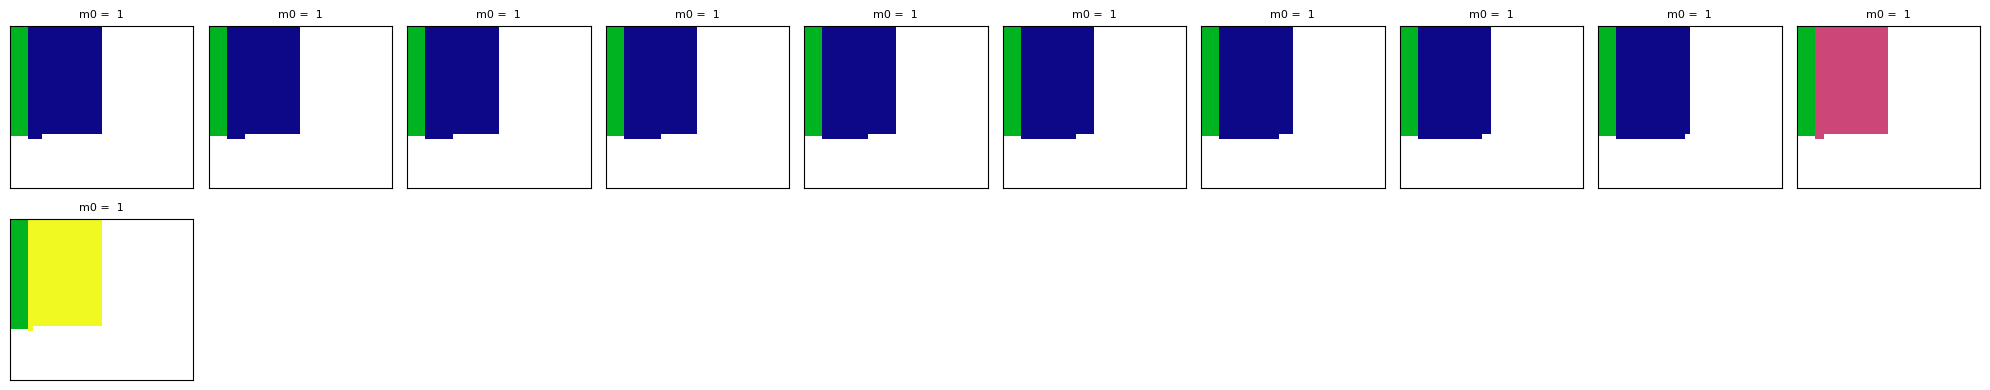

1.1999999999999995 56 58


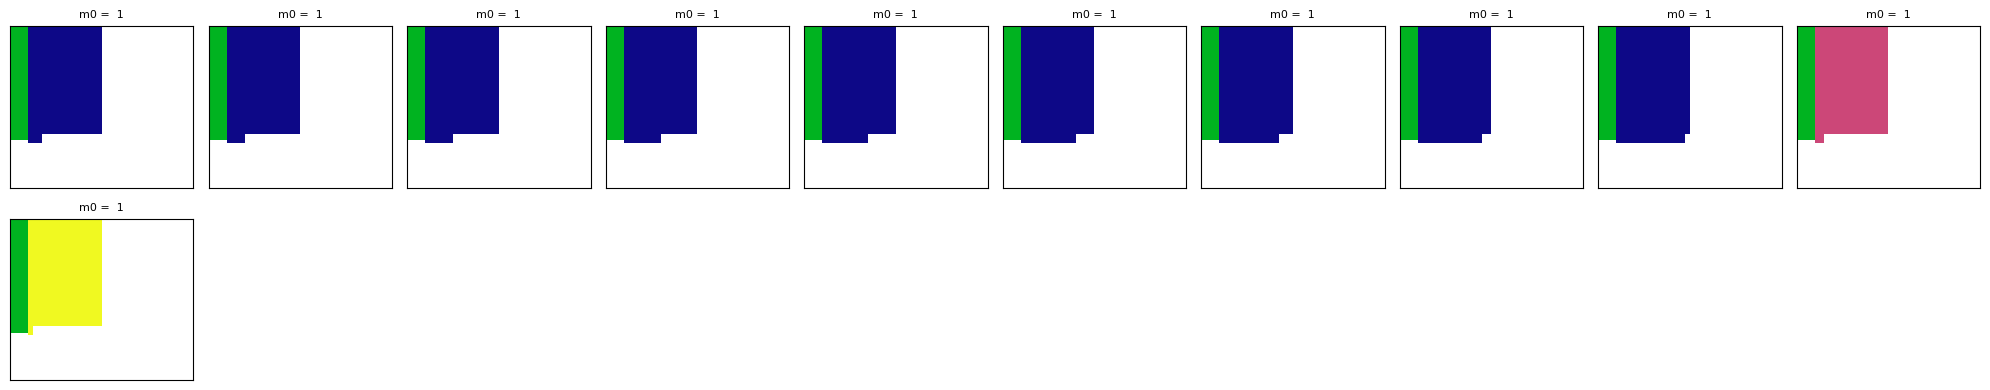

1.3000000000000005 56 58


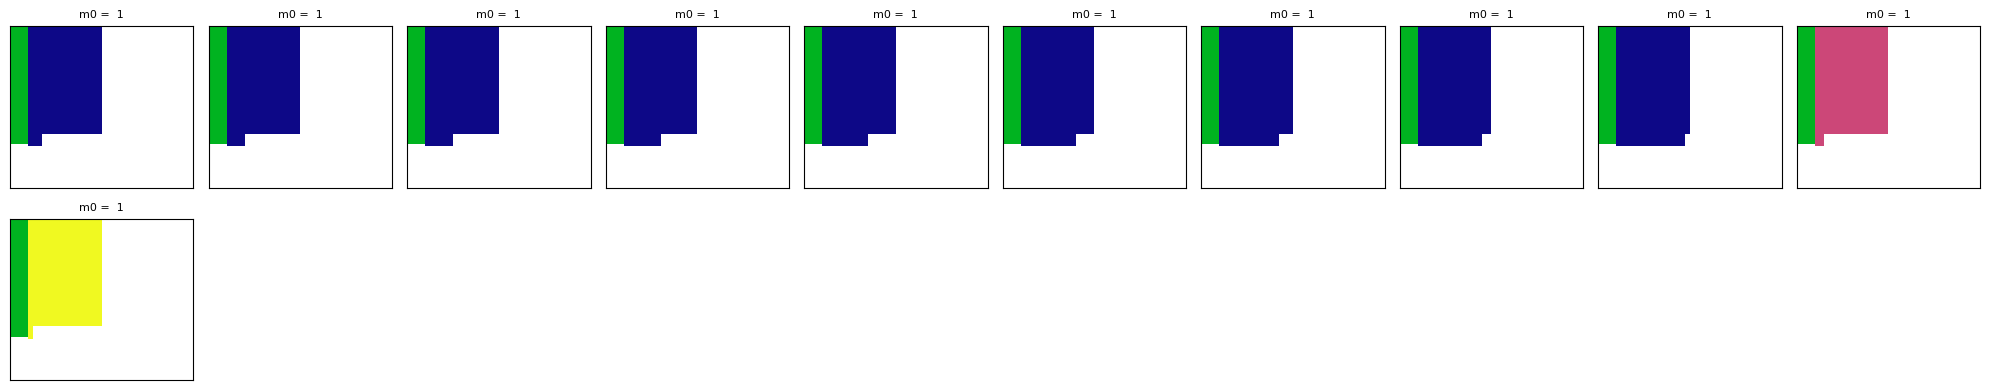

1.4000000000000001 56 58


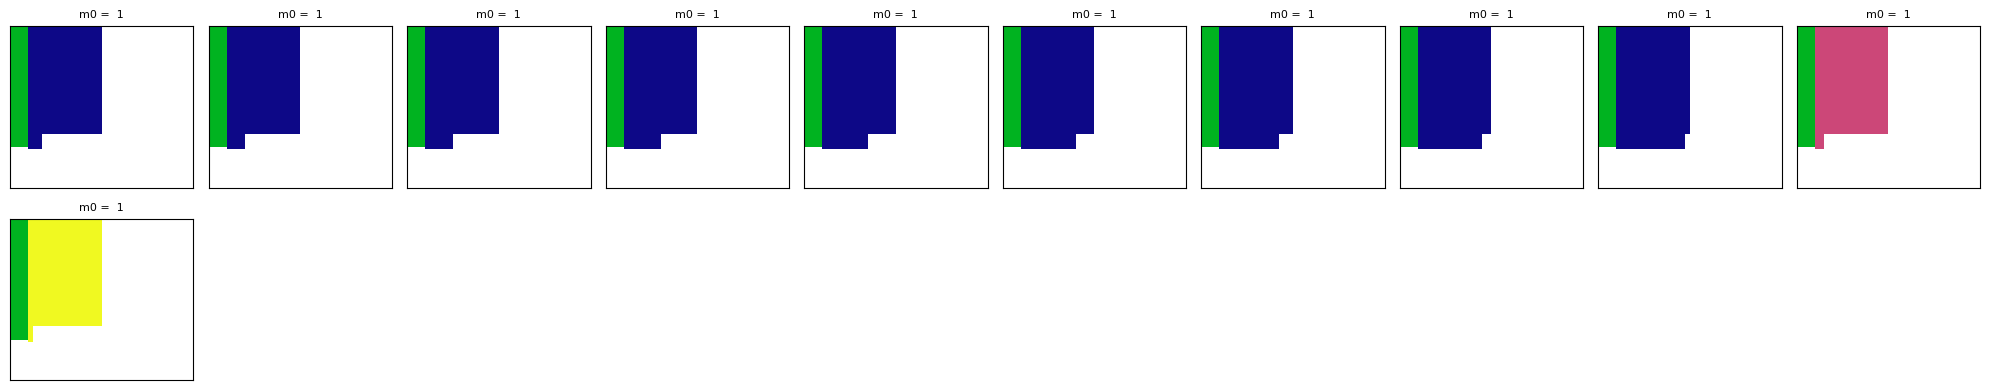

1.5 56 58


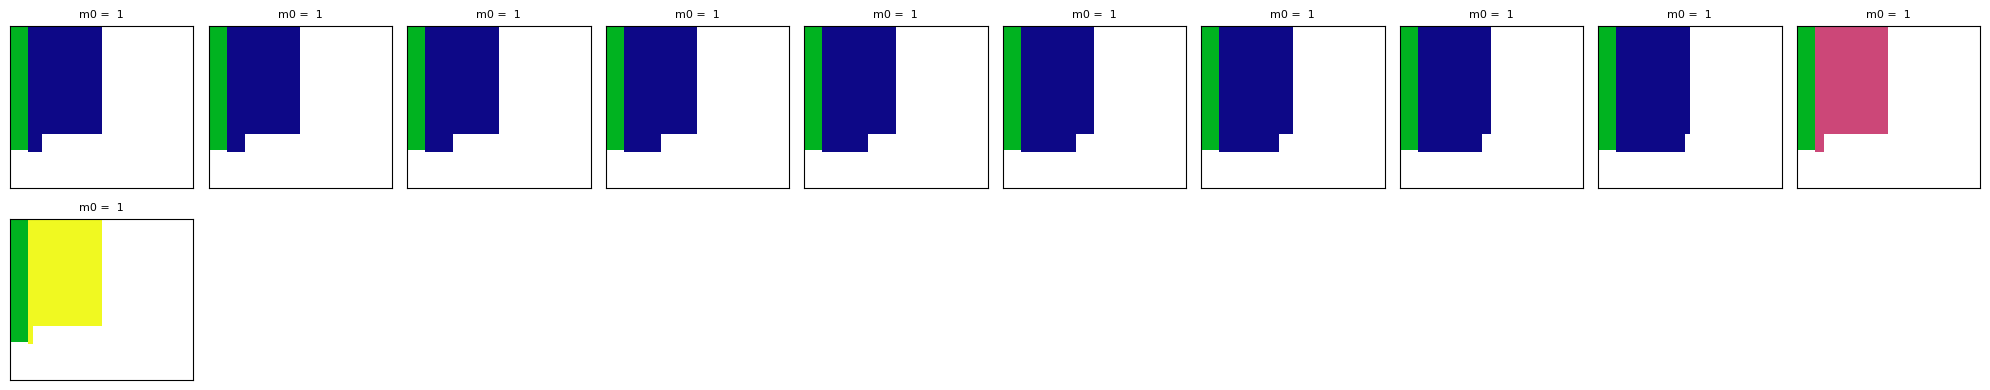

1.5999999999999999 56 58


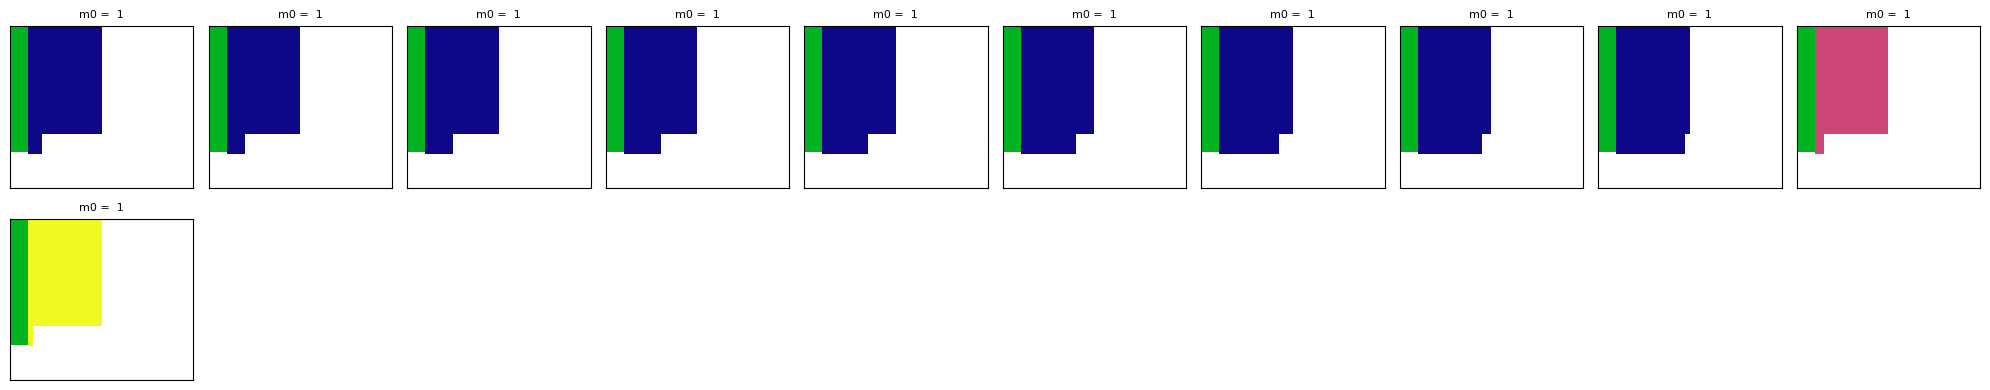

In [21]:
all_data = subdivide_lst(all_prob_sets[3], fs["rr0s"])[0]
for data in subdivide_lst(all_data, fs["rr1s"]):
  labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in data]
  labels.sort()
  print(fs["rr1s"](data[0], data[0]["m0s"][0]), min(labels), max(labels))
  if labels[-1] != labels[0]:
    plot_varied_cases([data], 0, "am")

In [ ]:
####################### BREAK LINE

In [ ]:
file2 = "data/predetermined-6.pkl"

# 0 - rad2 with width of 0.25 moves from inside to outside, see how its position affects its influence.
# 1 - baselines for 0 (two-region, no 0.25 radwidth sliver)
# 2 - rad2 with width of 0.25 moves from inside to outside, no rad3

radwidth0, radwidth2, hmd0, rad1_rad3, m0, h = 1, 0.25, 30, 3.75, 1, 90
big_nmk, nmk_max = 200, 150
rho = 1023
rad1s = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.25, 3.5, 3.75]
rr0s = [0.95, 1.05]
rr1s = [0.4, 0.6, 0.8, 0.9, 0.95, 1.05, 1.1]

def populate_d_a0(radwidth0, radwidth2, hmd0, rad1_rad3, radwidth1, rr0, rr1, h):
  radwidth3 = rad1_rad3 - radwidth1
  hmd1 = rr0 * hmd0
  hmd2 = rr1 * hmd1
  hmd3 = hmd1
  radwidths = [radwidth0, radwidth1, radwidth2, radwidth3]
  hmds = [hmd0, hmd1, hmd2, hmd3]
  if radwidth3 == 0:
    print("Short fluid height at outermost.")
    radwidths = radwidths[:3]
    hmds = hmds[:3]
  d = [h - hmd for hmd in hmds]
  a = [sum(radwidths[:i + 1]) for i in range(len(radwidths))]
  for i in range(len(radwidths)):
    assert d[i] > 0
    assert radwidths[i] > 0
  return d, a

def populate_d_a1(radwidth0, radwidth2, hmd0, rad1_rad3, rr0, h):
  radwidth1 = rad1_rad3 + radwidth2
  hmd1 = rr0 * hmd0
  radwidths = [radwidth0, radwidth1]
  hmds = [hmd0, hmd1]
  d = [h - hmd for hmd in hmds]
  a = [sum(radwidths[:i + 1]) for i in range(len(radwidths))]
  for i in range(len(radwidths)):
    assert d[i] > 0
    assert radwidths[i] > 0
  return d, a

def populate_d_a2(radwidth0, radwidth2, hmd0, radwidth1, rr0, rr1, h):
  hmd1 = rr0 * hmd0
  hmd2 = rr1 * hmd1
  radwidths = [radwidth0, radwidth1, radwidth2]
  hmds = [hmd0, hmd1, hmd2]
  if radwidth1 == 3.75:
    print("Finished a range of r1s.")
  d = [h - hmd for hmd in hmds]
  a = [sum(radwidths[:i + 1]) for i in range(len(radwidths))]
  for i in range(len(radwidths)):
    assert d[i] > 0
    assert radwidths[i] > 0
  return d, a

# all_prob_sets = [[], [], []]
# for rr0 in rr0s:
#   for rr1 in rr1s:
#     for rad1 in rad1s:
#       d, a = populate_d_a0(radwidth0, radwidth2, hmd0, rad1_rad3, rad1, rr0, rr1, h)
#       NMK = [big_nmk] * (len(d) + 1)
#       heaving = [1 if i == 0 else 0 for i in range(len(d) + 1)]
#       all_prob_sets[0].append(solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max))
#     update_data_file(all_prob_sets, file2)

# for rr0 in rr0s:
#   d, a = populate_d_a1(radwidth0, radwidth2, hmd0, rad1_rad3, rr0, h)
#   NMK = [big_nmk] * (len(d) + 1)
#   heaving = [1 if i == 0 else 0 for i in range(len(d) + 1)]
#   all_prob_sets[1].append(solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max))
# update_data_file(all_prob_sets, file2)

# for rr0 in rr0s:
#   for rr1 in rr1s:
#     for rad1 in rad1s:
#       d, a = populate_d_a2(radwidth0, radwidth2, hmd0, rad1, rr0, rr1, h)
#       NMK = [big_nmk] * (len(d) + 1)
#       heaving = [1 if i == 0 else 0 for i in range(len(d) + 1)]
#       all_prob_sets[2].append(solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max))
#     update_data_file(all_prob_sets, file2)


{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 1.25, 1.5], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 1.5, 1.75], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 1.75, 2.0], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 2, 2.25], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 2.5, 2.75], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 3, 3.25], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 3.5, 3.75], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 4, 4.25], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 4.25, 4.5], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 4.5, 4.75], 'region': 0, 'm0s': [1]}
Finished a range of r1s.
{'h': 90, 'd': [60, 61.5, 78.6], 'a': [1, 4.75, 5.0], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 72.9], 'a': [1, 1.25, 1.5], 'region': 0, 'm0s': [1]}
{'h': 90, 'd': [60, 61.5, 72.9], 

In [7]:
all_prob_sets = open_pkl_file(file2)
for subset in all_prob_sets:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

In [75]:
def f(x, a1, a2):
  return - a1 * np.log(x / a2)

def meta_f1(x, a1, a2, a3):
  return a1 * (np.e ** (- x * a2)) + a3

def meta_f2(x, a1, a2, a3):
  return a1 * (1-np.e ** (- x * a2)) + a3

def filter_smooth(xs, ys):
  new_xs = []
  new_ys = []
  incumbent = min(ys)
  for i in range(len(xs) - 1, -1, -1):
    if ys[i] > incumbent:
      new_ys.append(ys[i])
      new_xs.append(xs[i])
      incumbent = ys[i]
  return new_xs, new_ys

rr0_idx = 1 # 1 is ln-like, 0 is wiggly
for rr1_idx in [0, 1, 2, 4]:
  meta_xs = []
  meta_ys1 = []
  meta_ys2 = []
  for idx in range(11):
    data = subdivide_lst(subdivide_lst(subdivide_lst(all_prob_sets[0], fs["rr0s"])[rr0_idx], fs["rr1s"])[rr1_idx], fs["rad1"])[idx][0]
    xs = list(range(1, 151))
    ys = [data[data["m0s"][0]]["log errors am"][i] for i in range(150)]
    xs, ys = filter_smooth(xs, ys)
    popt, pcov = curve_fit(f, xs, ys, p0=(1, 1))
    # print("Best-fit parameters:", popt)
    meta_xs.append(fs["rad1"](data, data["m0s"][0]))
    meta_ys1.append(popt[0])
    meta_ys2.append(popt[1])
    # ys_calc = [f(x, *popt) for x in xs]
    # plt.scatter(xs, ys, label="Data")
    # plt.plot(xs, ys_calc, color="red", label="Fit")
    # plt.legend()
    # plt.show()

  data = all_prob_sets[1][rr0_idx]
  xs = list(range(1, 151))
  ys = [data[data["m0s"][0]]["log errors am"][i] for i in range(150)]
  xs, ys = filter_smooth(xs, ys)
  hpopt, hpcov = curve_fit(f, xs, ys, p0=(1, 1))
  # print("Best-fit parameters:", hpopt)

  # plt.plot(meta_xs, meta_ys1)
  popt, pcov = curve_fit(meta_f1, meta_xs, meta_ys1, p0=(1, 2, 3))
  print("Best-fit parameters:", popt)
  # plt.plot(meta_xs, [meta_f1(x, *popt) for x in meta_xs])
  # plt.axhline(hpopt[0])
  # plt.xlabel("rad1")
  # plt.ylabel("exponent")
  # plt.show()

  # plt.plot(meta_xs, meta_ys2)
  popt, pcov = curve_fit(meta_f2, meta_xs, meta_ys2, p0=(1, 2, 3))
  print("Best-fit parameters:", popt)
  # plt.plot(meta_xs, [meta_f1(x, *popt) for x in meta_xs])
  # plt.axhline(hpopt[1])
  # plt.xlabel("rad1")
  # plt.ylabel("multiplier")
  # plt.show()

Best-fit parameters: [0.35761137 4.64388694 1.5741017 ]
Best-fit parameters: [8.31748702 0.13678224 0.53827738]
Best-fit parameters: [0.3874171  4.96567314 1.57389164]
Best-fit parameters: [6.57911257 0.22642165 0.69320896]
Best-fit parameters: [0.40141598 6.25159734 1.57338632]
Best-fit parameters: [5.22089887 0.46178952 1.01143047]
Best-fit parameters: [0.3107343  4.04975315 1.57490666]
Best-fit parameters: [1.40490698 1.00325068 4.7454437 ]


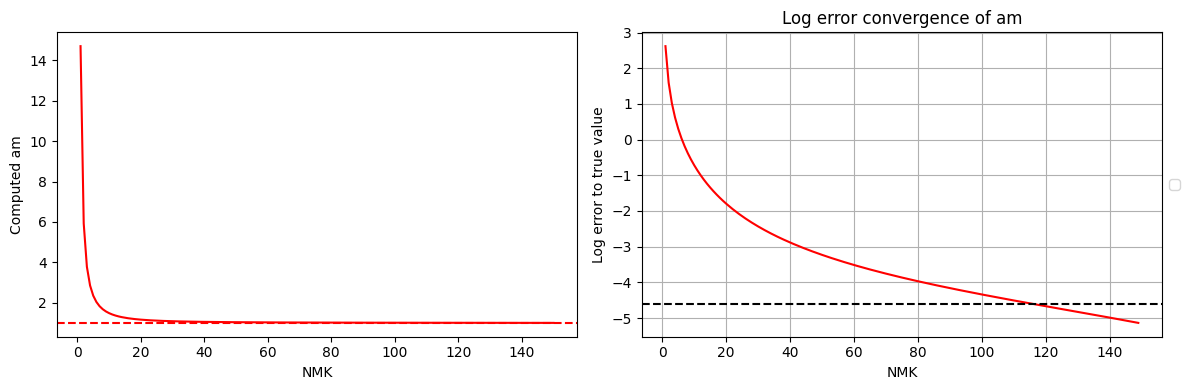

In [49]:
data = [all_prob_sets[1][1]]
formatted_data = many_data_dicts_to_convergence_plot_data(data)
plot_set_convergence_and_log(formatted_data, "am", scale = True, show_error = True, trunc = 0, smooth = True)

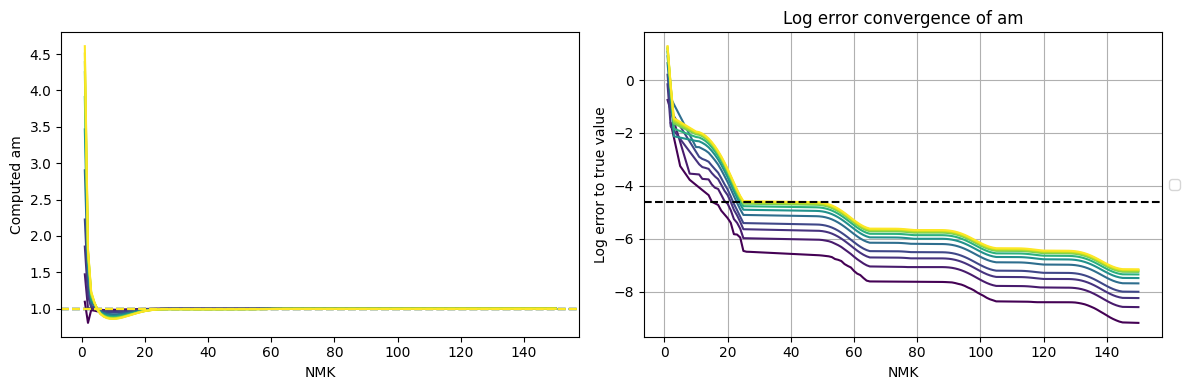

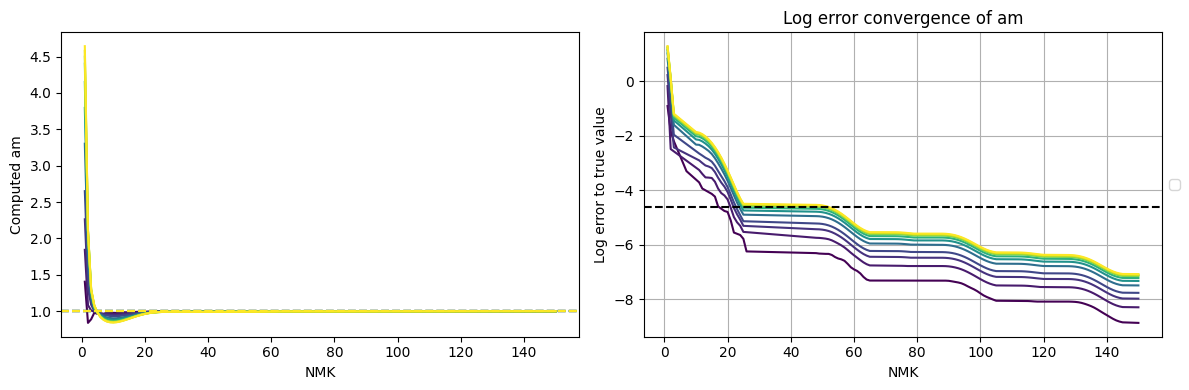

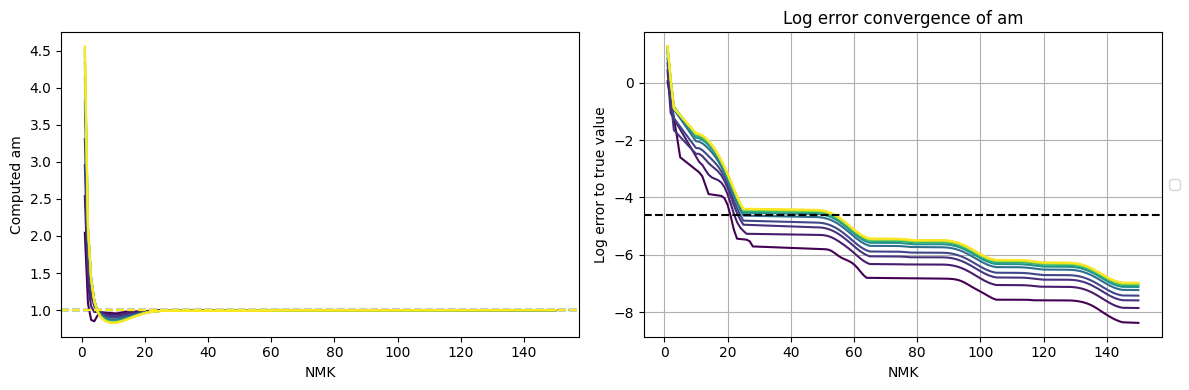

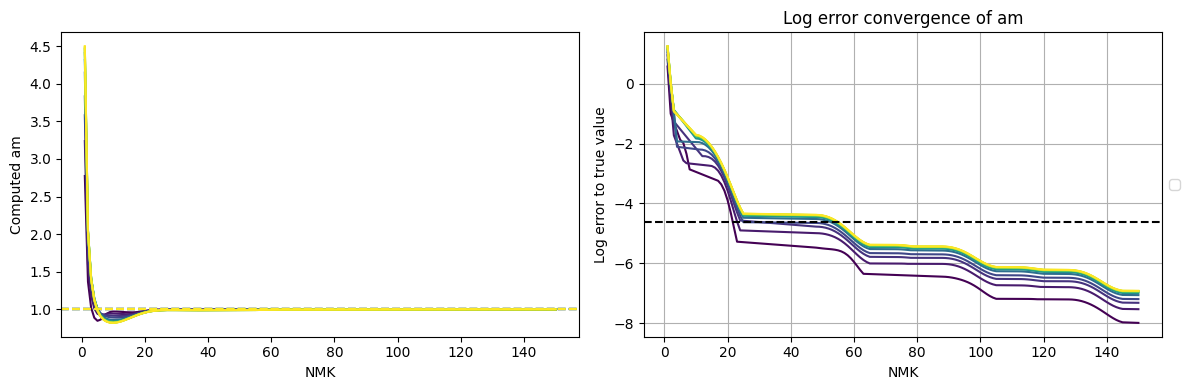

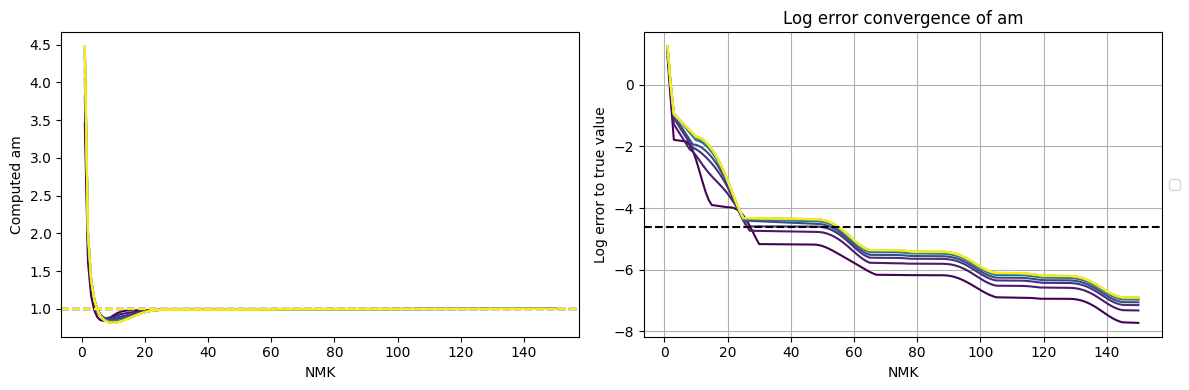

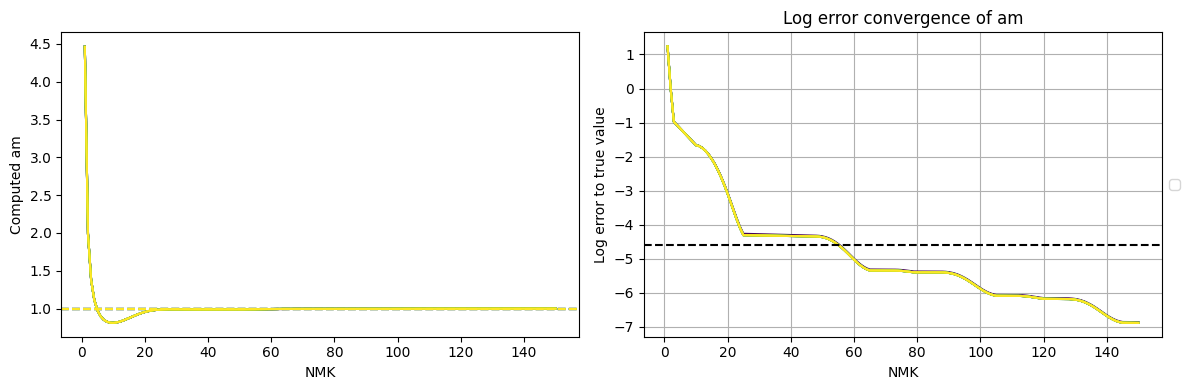

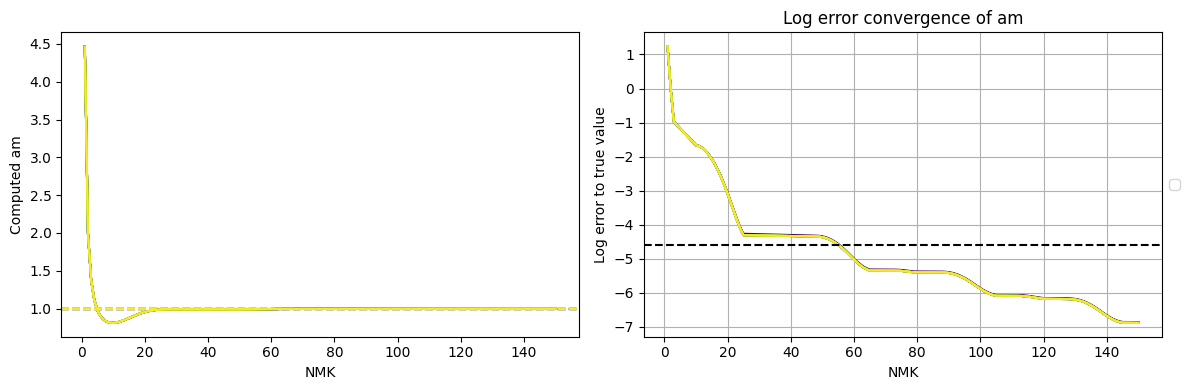

In [76]:
rr0_idx = 0
for rr1_idx in range(7):
  data = subdivide_lst(subdivide_lst(all_prob_sets[0], fs["rr0s"])[rr0_idx], fs["rr1s"])[rr1_idx]
  formatted_data = many_data_dicts_to_convergence_plot_data(data)
  colors = color_by_f_value(fs["rad1"], data, cmap = "viridis")
  plot_set_convergence_and_log(formatted_data, "am", colors = colors, scale = True, show_error = True, trunc = 0, smooth = True)

In [11]:
def hmd_diff(i, j, cf):
  return cf["d"][j] - cf["d"][i]

def rad_diff_out_mid(i, j, cf):
  r1 = cf["a"][i]
  r2_inner = cf["a"][j-1] if j > 0 else 0
  r2 = (cf["a"][j] - r2_inner)/2 + r2_inner
  return r2 - r1

def rad_diff_out_in(i, j, cf):
  r1 = cf["a"][i]
  r2_inner = cf["a"][j-1] if j > 0 else 0
  return r2_inner - r1

def rad_diff_out_out(i, j, cf):
  r1 = cf["a"][i]
  r2 = cf["a"][j]
  return r2 - r1

def tan_int(i, j, cf):
  numerator = hmd_diff(i, j, cf)
  r0 = cf["a"][i]
  r1 = cf["a"][j-1] if j > 0 else 0
  r2 = cf["a"][j]
  return numerator * np.log((r2 - r0)/(r1 - r0))

def tan_int_r(i, j, cf):
  numerator = hmd_diff(i, j, cf)
  r0 = cf["a"][i]
  r1 = cf["a"][j-1] if j > 0 else 0
  r2 = cf["a"][j]
  return numerator * (r2 - r1 + r0 * np.log((r2 - r0)/(r1 - r0)))

def rad_diff_in_in(i, j, cf):
  r1 = cf["a"][i-1] if j > 0 else 0
  r2 = cf["a"][j-1] if j > 0 else 0
  return r2 - r1

def tan_int_in(i, j, cf):
  numerator = hmd_diff(i, j, cf)
  r0 = cf["a"][i-1] if j > 0 else 0
  r1 = cf["a"][j-1] if j > 0 else 0
  r2 = cf["a"][j]
  return numerator * np.log((r2 - r0)/(r1 - r0))

def tan_int_r_in(i, j, cf):
  numerator = hmd_diff(i, j, cf)
  r0 = cf["a"][i-1] if j > 0 else 0
  r1 = cf["a"][j-1] if j > 0 else 0
  r2 = cf["a"][j]
  return numerator * (r2 - r1 + r0 * np.log((r2 - r0)/(r1 - r0)))

rel_fs = {# "(d2 - d0)" : lambda cf, m0 : hmd_diff(0, 2, cf),
          # "(a2 - a0) mid" : lambda cf, m0 : rad_diff_out_mid(0, 2, cf),
          # "(a2 - a0) in" : lambda cf, m0 : rad_diff_out_in(0, 2, cf),
          # "(a2 - a0) out" : lambda cf, m0 : rad_diff_out_out(0, 2, cf),
          "tan(mid)" : lambda cf, m0 : hmd_diff(0, 2, cf)/rad_diff_out_mid(0, 2, cf),
          "tan(in)" : lambda cf, m0 : hmd_diff(0, 2, cf)/rad_diff_out_in(0, 2, cf),
          "tan(out)" : lambda cf, m0 : hmd_diff(0, 2, cf)/rad_diff_out_out(0, 2, cf),
          "angle mid" : lambda cf, m0 : np.atan(hmd_diff(0, 2, cf)/rad_diff_out_mid(0, 2, cf)),
          "angle in" : lambda cf, m0 : np.atan(hmd_diff(0, 2, cf)/rad_diff_out_in(0, 2, cf)),
          "angle out" : lambda cf, m0 : np.atan(hmd_diff(0, 2, cf)/rad_diff_out_out(0, 2, cf)),
          "tan int" : lambda cf, m0 : tan_int(0, 2, cf),
          "tan int r" : lambda cf, m0 : tan_int_r(0, 2, cf),
          "tan(in-in)" : lambda cf, m0 : hmd_diff(0, 2, cf)/rad_diff_in_in(0, 2, cf),
          "tan int in" : lambda cf, m0 : tan_int_in(0, 2, cf),
          "tan int r in" : lambda cf, m0 : tan_int_r_in(0, 2, cf),}

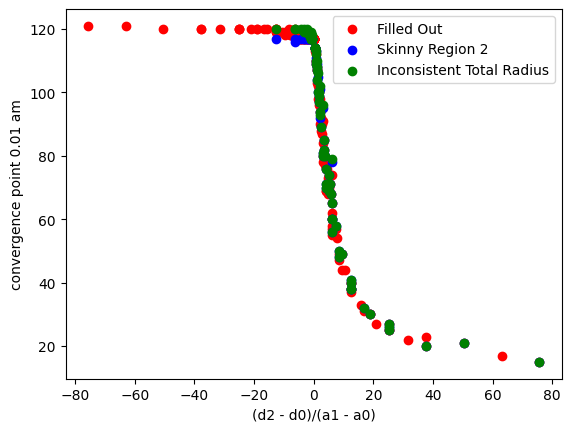

In [24]:
all_prob_sets_1 = open_pkl_file(file1)
for subset in all_prob_sets_1:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

all_prob_sets_2 = open_pkl_file(file2)
for subset in all_prob_sets_2:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

rr0_idx = 1
data1 = subdivide_lst(all_prob_sets_1[2], fs["rr0s"])[rr0_idx]
data2 = subdivide_lst(all_prob_sets_2[0], fs["rr0s"])[rr0_idx]
data3 = subdivide_lst(all_prob_sets_2[2], fs["rr0s"])[rr0_idx]

x_func = lambda cf, m0 : hmd_diff(1, 2, cf)/rad_diff_out_in(0, 2, cf)

all_xs = []
all_ams = []
for data in [data1, data2, data3]:
  all_xs.append([x_func(cf, cf["m0s"][0]) for cf in data])
  all_ams.append([cf[cf["m0s"][0]]["convergence point 0.01 am"] for cf in data])

labels = ["Filled Out","Skinny Region 2", "Inconsistent Total Radius"]
colors = ["Red", "Blue", "Green"]
for i in range(3):
  plt.scatter(all_xs[i], all_ams[i], color = colors[i], label = labels[i])
plt.xlabel("(d2 - d0)/(a1 - a0)")
plt.ylabel("convergence point 0.01 am")
plt.legend()
plt.show()


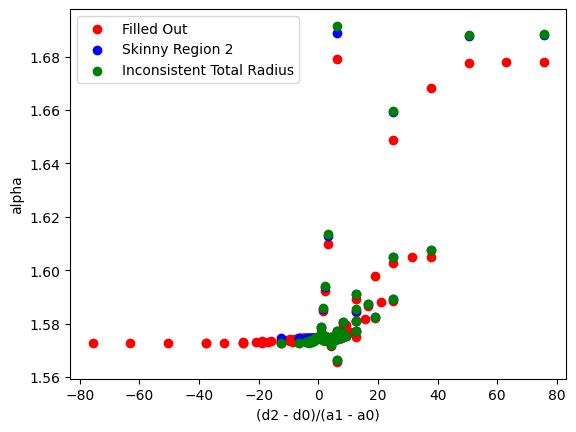

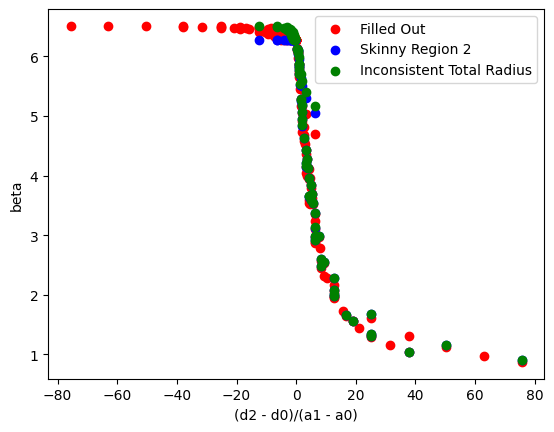

In [22]:
all_prob_sets_1 = open_pkl_file(file1)
for subset in all_prob_sets_1:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

all_prob_sets_2 = open_pkl_file(file2)
for subset in all_prob_sets_2:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

def f1(x, a1, a2):
  return - a1 * np.log(x/a2)

def fit_vals(f, cf, m0):
  xs = list(range(1, 151))
  ys = [cf[m0]["log errors am"][i] for i in range(150)]
  popt, pcov = curve_fit(f, xs, ys, p0=(1, 1))
  return popt

y_funcs = {"exponent" : lambda cf, m0 : fit_vals(f1, cf, m0)[0],
           "denominator" : lambda cf, m0 : fit_vals(f1, cf, m0)[1]}

x_func = lambda cf, m0 : hmd_diff(1, 2, cf)/rad_diff_out_in(0, 2, cf)

rr0_idx = 1
data1 = subdivide_lst(all_prob_sets_1[2], fs["rr0s"])[rr0_idx]
data2 = subdivide_lst(all_prob_sets_2[0], fs["rr0s"])[rr0_idx]
data3 = subdivide_lst(all_prob_sets_2[2], fs["rr0s"])[rr0_idx]

all_xs = []
all_alphas = []
all_betas = []
for data in [data1, data2, data3]:
  all_xs.append([x_func(cf, cf["m0s"][0]) for cf in data])
  all_alphas.append([y_funcs["exponent"](cf, cf["m0s"][0]) for cf in data])
  all_betas.append([y_funcs["denominator"](cf, cf["m0s"][0]) for cf in data])

labels = ["Filled Out","Skinny Region 2", "Inconsistent Total Radius"]
colors = ["Red", "Blue", "Green"]
for i in range(3):
  plt.scatter(all_xs[i], all_alphas[i], color = colors[i], label = labels[i])
plt.xlabel("(d2 - d0)/(a1 - a0)")
plt.ylabel("alpha")
plt.legend()
plt.show()

for i in range(3):
  plt.scatter(all_xs[i], all_betas[i], color = colors[i], label = labels[i])
plt.xlabel("(d2 - d0)/(a1 - a0)")
plt.ylabel("beta")
plt.legend()
plt.show()
  

In [17]:
rr0_idx = 1
data = subdivide_lst(all_prob_sets[0], fs["rr0s"])[rr0_idx]

def f1(x, a1, a2):
  return - a1 * np.log(x/a2)

def f2(x, a1, a2):
  return - a1 * np.log(x) + np.log(a2)

def fit_vals(f, cf, m0):
  xs = list(range(1, 151))
  ys = [cf[m0]["log errors am"][i] for i in range(150)]
  popt, pcov = curve_fit(f, xs, ys, p0=(1, 1))
  return popt


data = subdivide_lst(all_prob_sets[0], fs["rr0s"])[rr0_idx]
y_funcs = {"alpha" : lambda cf, m0 : fit_vals(f1, cf, m0)[0],
           "beta" : lambda cf, m0 : fit_vals(f1, cf, m0)[1]} #,
           # "added const" : lambda cf, m0 : fit_vals(f2, cf, m0)[1]}
  
# plot_relation_grid(data, rel_fs, y_funcs)


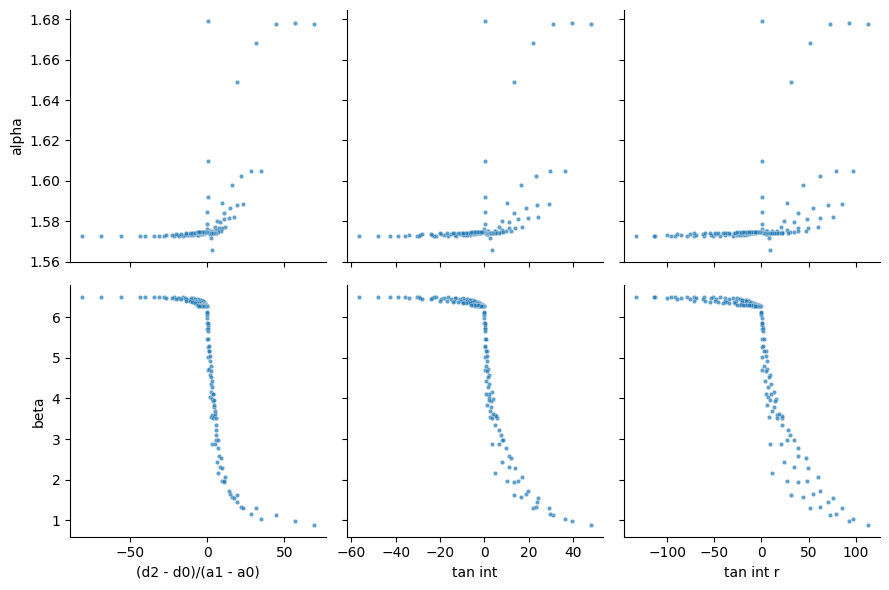

In [21]:
all_prob_sets = open_pkl_file(file1)
for subset in all_prob_sets:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

rr0_idx = 1
x_funcs = {"(d2 - d0)/(a1 - a0)" : lambda cf, m0 : hmd_diff(0, 2, cf)/rad_diff_out_in(0, 2, cf),
           "tan int" : lambda cf, m0 : tan_int(0, 2, cf),
           "tan int r" : lambda cf, m0 : tan_int_r(0, 2, cf)}
data = subdivide_lst(all_prob_sets[2], fs["rr0s"])[rr0_idx]
plot_relation_grid(data, x_funcs, y_funcs)

In [ ]:
####################### BREAK LINE

In [ ]:
####################### BREAK LINE

[11, 11, 11, 11, 11]
[12, 12, 12, 12, 12]
[15, 15, 15, 15, 15]
[11, 11, 11, 11, 11]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[26, 26, 26, 26, 26]
[30, 30, 30, 30, 30]
[30, 30, 30, 30, 30]
[30, 30, 30, 30, 30]
[31, 31, 31, 31, 31]
[31, 31, 31, 31, 31]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[26, 26, 26, 26, 26]
[35, 35, 35, 35, 35]
[41, 41, 41, 41, 41]
[44, 44, 44, 44, 45]


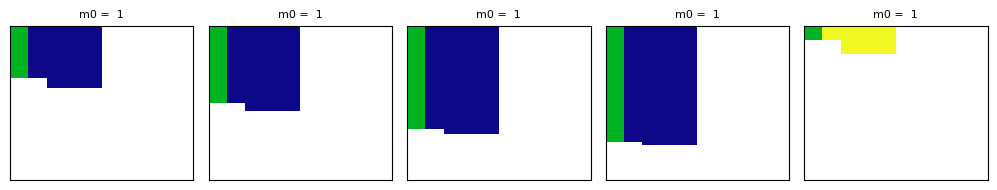

[51, 51, 51, 51, 52]


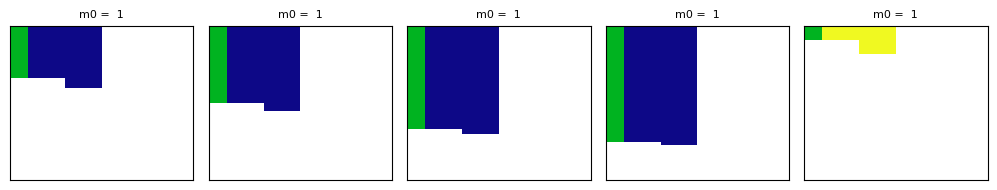

[54, 54, 54, 54, 55]


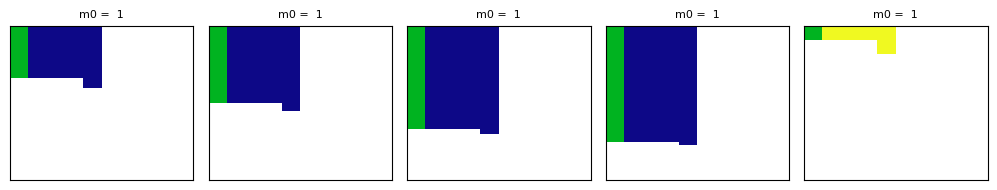

[58, 58, 58, 58, 59]


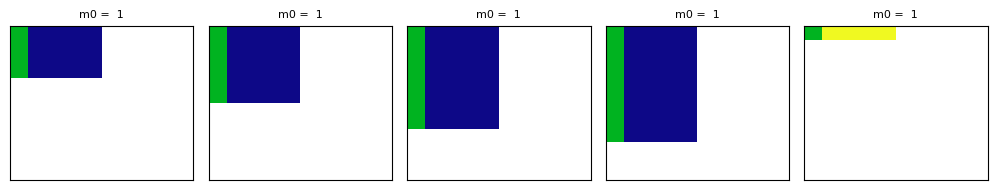

[58, 58, 58, 58, 59]


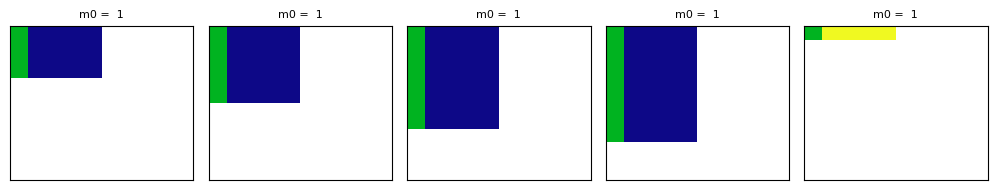

[58, 58, 58, 58, 59]


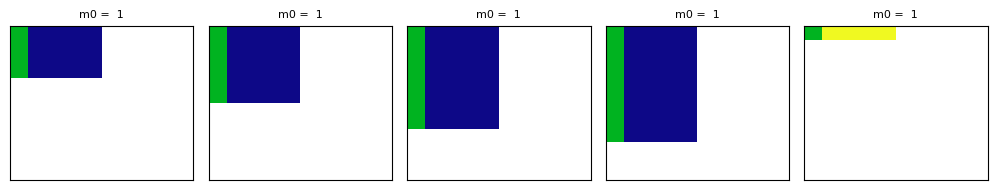

[59, 59, 59, 59, 60]


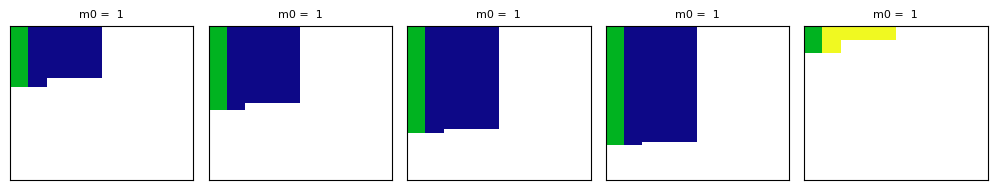

[58, 58, 59, 59, 59]


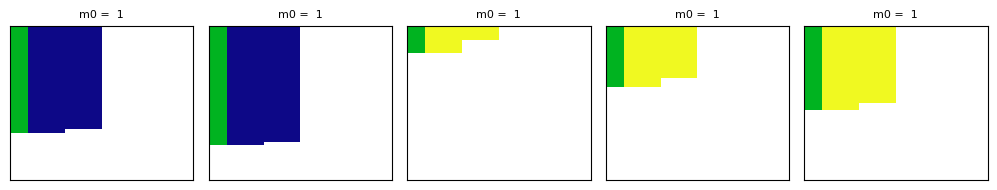

[58, 58, 58, 58, 59]


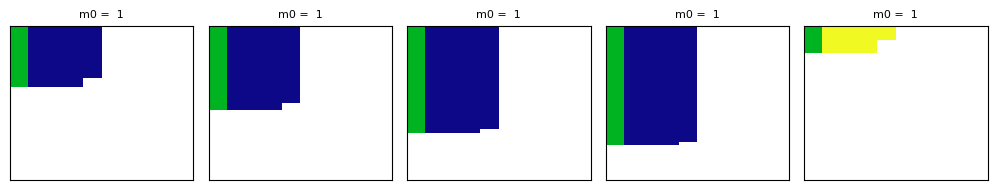

[59, 59, 59, 60, 60]


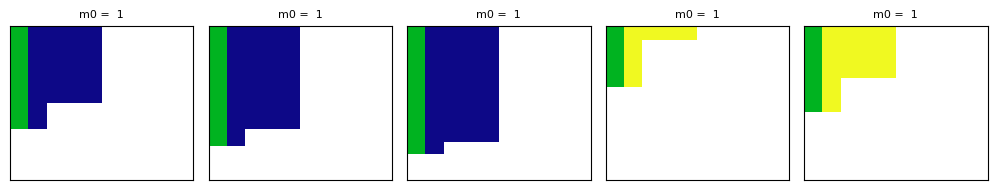

[58, 58, 59, 59, 59]


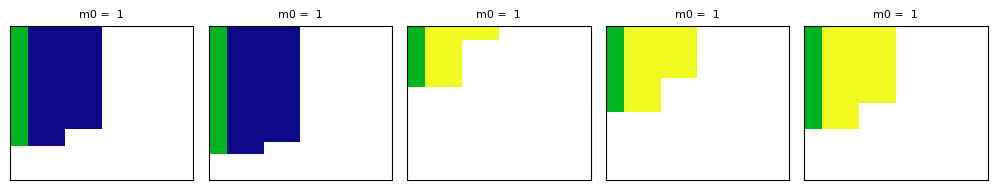

[58, 58, 58, 58, 58]
[34, 34, 34, 34, 34]
[55, 55, 55, 55, 55]
[72, 72, 72, 72, 72]
[98, 99, 99, 99, 99]


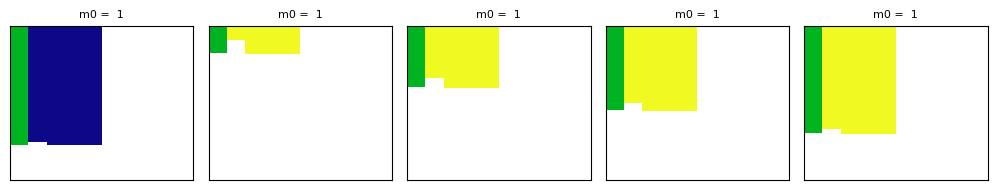

[109, 109, 109, 110, 110]


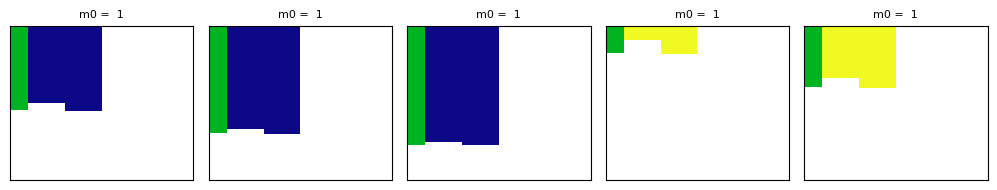

[114, 114, 114, 114, 115]


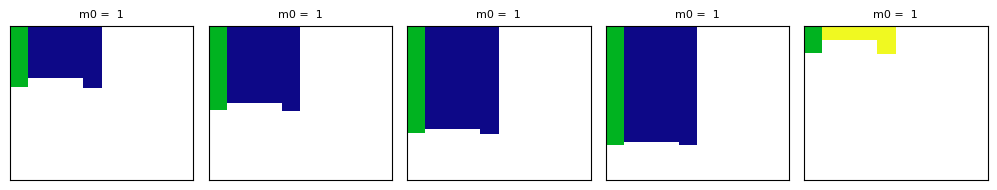

[120, 120, 120, 121, 122]


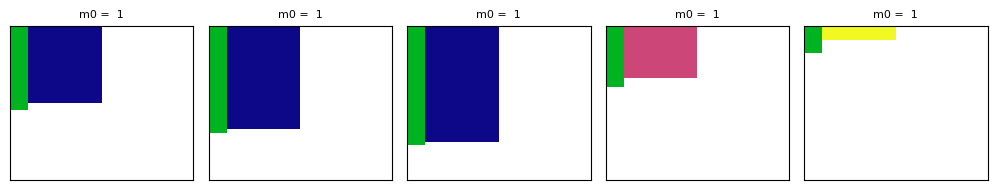

[120, 120, 120, 121, 122]


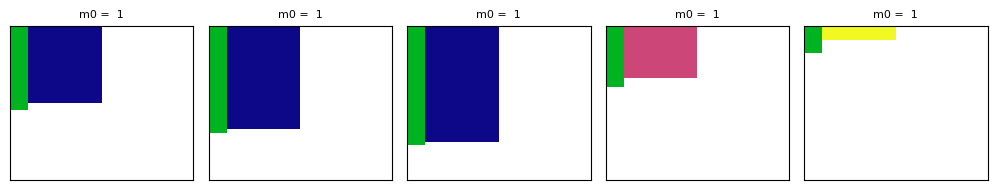

[120, 120, 120, 121, 122]


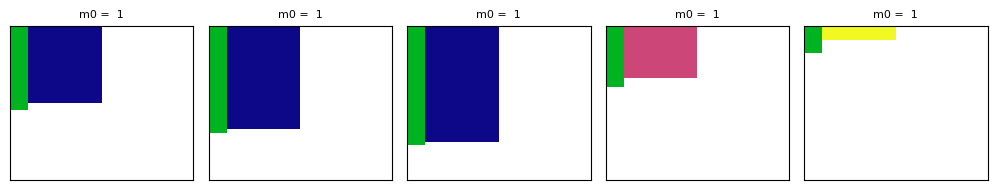

[121, 121, 121, 121, 122]


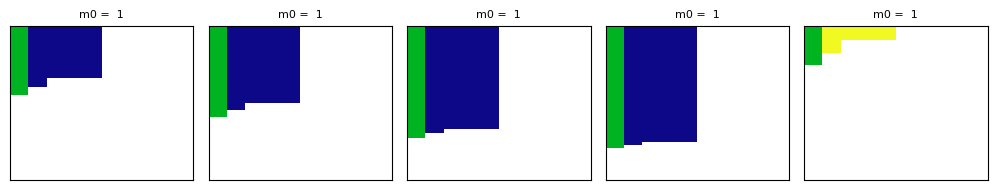

[121, 121, 121, 121, 122]


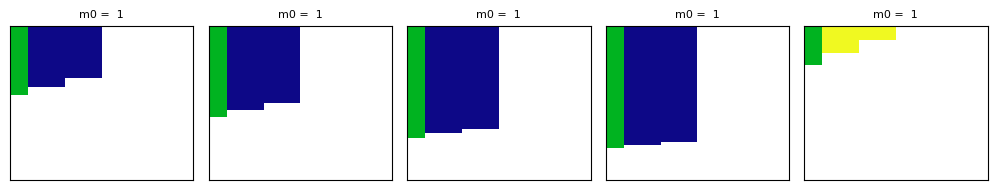

[120, 120, 121, 121, 122]


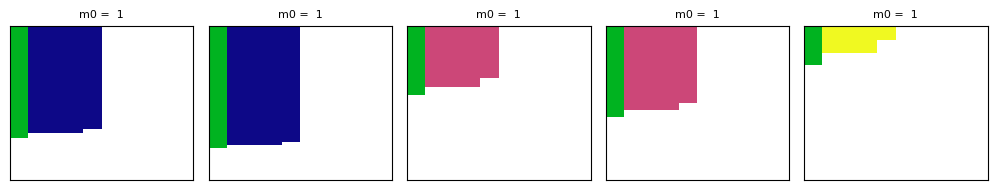

[121, 121, 121, 121, 122]


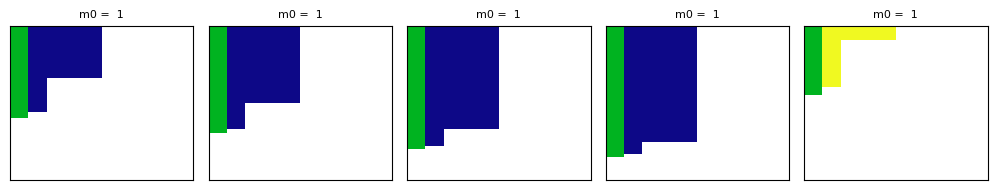

[121, 121, 121, 121, 121]
[120, 120, 120, 121, 121]


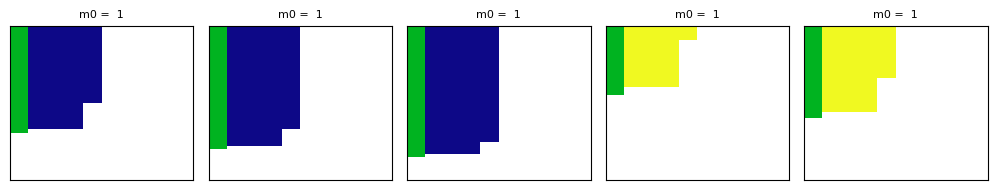

[48, 48, 48, 49, 49]


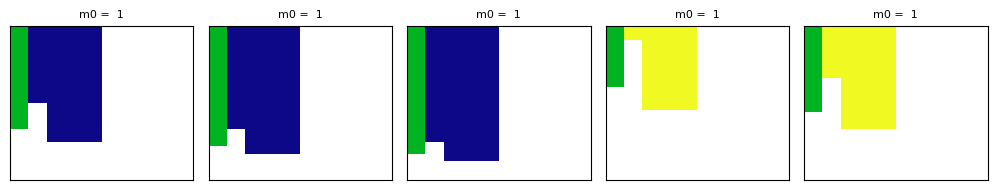

[78, 78, 78, 78, 78]
[98, 98, 98, 98, 98]
[132, 132, 132, 132, 133]


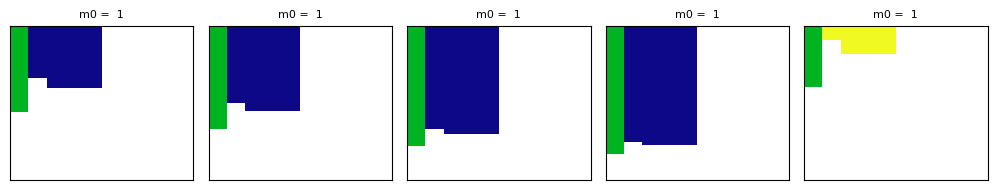

[132, 132, 132, 132, 133]


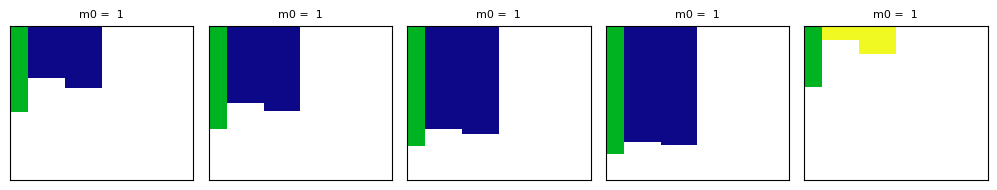

[132, 132, 132, 132, 133]


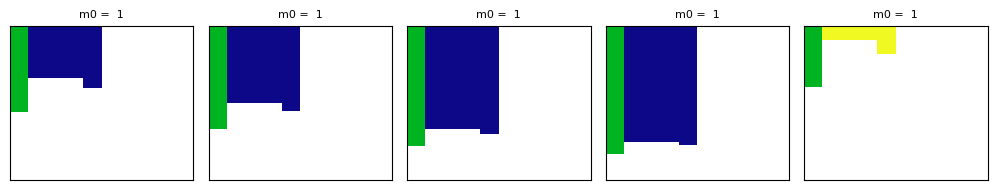

[132, 132, 132, 132, 133]


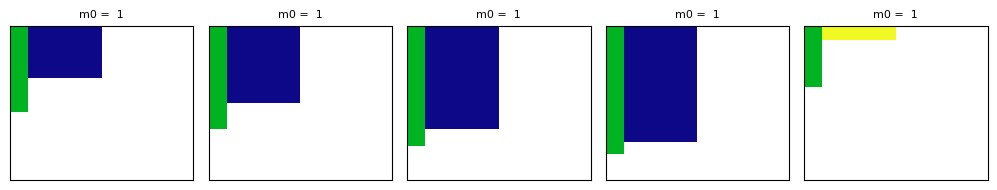

[132, 132, 132, 132, 133]


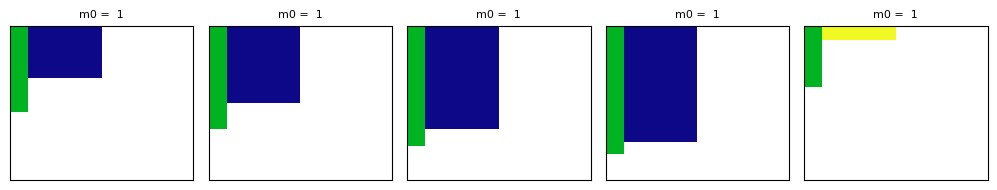

[132, 132, 132, 132, 133]


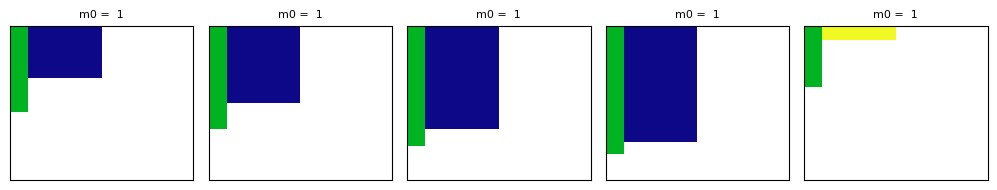

[132, 132, 132, 132, 133]


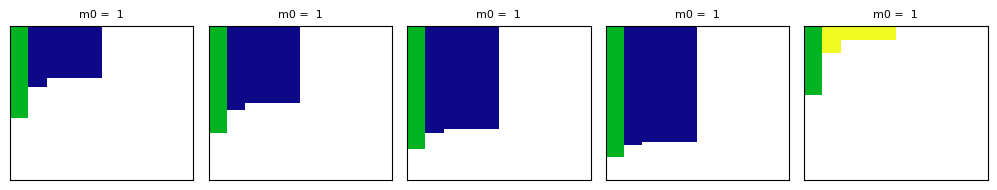

[132, 132, 132, 132, 133]


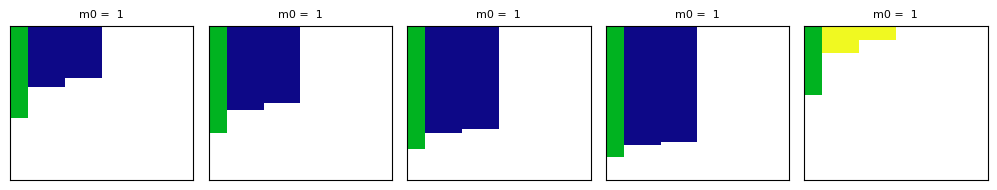

[132, 132, 132, 132, 133]


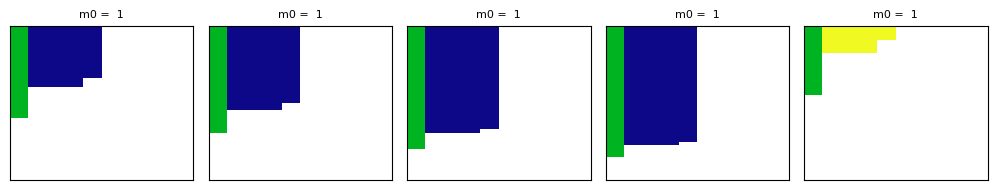

[132, 132, 132, 132, 132]
[132, 132, 132, 132, 132]
[132, 132, 132, 132, 132]


In [ ]:
# am cp is basically independent of h, height ratio and therefore d, it's h-d that matters
for idx0 in range(5):
  for idx1 in range(5):
    for idx2 in range(3):
      data = subdivide_lst(subdivide_lst(subdivide_lst(all_prob_sets[0], fs["rr0s"])[idx0], fs["rr1s"])[idx1], fs["rad1"])[idx2]
      labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in data]
      labels.sort()
      print(labels)
      if labels[-1] != labels[0]:
        plot_varied_cases([data], 0, "am")



0.5


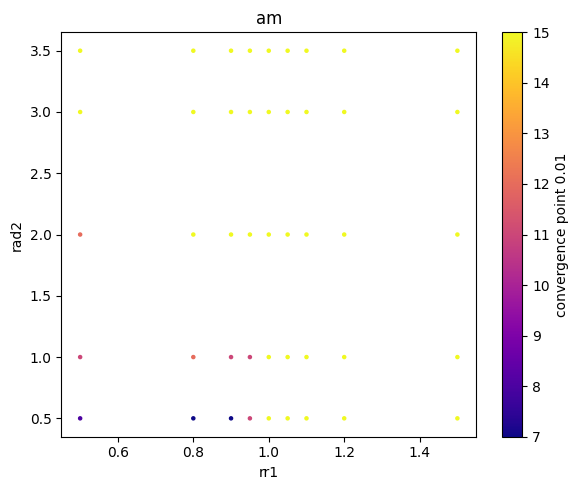

0.8


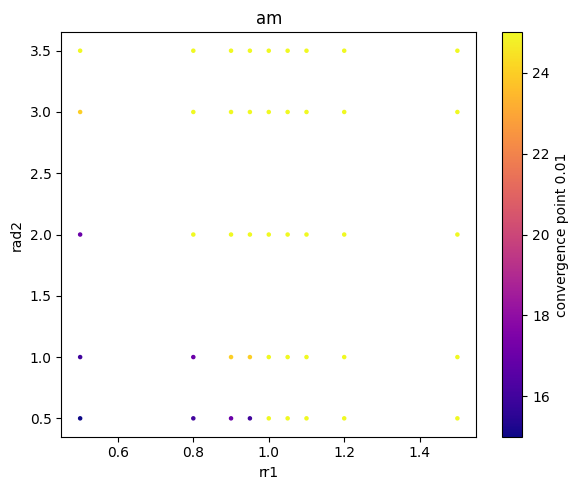

0.9


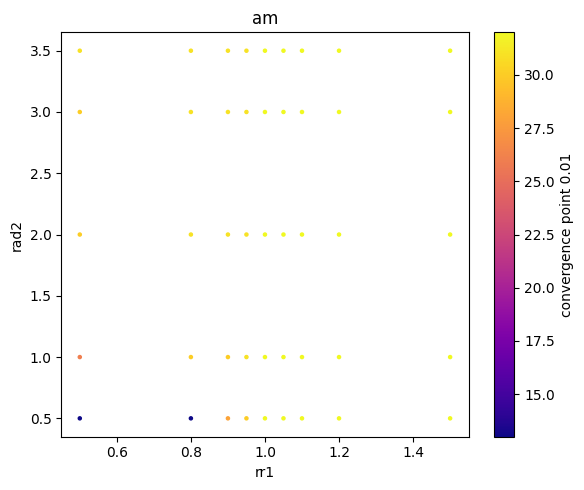

0.95


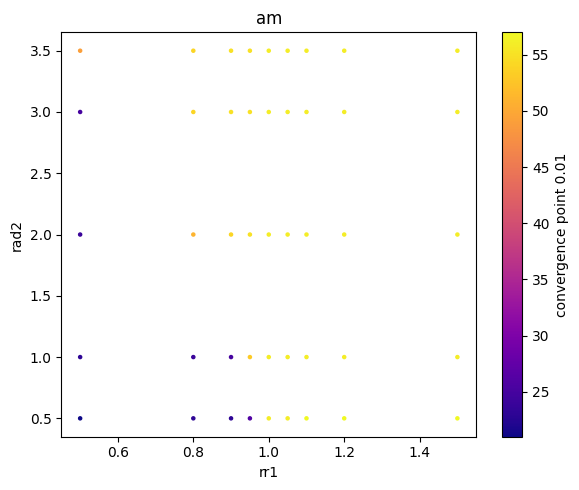

1.0


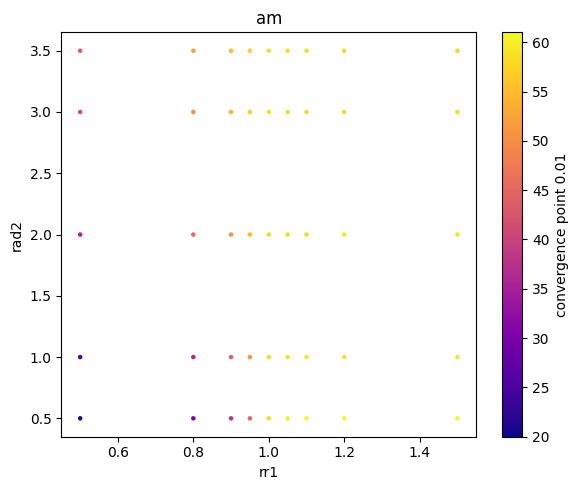

1.05


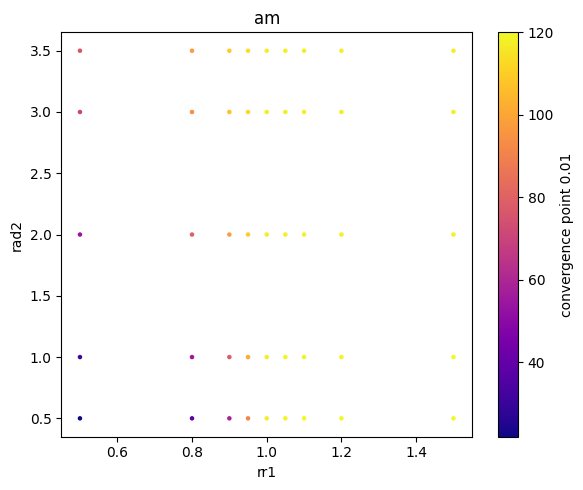

1.1


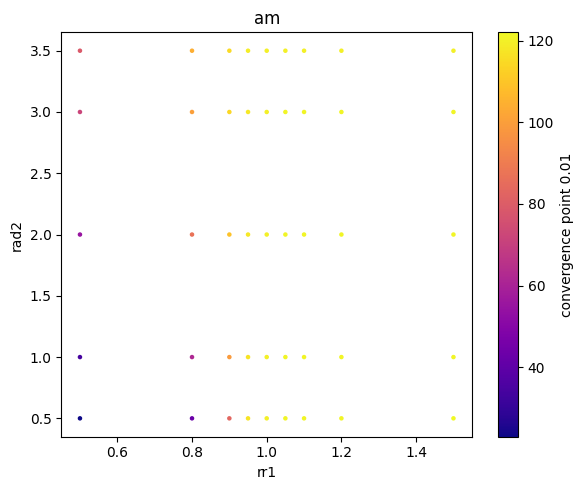

In [15]:
for idx in range(7):
  data = subdivide_lst(all_prob_sets[1], fs["rr0s"])[idx]
  print(fs["rr0s"](data[0], data[0]["m0s"][0]))
  plot_hydros_against_2(data, "am", 0.01, fs["rr1s"], fs["rad2"], "rr1", "rad2")

In [23]:
def cross_area(cf, m0):
  return dim1s["(h-d2)"](cf, m0) * dim1s["radwidth2"](cf, m0) + dim1s["(h-d1)"](cf, m0) * dim1s["radwidth1"](cf, m0)

def volume(cf, m0):
  vol2 = dim1s["(h-d2)"](cf, m0) *(cf["a"][2]**2 - cf["a"][1]**2)
  vol1 = dim1s["(h-d1)"](cf, m0) *(cf["a"][1]**2 - cf["a"][0]**2)
  return vol2 + vol1

theory_fs = {"cross area" : cross_area,
             "volume" : volume}

def plot_hydros_against_1(data, hydro, error, xfunc, xlabel = "X", ylabel = "Y", title = None):
  xs = [xfunc(config, m0) for config in data for m0 in config["m0s"]]
  ys = [config[m0][f"convergence point {error:2g} " + hydro] for config in data for m0 in config["m0s"]]
  plt.scatter(xs, ys)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)

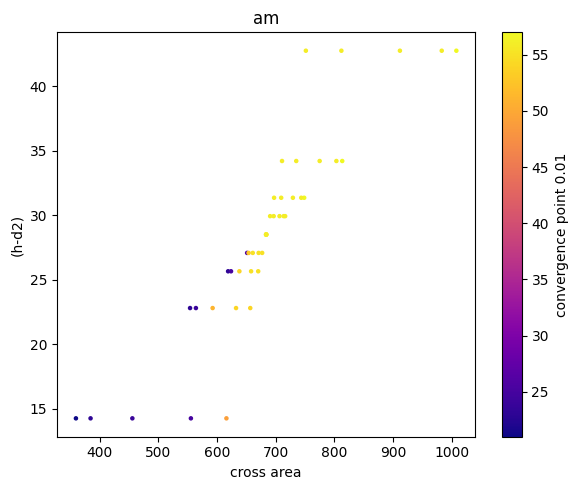

In [30]:
plot_hydros_against_2(data, "am", 0.01, theory_fs["volume"], dim1s["(h-d2)"], "cross area", "(h-d2)")

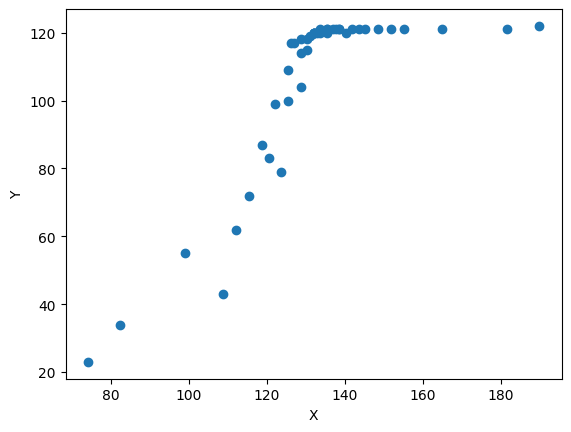

In [37]:
data = subdivide_lst(all_prob_sets[1], fs["rr0s"])[6]
plot_hydros_against_1(data, "am", 0.01, theory_fs["cross area"] )

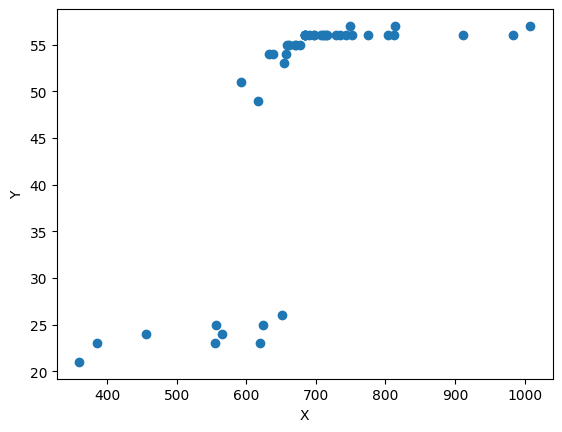

In [27]:
plot_hydros_against_1(data, "am", 0.01, theory_fs["volume"] )

[22, 33, 54, 70, 76]


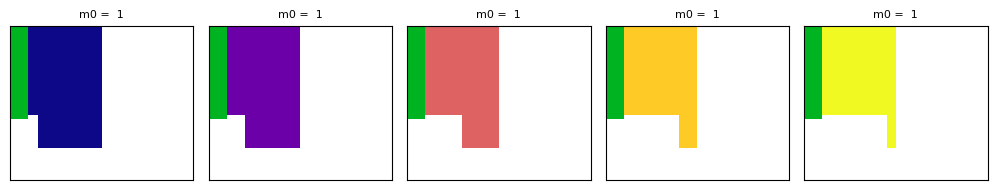

[38, 55, 80, 94, 98]


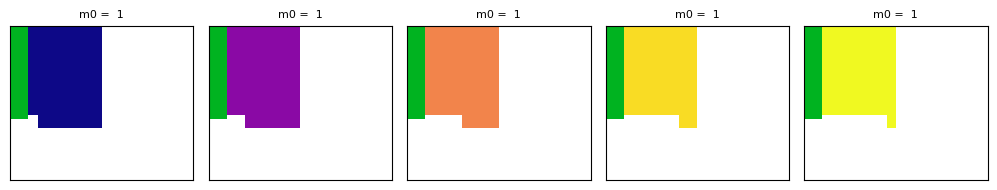

[58, 78, 98, 107, 109]


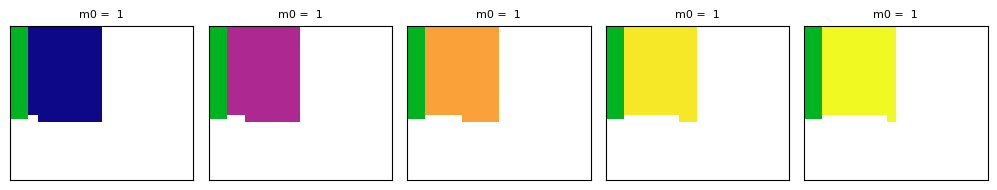

[91, 102, 110, 113, 114]


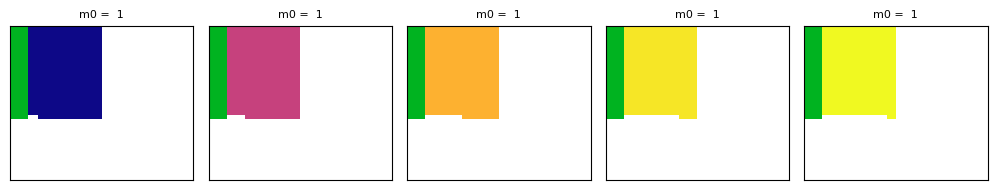

[117, 117, 117, 117, 117]
[117, 117, 118, 119, 119]


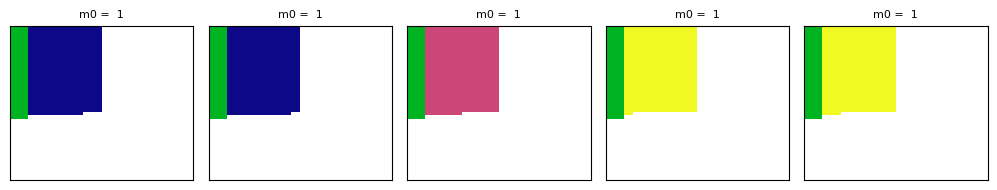

[117, 117, 118, 119, 120]


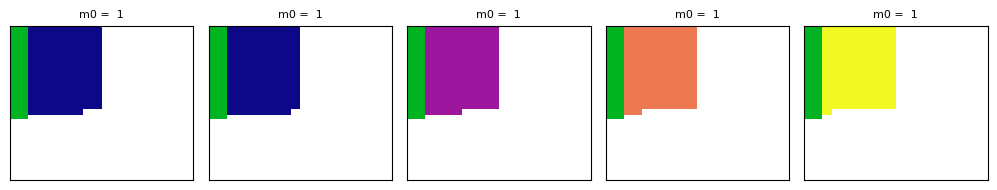

In [40]:
for jdx in range(7):
  data = subdivide_lst(subdivide_lst(all_prob_sets[1], fs["rr0s"])[5], fs["rr1s"])[jdx]
  labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in data]
  labels.sort()
  print(labels)
  if labels[-1] != labels[0]:
    plot_varied_cases([data], 0, "am")

[8, 11, 12, 15, 15]


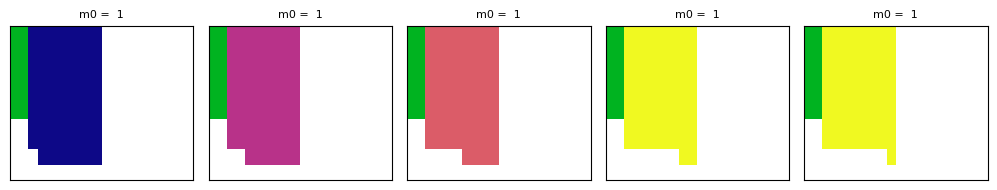

[7, 12, 15, 15, 15]


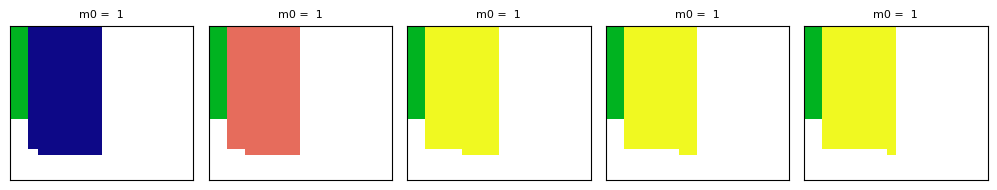

[7, 11, 15, 15, 15]


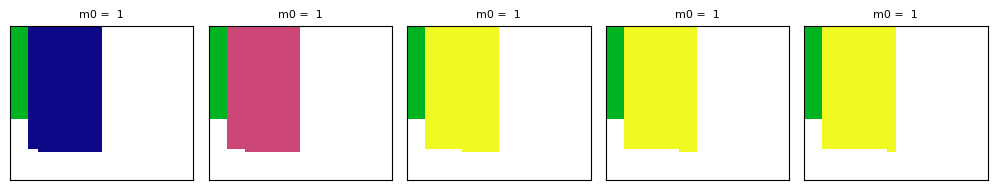

[11, 11, 15, 15, 15]


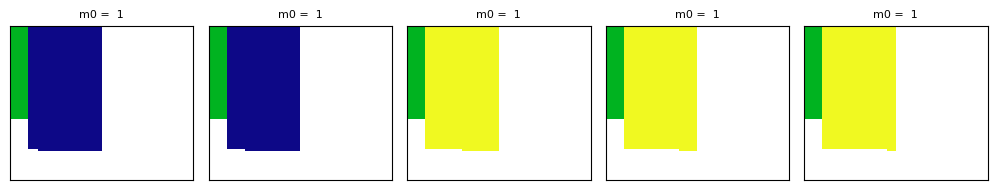

[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 15, 15, 15, 15]
[15, 16, 17, 24, 25]


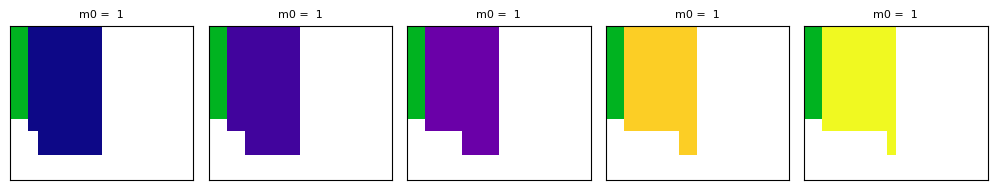

[16, 17, 25, 25, 25]


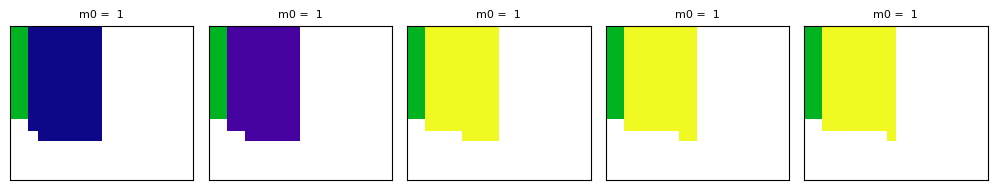

[17, 24, 25, 25, 25]


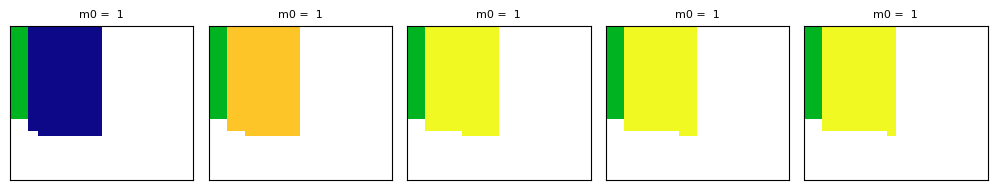

[16, 24, 25, 25, 25]


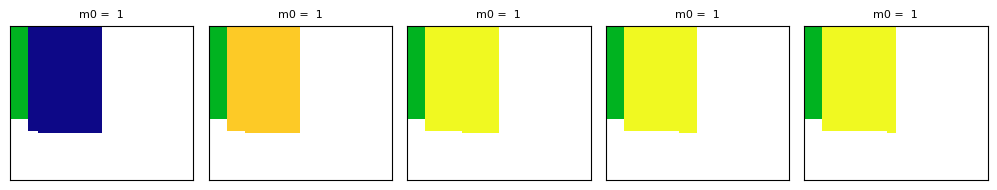

[25, 25, 25, 25, 25]
[25, 25, 25, 25, 25]
[25, 25, 25, 25, 25]
[13, 26, 30, 30, 31]


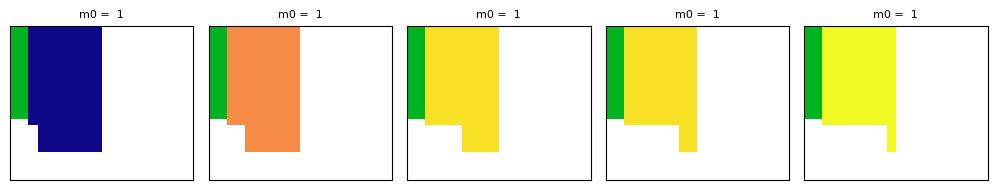

[13, 30, 31, 31, 31]


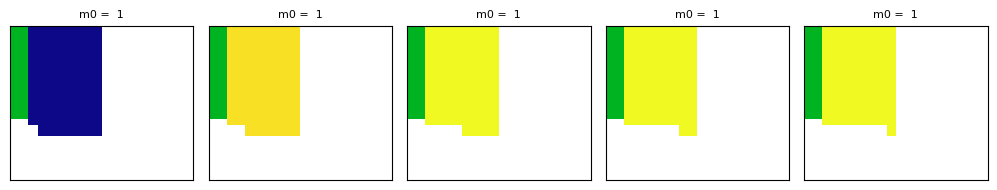

[28, 30, 31, 31, 31]


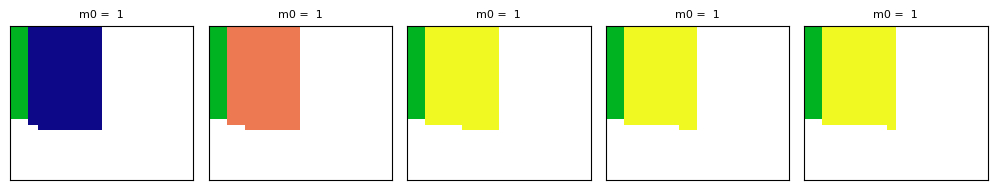

[30, 31, 31, 31, 31]


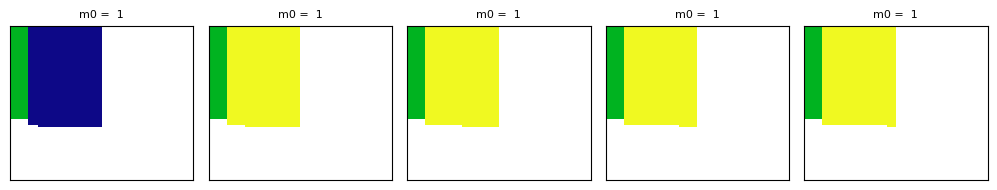

[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[32, 32, 32, 32, 32]
[21, 23, 24, 25, 49]


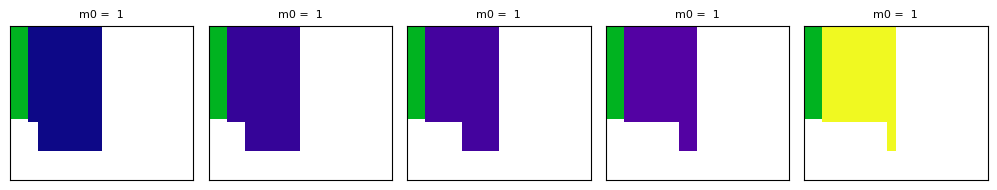

[23, 24, 51, 54, 54]


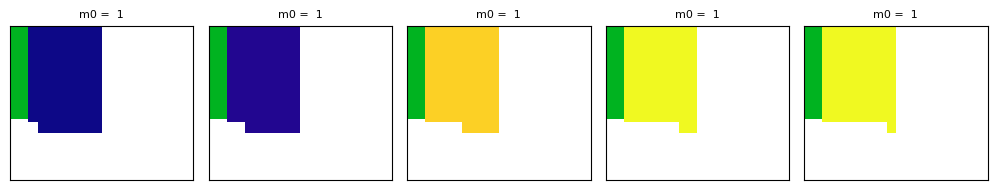

[23, 25, 54, 55, 55]


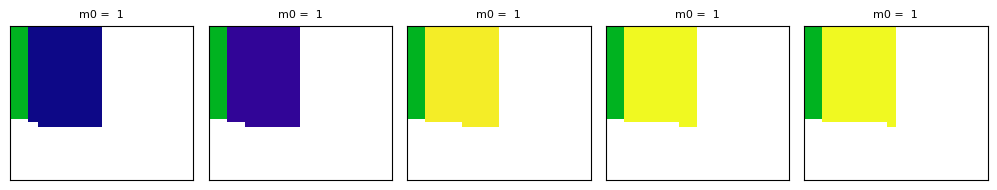

[26, 53, 55, 55, 55]


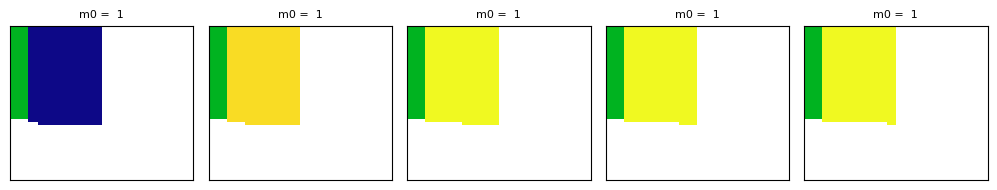

[56, 56, 56, 56, 56]
[56, 56, 56, 56, 56]
[56, 56, 56, 56, 57]


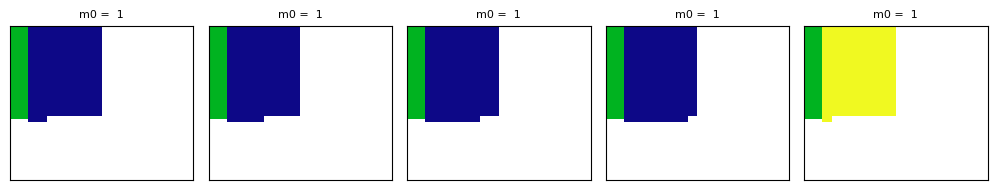

[20, 26, 35, 41, 44]


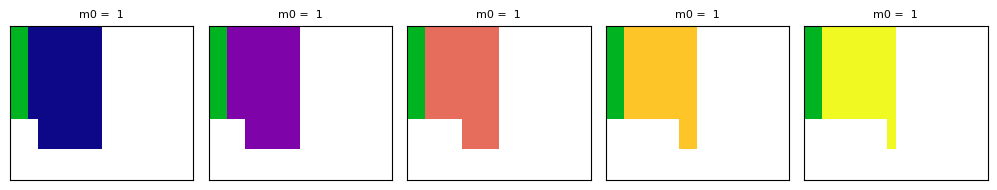

[30, 36, 45, 50, 52]


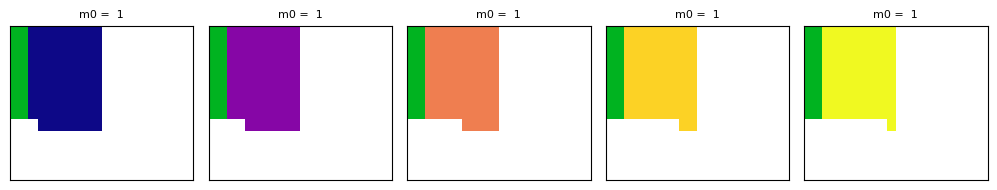

[38, 44, 51, 54, 55]


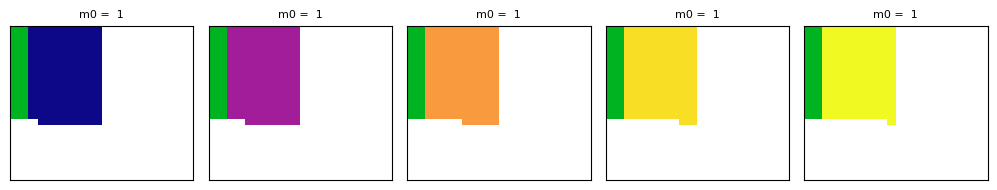

[45, 51, 55, 57, 57]


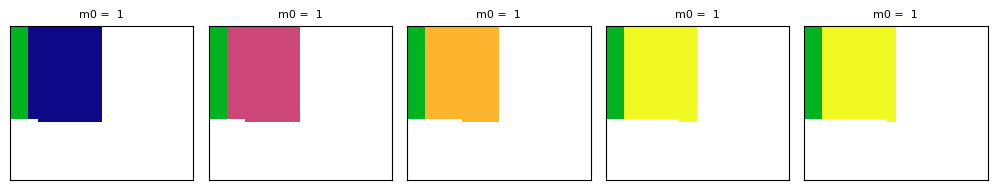

[58, 58, 58, 58, 58]
[58, 58, 58, 59, 60]


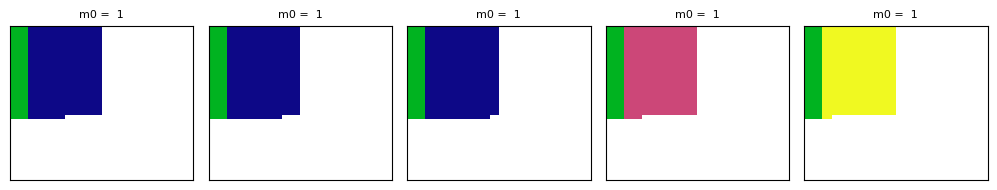

[58, 58, 58, 59, 61]


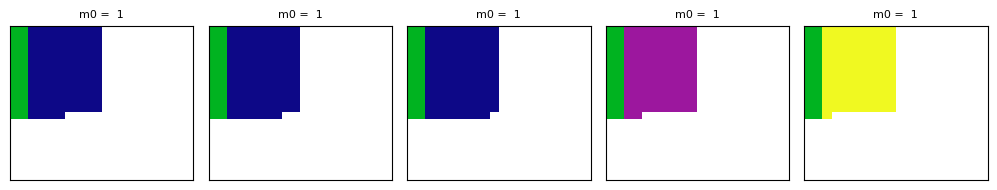

[22, 33, 54, 70, 76]


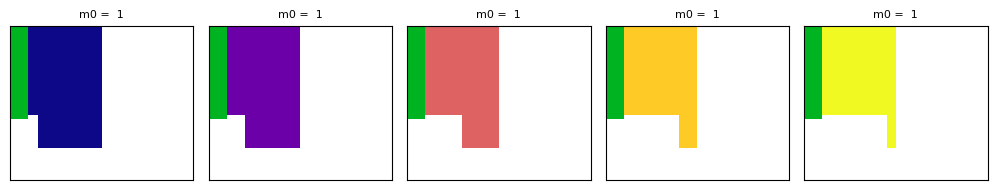

[38, 55, 80, 94, 98]


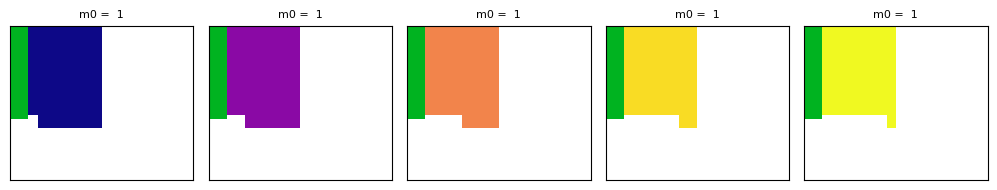

[58, 78, 98, 107, 109]


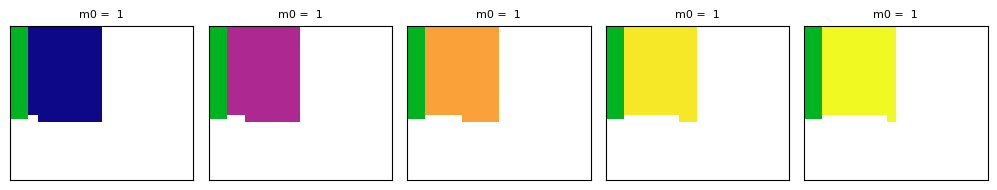

[91, 102, 110, 113, 114]


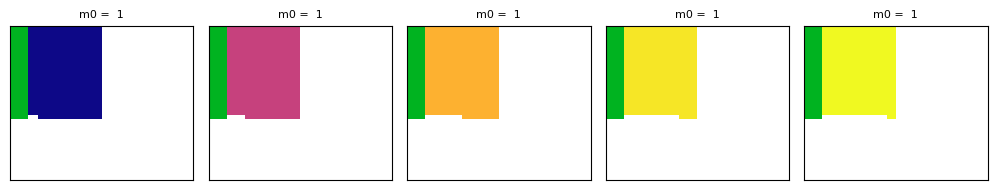

[117, 117, 117, 117, 117]
[117, 117, 118, 119, 119]


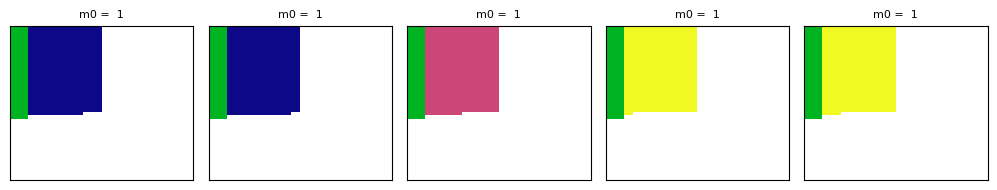

[117, 117, 118, 119, 120]


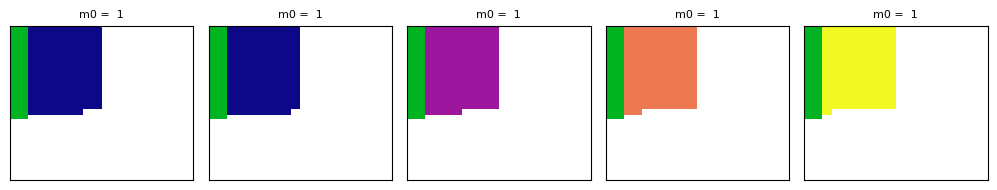

[23, 34, 55, 72, 79]


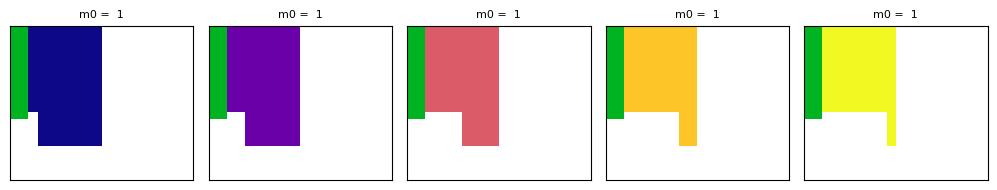

[43, 62, 87, 100, 104]


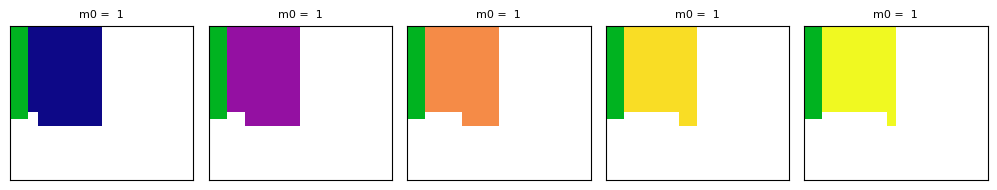

[83, 99, 109, 114, 115]


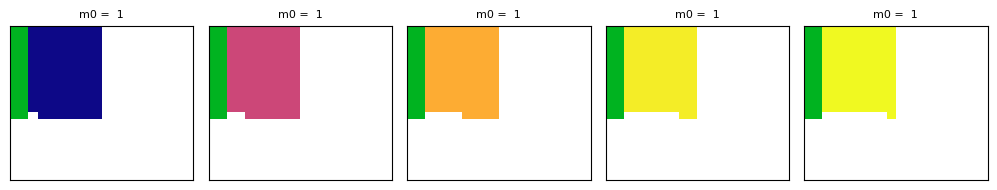

[117, 117, 118, 118, 119]


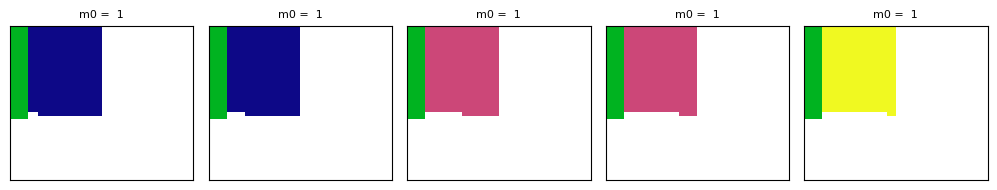

[120, 120, 120, 120, 120]
[120, 121, 121, 121, 121]


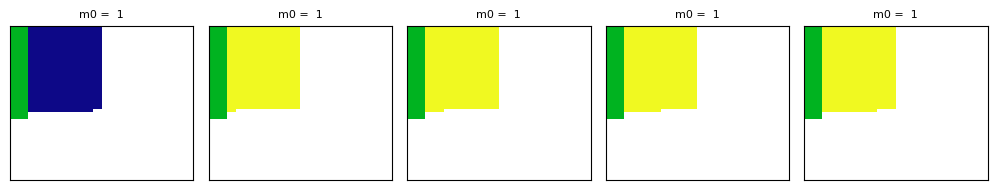

[120, 121, 121, 121, 121]


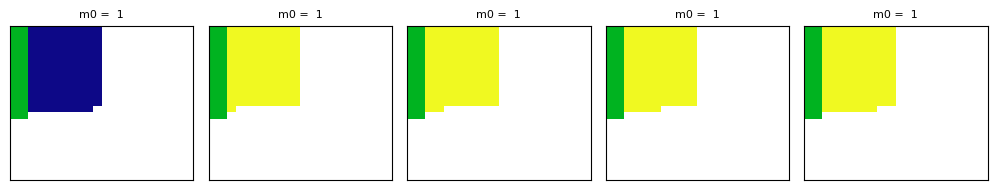

In [12]:
for idx in range(7):
  for jdx in range(7):
    data = subdivide_lst(subdivide_lst(all_prob_sets[1], fs["rr0s"])[idx], fs["rr1s"])[jdx]
    labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in data]
    labels.sort()
    print(labels)
    if labels[-1] != labels[0]:
      plot_varied_cases([data], 0, "am")

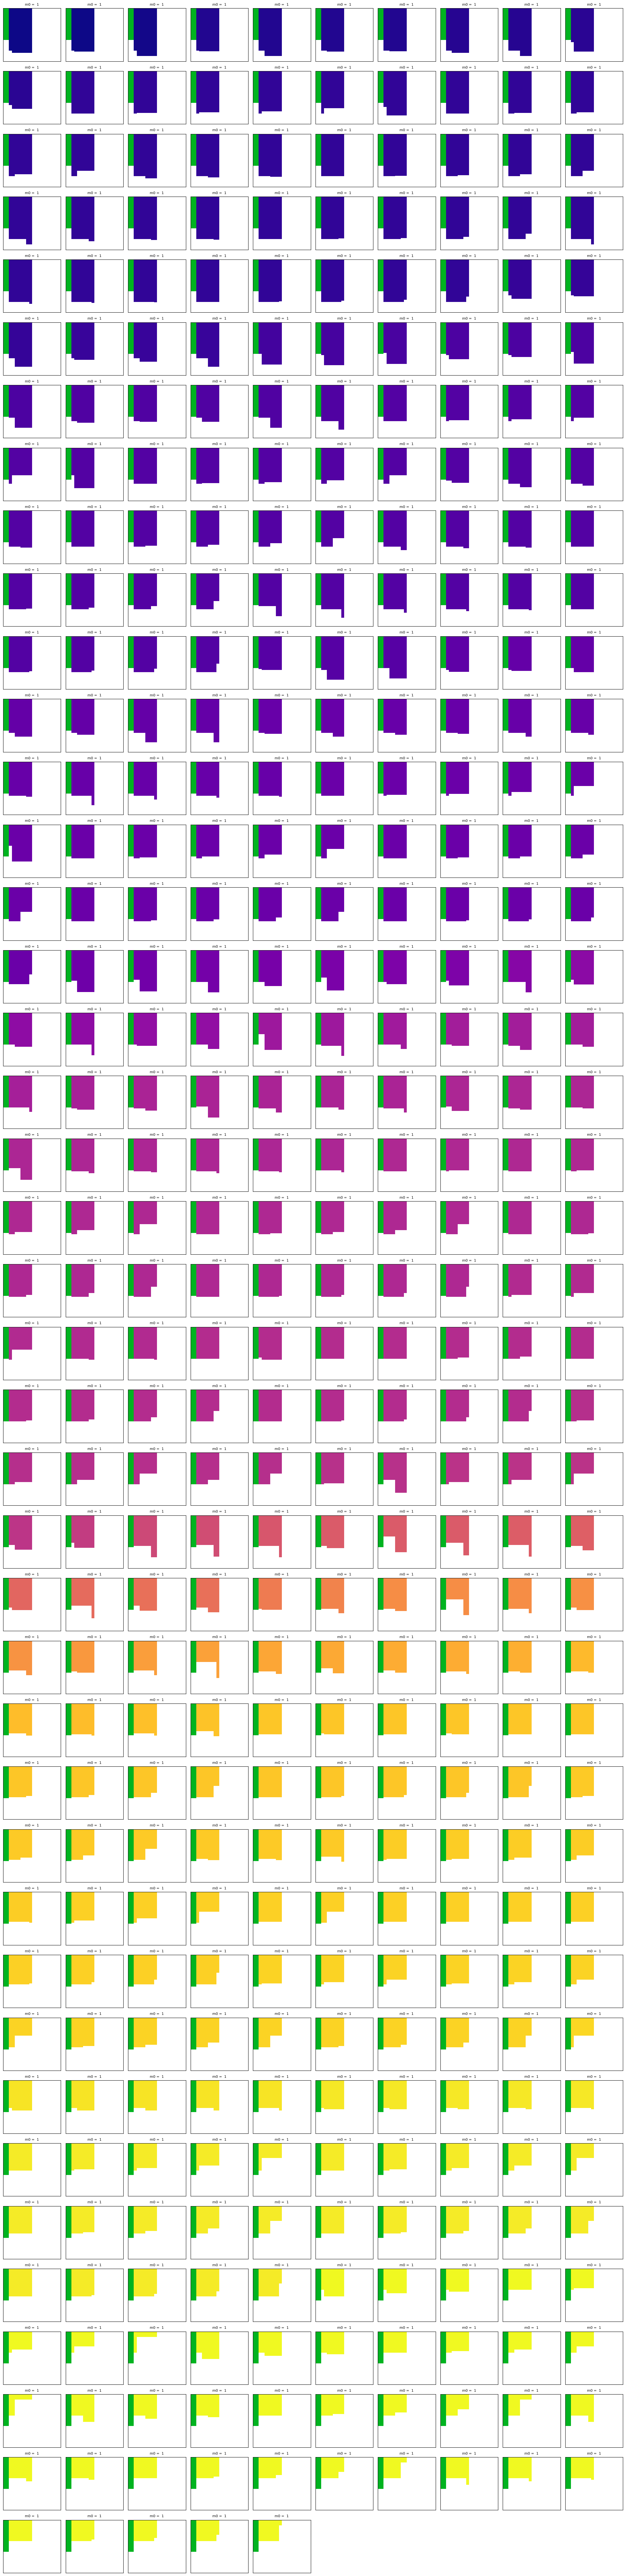

In [ ]:
plot_varied_cases(all_prob_sets, 1, "dp")

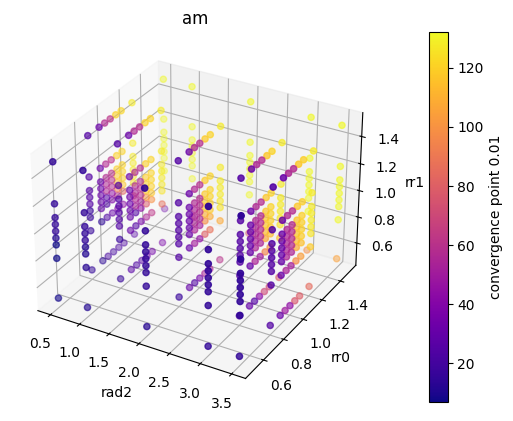

In [8]:
plot_hydros_against_3(all_prob_sets[1], "am", 0.01, fs["rad2"], fs["rr0s"], fs["rr1s"],
                      "rad2", "rr0", "rr1")

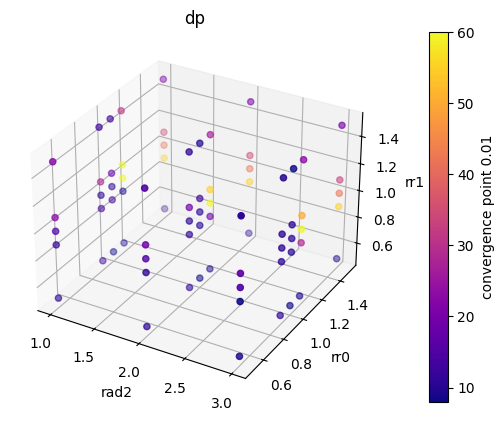

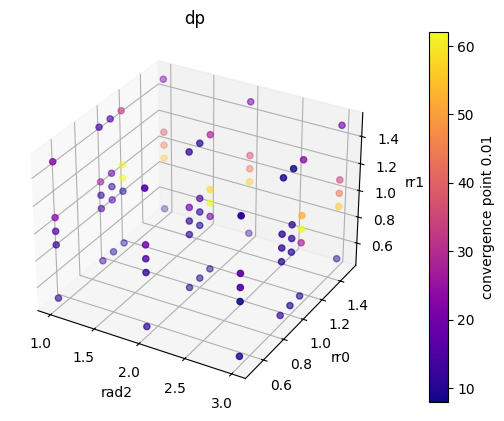

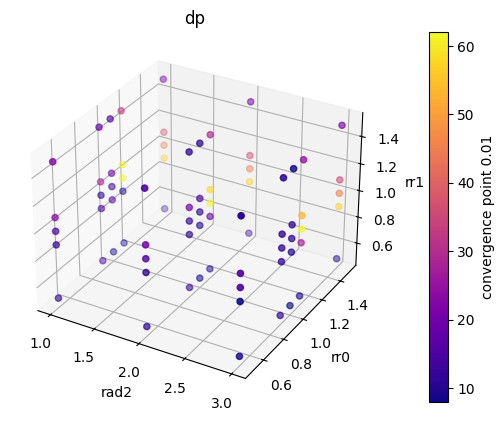

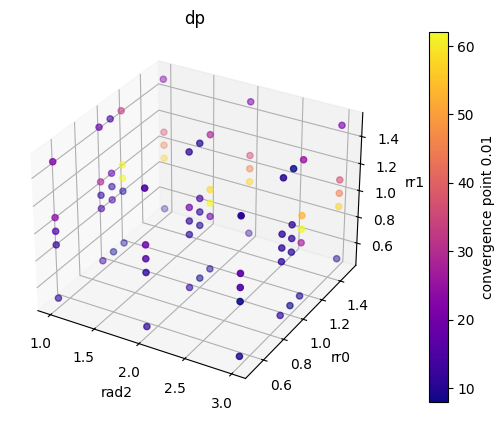

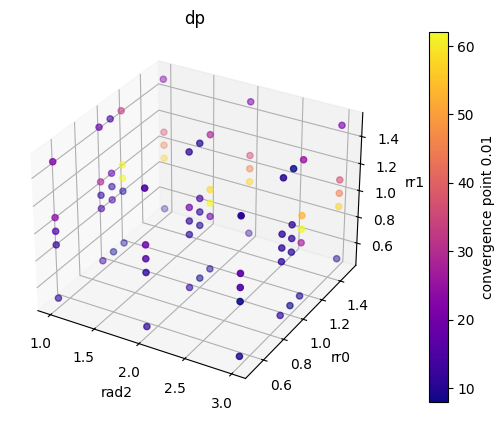

In [38]:
for idx in range(5):
  data = subdivide_lst(all_prob_sets[0], fs["hrs"])[idx]
  plot_hydros_against_3(data, "dp", 0.01, fs["rad2"], fs["rr0s"], fs["rr1s"],
                        "rad2", "rr0", "rr1")

1.1
[9, 9, 9]
[9, 18, 28]


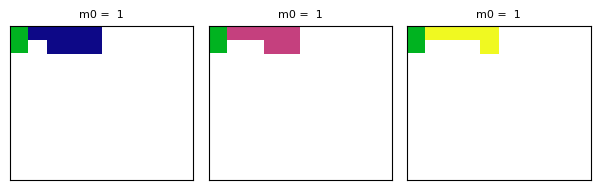

[50, 55, 60]


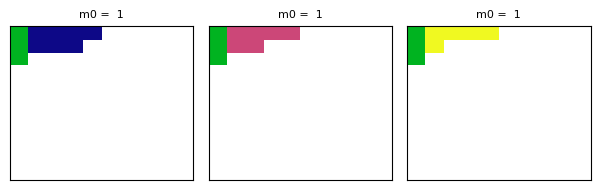

[23, 27, 31]


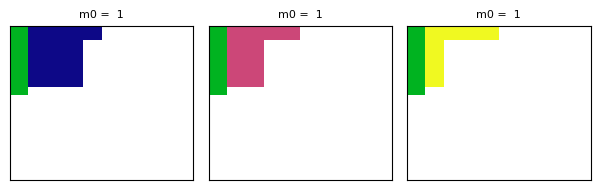

1.5
[9, 9, 9]
[9, 18, 28]


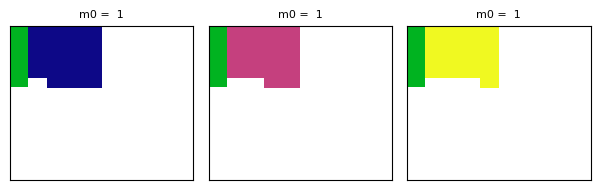

[52, 58, 62]


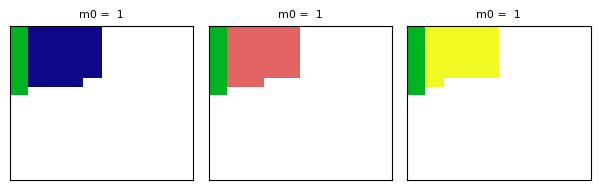

[24, 28, 32]


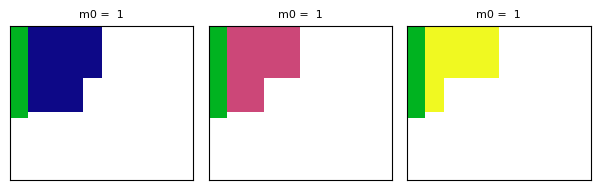

2
[9, 9, 9]
[9, 18, 28]


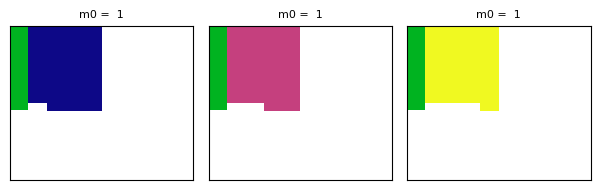

[53, 58, 62]


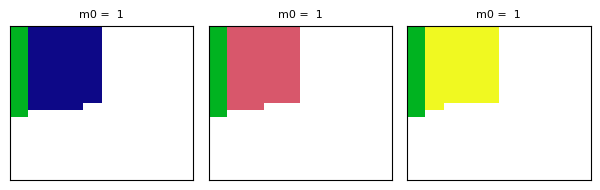

[25, 29, 33]


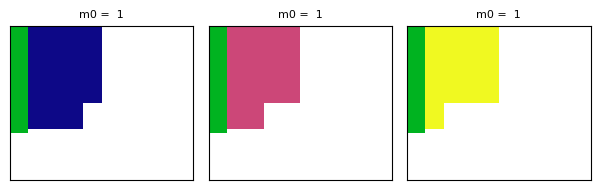

3
[9, 9, 9]
[9, 18, 28]


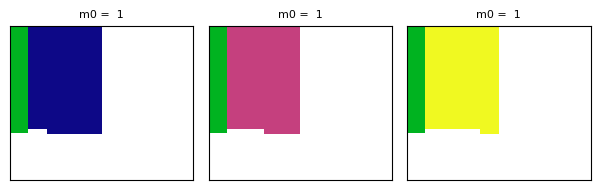

[53, 58, 62]


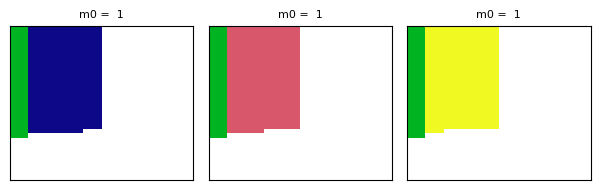

[25, 29, 33]


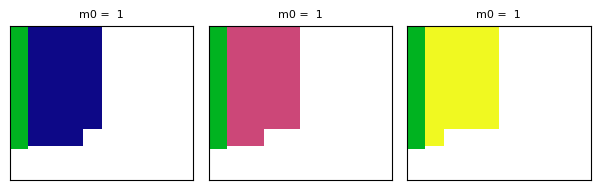

4
[9, 9, 9]
[9, 18, 28]


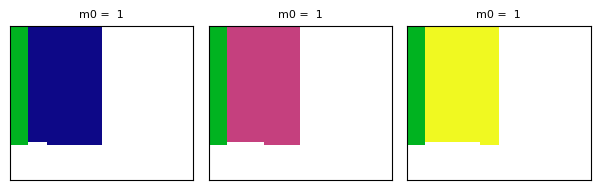

[53, 58, 62]


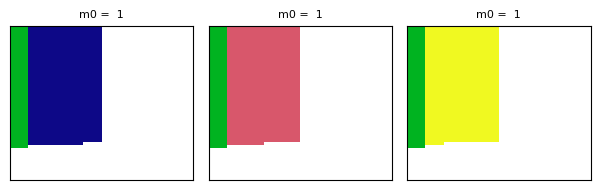

[25, 29, 33]


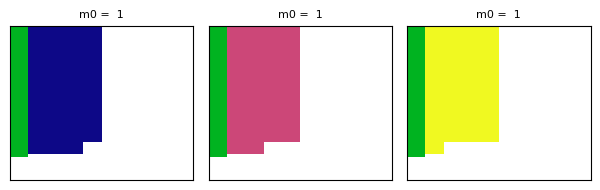

In [40]:
for jdx in [0, 1, 2, 3, 4]:
  print(hrs[jdx])
  for idx in [0, 1, 3, 4]:
    data = subdivide_lst(subdivide_lst(subdivide_lst(all_prob_sets[0], fs["hrs"])[jdx], fs["rr0s"])[3], fs["rr1s"])[idx]
    # histogram(data, "dp", 0.01)
    labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 dp"] for data_dict in data]
    labels.sort()
    print(labels)
    for label in labels:
      if label != labels[0]:
        plot_varied_cases([data], 0, "dp")
        break

1.1
[11, 12, 15]


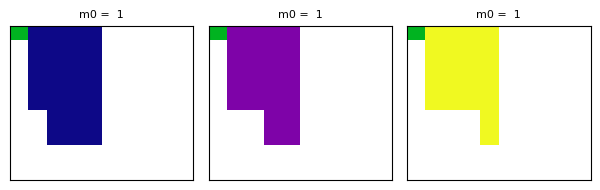

[11, 15, 15]


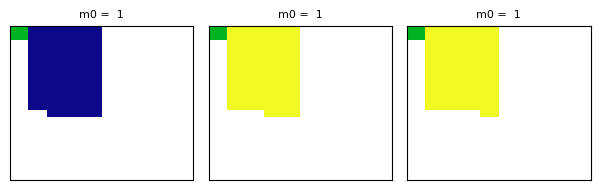

[15, 15, 15]
[15, 15, 15]
1.5
[11, 12, 15]


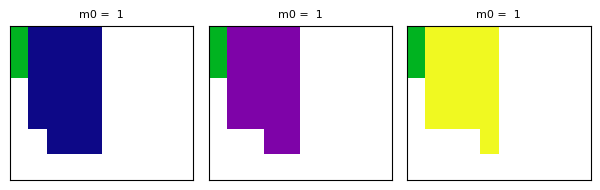

[11, 15, 15]


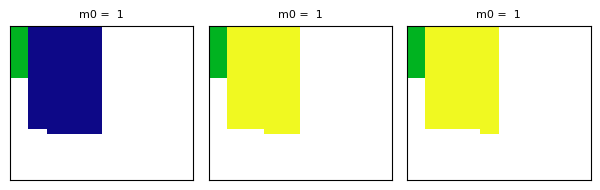

[15, 15, 15]
[15, 15, 15]
2
[11, 12, 15]


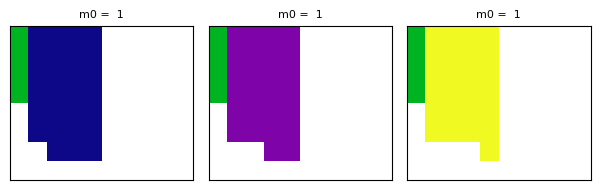

[11, 15, 15]


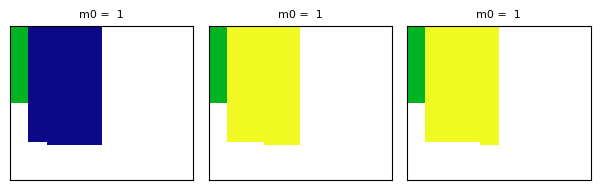

[15, 15, 15]
[15, 15, 15]
3
[11, 12, 15]


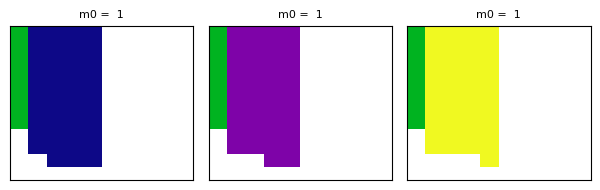

[11, 15, 15]


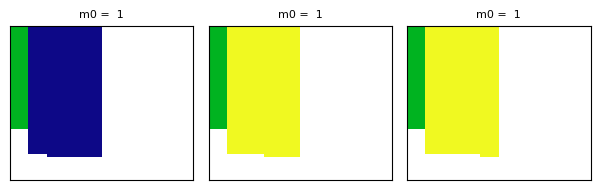

[15, 15, 15]
[15, 15, 15]
4
[11, 12, 15]


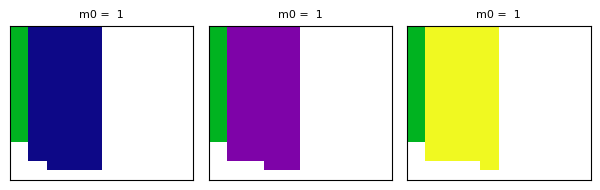

[11, 15, 15]


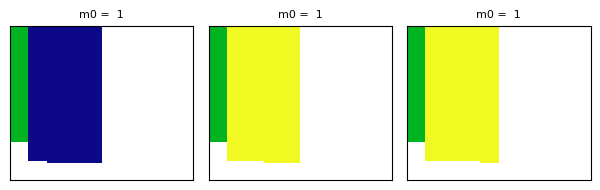

[15, 15, 15]
[15, 15, 15]


In [42]:
for jdx in [0, 1, 2, 3, 4]:
  print(hrs[jdx])
  for idx in [0, 1, 3, 4]:
    data = subdivide_lst(subdivide_lst(subdivide_lst(all_prob_sets[0], fs["hrs"])[jdx], fs["rr0s"])[0], fs["rr1s"])[idx]
    # histogram(data, "dp", 0.01)
    labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in data]
    labels.sort()
    print(labels)
    for label in labels:
      if label != labels[0]:
        plot_varied_cases([data], 0, "am")
        break

1.1
[9, 9, 9]
[9, 18, 28]


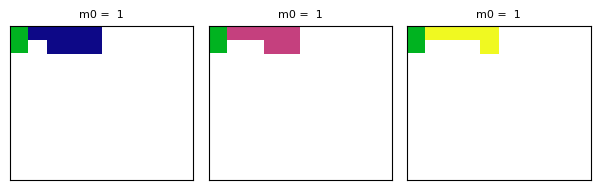

[50, 55, 60]


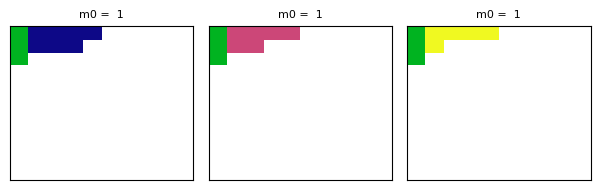

[23, 27, 31]


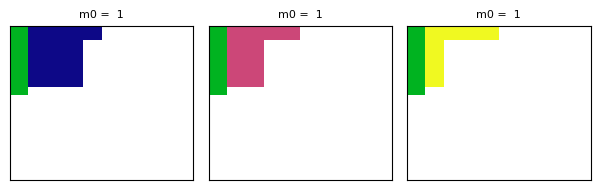

1.5
[9, 9, 9]
[9, 18, 28]


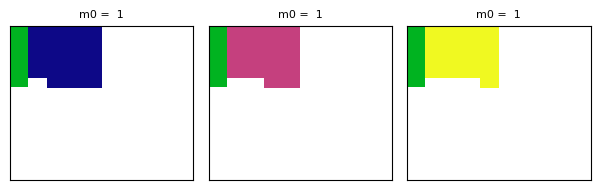

[52, 58, 62]


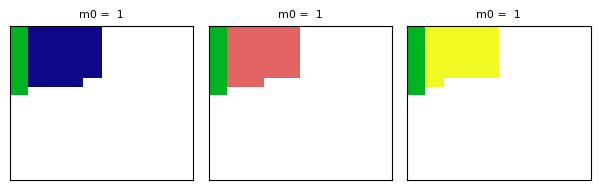

[24, 28, 32]


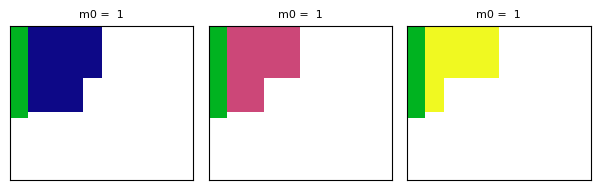

2
[9, 9, 9]
[9, 18, 28]


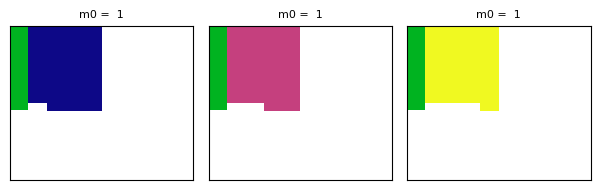

[53, 58, 62]


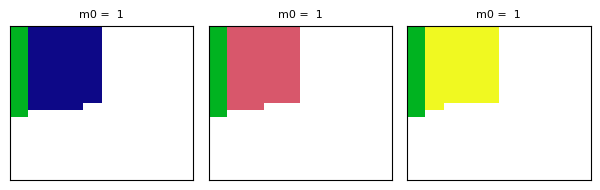

[25, 29, 33]


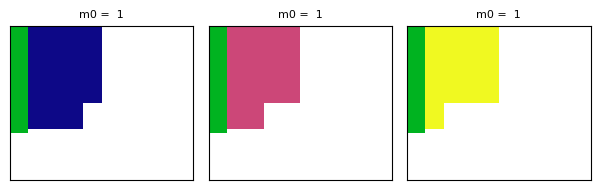

3
[9, 9, 9]
[9, 18, 28]


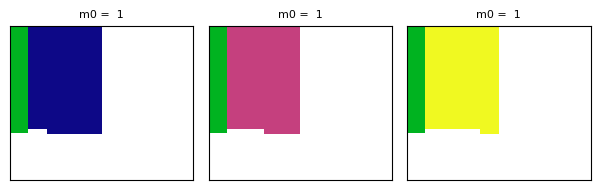

[53, 58, 62]


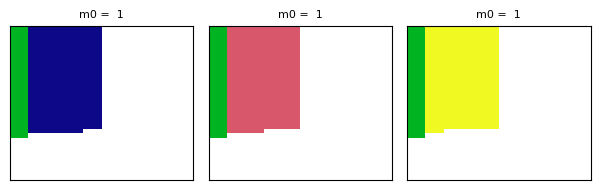

[25, 29, 33]


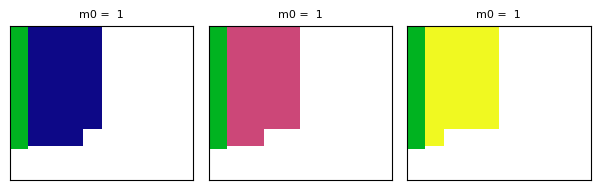

4
[9, 9, 9]
[9, 18, 28]


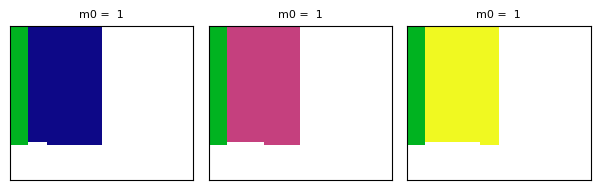

[53, 58, 62]


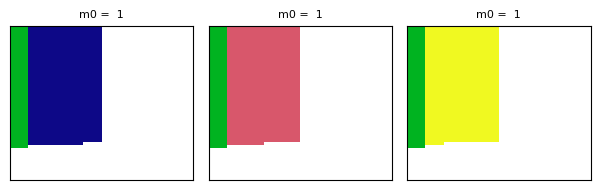

[25, 29, 33]


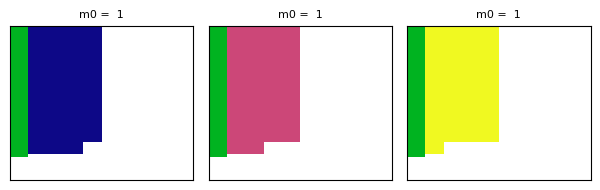

In [37]:
for jdx in [0, 1, 2, 3, 4]:
  print(hrs[jdx])
  for idx in [0, 1, 3, 4]:
    data = subdivide_lst(subdivide_lst(subdivide_lst(all_prob_sets[0], fs["hrs"])[jdx], fs["rr0s"])[3], fs["rr1s"])[idx]
    # histogram(data, "dp", 0.01)
    labels = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 dp"] for data_dict in data]
    labels.sort()
    print(labels)
    for label in labels:
      if label != labels[0]:
        plot_varied_cases([data], 0, "dp")
        break